## Exploratory Data Analysis
### ML Crash Course 2023 / recSys // Suchkova Natalia М8О - 214М - 22
dec 2023 @ MAI IT-Center

>Построение рекомендательной системы на основы данных [Delivery Hero recommendation Dataset](https://drive.google.com/file/d/12N6iHczXIVX4E_KM15jxeJ_7WQ2urHFq/view).
>
>Выбранная локация - **Сингапур**
>
>Этот ноутбук выполнялся на локалке и данные были скачаны в репозиторий, но лучше их доставать из гугл хранилища по [ссылке](https://drive.google.com/drive/folders/1v0oiDUUlZqhvtloymUYT5LmMeSqzrNEP). *Папка ml_crash_course, data_sg - Cингапур, data_se - Cтокгольм*

Для работы с этим ноутбуком необходимо создать папку data и скачать туда файлы из указанной выше ссылки. Результаты обработки будут приложены в репозитории в файле RecSts_PredShopCart.zip

#### Load Libraries

In [103]:
# pip install pandarallel

In [104]:
# pip install translate

In [1]:
import os
import glob

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import geohash2
from h3 import h3
import folium

import phik
from phik.report import plot_correlation_matrix
from translate import Translator
from wordcloud import WordCloud

from IPython.display import clear_output
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=16)
from tqdm import tqdm
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
# import matplotlib.colors as colors
# import matplotlib.cm as cmx

In [3]:
# print(plt.style.available)
plt.style.use('bmh')

In [4]:
PATH = 'C:/Users/User/Desktop/repos/recSys_ShopCartPred/data/'

In [5]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GreEN = '\033[92m'
    YELLOW = '\033[93m'
    reD = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [23]:
# def plot_bar_dist(df, rot, c, xlabel, ylabel='order count', fz=(18, 4)):
#     plt.figure(figsize=fz)
#     df.value_counts().sort_index().plot(kind='bar', rot=rot, color=c, xlabel=xlabel, ylabel=ylabel)
    # plt.show()
    
    
def plot_bar_dist(df, rot, c, xlabel, ylabel='order count', fz=(18, 4), plot_counts=False):  
    plt.figure(figsize=fz)
    # ax = df.groupby(['geohash_shrunk']).size().plot(kind='bar', rot=rot, color=c, xlabel=xlabel, ylabel=ylabel)
    ax = df.value_counts().sort_index().plot(kind='bar', rot=rot, color=c, xlabel=xlabel, ylabel=ylabel)
    if plot_counts:
        ax.bar_label(ax.containers[0]);
    plt.show()

In [24]:
def count_cross_plot(df_k, col_base, col_dop, agg='count', cmap='Set2'):
    df = pd.pivot_table(
        df_k[['order_id', col_base, col_dop]],
        columns=col_base,
        index=col_dop,
        aggfunc=agg
    ).reset_index()

    df.columns = [col if col != '' else key for key, col in df.columns]
    df.plot(
        x=col_dop, 
        kind='barh', 
        figsize=(18, 0.4 * df[col_dop].shape[0]),
        title=f'Distribution of {col_base} by {col_dop}\n',
        xlabel='frequency',
        width=0.9,
        edgecolor='black',
        lw=0.4, 
        cmap=cmap
        ) 

In [25]:
def plot_wordcloud(data):    
    text = ' '.join(name for name in data)
    
    word_cloud = WordCloud(
        collocations=False,
        background_color='white',
        width=2048*2,
        height=1080
    ).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(word_cloud, interpolation='bilinear')
    # plt.show()

#### Load Data

In [26]:
# # Для Google Colab подключения к гугл диску
# collab_env = True
# if collab_env:
#     from google.colab import drive

#     ROOT_DIR = '/content/drive'
#     RANDOM_SEED = 42
#     drive.mount(ROOT_DIR)
#     DRIVE_DATA_DIR = 'ml_crash_course'
#     root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
# else:
#     # in the case of local file systen
#     root_data_dir = '/srv/data/'

# clear_output()
# data_version = '2023_08_06'
# print()
# print("Content in root_data_dir %s:\n%s" % (root_data_dir, [i for i in os.listdir(root_data_dir)]))

In [27]:
# для гугл колаб
# !ls /content/drive/MyDrive/ml_crash_course/data_sg

Ниже приведено описание фич из всех датасетов.

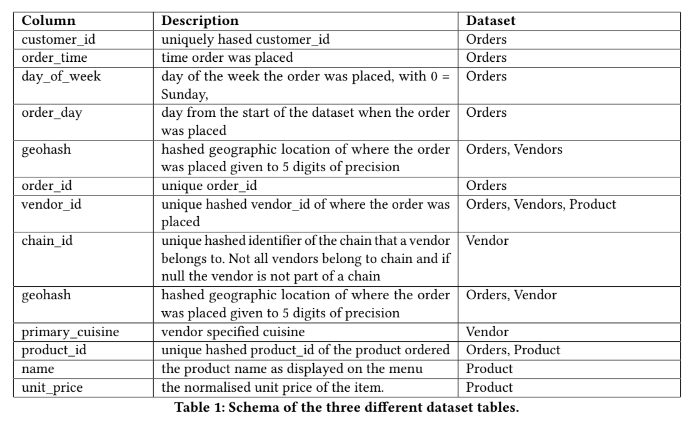

Фичи распределены следующим образом:

Датасет interactions - `Orders`:

- `customer_id`
- `order_time`
- `day_of_week`
- `order_day`
- `geohash`
- `order_id`
- `vendor_id`

Датасет item фич `Products`:

- `vendor_id`
- `product_id`
- `name`
- `unit_price`

Вместо датасета user user фич у нас `Vendors`:

- `vendor_id`
- `chain_id`
- `geohash`
- `primary_cuisine`

## Descriptive DA

Прежде чем приступать к исследованию особенностей данных, необходимо произвести общий анализ данных на предмет пропущенных значений, выбросов, дубликатов и несоответствующих типов данных, а также последующую их предобработку. Для этого ознакомимся с базовыми статистиками и графическим представлением некоторых юзер-айтем фич.

In [28]:
def dda(file_name):
    if ('train' in file_name)  or ('test' in file_name):
        pass
    else:
        ds = pd.read_csv(os.path.join(PATH, 'data_sg', file_name))

        print(color.BOLD + color.GreEN + f'\n-------------------- DDA of {file_name} dataset -----------------------\n' + color.END)

        print(f'The given dataset of {file_name} contains {ds.shape[0]} rows and {ds.shape[1]} columns.\n')

        print('Showing ds info\n')
        display(ds.info())
        print('\n')

        try:
            assert all(ds['Unnamed: 0'] == ds.index)
            ds = ds.drop(ds.columns[0], axis=1)
        except AssertionError:
            print(f'\nThere is df index and column "Unnamed: 0" mismatch in {file_name}')
            display(ds[ds['Unnamed: 0'] != ds.index])
            ds = ds.set_index('Unnamed: 0', drop=False)
            assert all(ds['Unnamed: 0'] == ds.index)
            ds = ds.drop(ds.columns[0], axis=1)

        for col in ds.columns:
            if col in ['customer_id', 'vendor_id', 'product_id', 'chain_id']:
                ds[col] = ds[col].astype(str)
            elif col == 'order_id':
                ds[col] = ds[col].astype(int)

        print('Showing a sum of NaN values by column\n')
        display(ds.isna().sum())
        print('\n')

        numerical_data = ds.select_dtypes(include='number')
        numerical_features=numerical_data.columns.tolist()
        print(f'There are {len(numerical_features)} numerical features in {file_name}:')
        print(numerical_features)

        categorical_data=ds.select_dtypes(include='object')
        categorical_features=categorical_data.columns.tolist()
        print(f'There are {len(categorical_features)} categorical features in {file_name}:')
        print(categorical_features, '\n')

        if len(numerical_features) != 0:
            print(color.BOLD + color.PURPLE + '\n----------- Numerical Features Analysis -----------\n' + color.END)
            print('Showing descriptive stats of numerical columns\n')
            display(numerical_data.describe().T)
            print('\n')

            print('Showing variance of numerical columns\n')
            display(numerical_data.var())
            print('\n')

            print('Showing skew of numerical columns\n')
            display(numerical_data.skew())
            print('\n')

            print('Showing number of unique values in each of numerical features\n')
            display(numerical_data.nunique())
            print('\n')

            print('Showing dist histograms of numerical features\n')
            numerical_data.hist(figsize=(14, 6), bins=20, color='salmon')
            plt.show()


        if len(categorical_features) != 0:
            print(color.BOLD + color.BLUE + '\n----------- Categorical Features Analysis -----------\n' + color.END)
            print('Showing descriptive stats of categorical columns\n')
            display(categorical_data.describe(include='object').T)
            print('\n')

            unique_counts=categorical_data.nunique()
            for index, i in enumerate(range(len(unique_counts))):
                print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
                if unique_counts[i] < 100:
                    print()
                    print(f"\033[1m{categorical_features[i]}\033[0m\n")
                    plot_bar_dist(
                        categorical_data[categorical_features[i]], 
                        90, 
                        'magenta', 
                        categorical_features[i],  
                        fz=(18, 6)
                    )

        ds.to_pickle(f'{file_name.split(".")[0]}')


In [29]:
# для гугл колаб
# os.chdir('/content/drive/MyDrive/ml_crash_course/data_sg')

Посмотрим на общие описательные статистики и визуальное представление фич.


-------------------- DDA of C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\orders_sg.txt dataset -----------------------

The given dataset of C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\orders_sg.txt contains 4023005 rows and 9 columns.

Showing ds info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023005 entries, 0 to 4023004
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Unnamed: 0   int64 
 1   customer_id  object
 2   geohash      object
 3   order_id     int64 
 4   vendor_id    object
 5   product_id   object
 6   day_of_week  int64 
 7   order_time   object
 8   order_day    object
dtypes: int64(3), object(6)
memory usage: 276.2+ MB


None



Showing a sum of NaN values by column



customer_id    0
geohash        0
order_id       0
vendor_id      0
product_id     0
day_of_week    0
order_time     0
order_day      0
dtype: int64



There are 2 numerical features in C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\orders_sg.txt:
['order_id', 'day_of_week']
There are 6 categorical features in C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\orders_sg.txt:
['customer_id', 'geohash', 'vendor_id', 'product_id', 'order_time', 'order_day'] 


----------- Numerical Features Analysis -----------

Showing descriptive stats of numerical columns



count           mean            std  min       25%       50%  \
order_id     4023005.0  994522.623503  580784.271794  0.0  490439.0  986525.0   
day_of_week  4023005.0       3.229277       2.014137  0.0       1.0       3.0   

                   75%        max  
order_id     1500777.0  1999999.0  
day_of_week        5.0        6.0



Showing variance of numerical columns



order_id       3.373104e+11
day_of_week    4.056749e+00
dtype: float64



Showing skew of numerical columns



order_id       0.020994
day_of_week   -0.143856
dtype: float64



Showing number of unique values in each of numerical features



order_id       2000000
day_of_week          7
dtype: int64



Showing dist histograms of numerical features



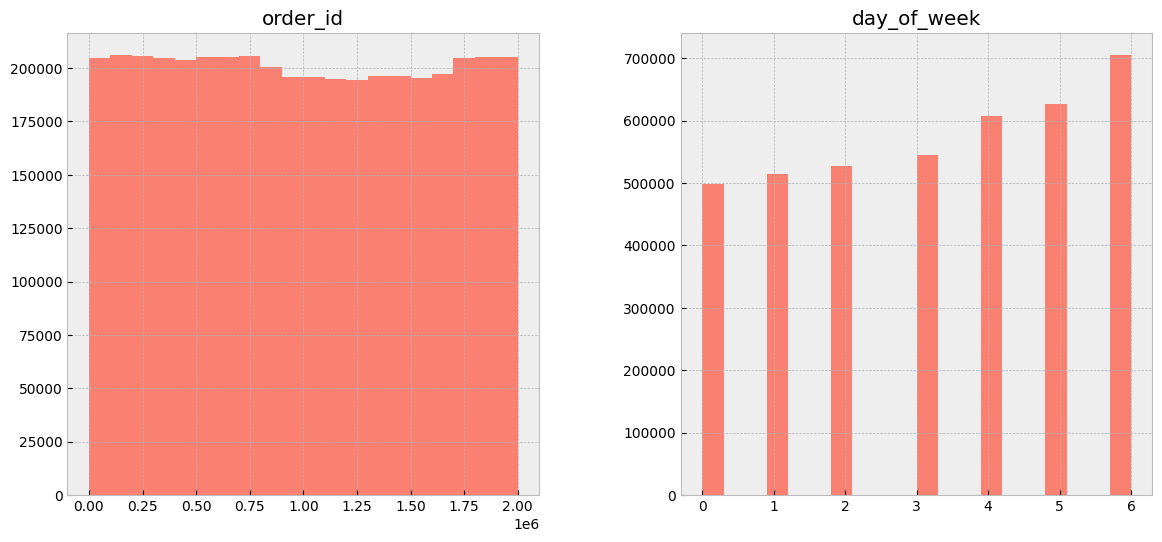


----------- Categorical Features Analysis -----------

Showing descriptive stats of categorical columns



count  unique           top    freq
customer_id  4023005  512916    50acf8536f     691
geohash      4023005      45         w21z6  420840
vendor_id    4023005    7411      709e5409    6704
product_id   4023005  256502  ecc84756562d     803
order_time   4023005   82013      12:11:34     206
order_day    4023005      91       28 days   63454

C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


0 customer_id has 512916 unique values
1 geohash has 45 unique values

geohash



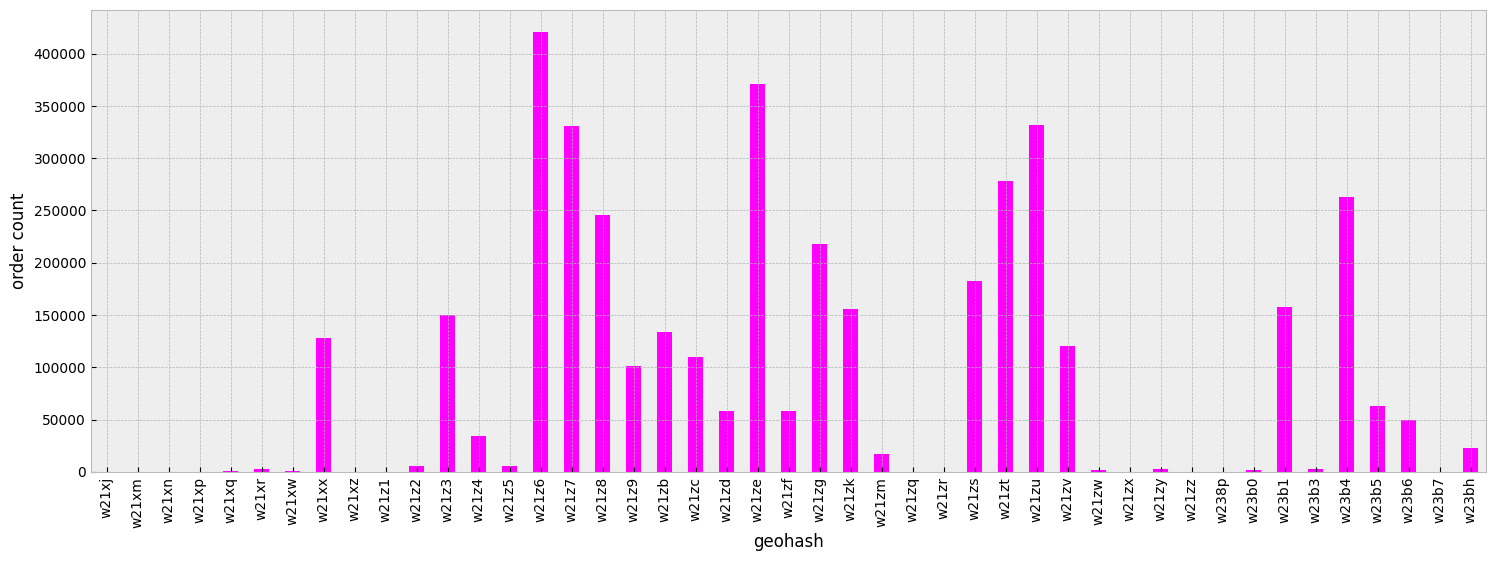

C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


2 vendor_id has 7411 unique values
3 product_id has 256502 unique values
4 order_time has 82013 unique values
5 order_day has 91 unique values

order_day



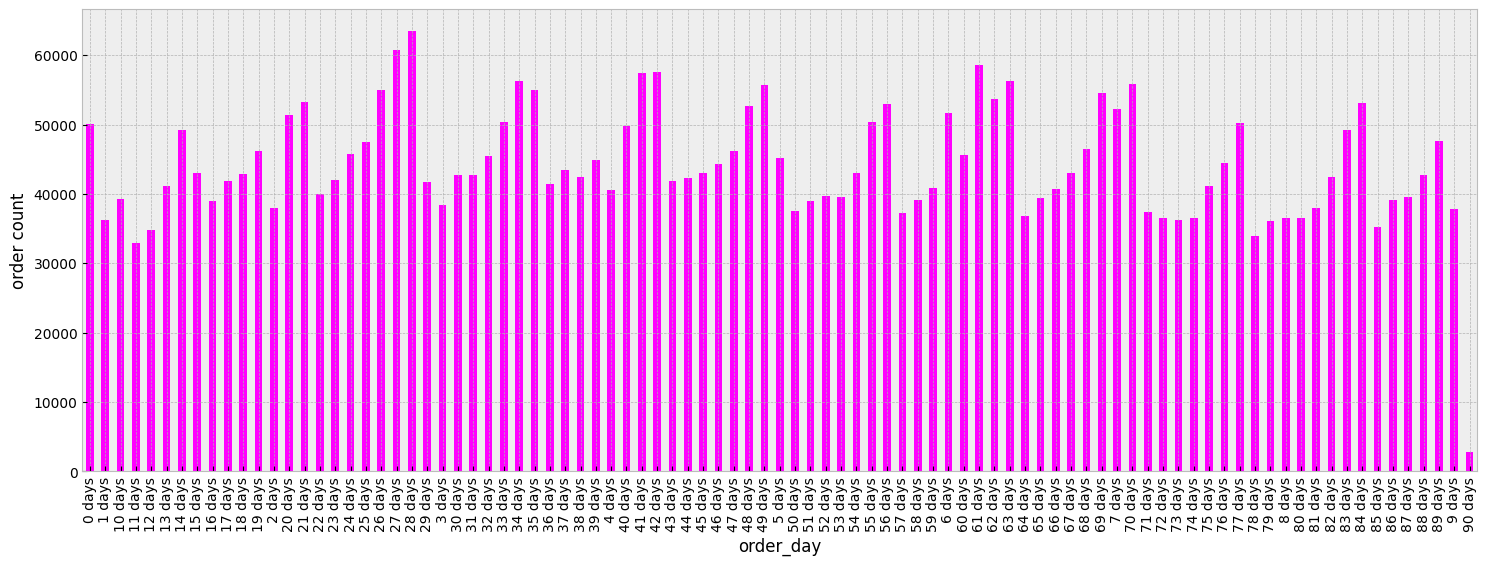


-------------------- DDA of C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\products_sg.txt dataset -----------------------

The given dataset of C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\products_sg.txt contains 1066840 rows and 5 columns.

Showing ds info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066840 entries, 0 to 1066839
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1066840 non-null  int64  
 1   vendor_id   1066840 non-null  object 
 2   product_id  1066840 non-null  object 
 3   name        1066800 non-null  object 
 4   unit_price  1066840 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 40.7+ MB


None



Showing a sum of NaN values by column



vendor_id      0
product_id     0
name          40
unit_price     0
dtype: int64



There are 1 numerical features in C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\products_sg.txt:
['unit_price']
There are 3 categorical features in C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\products_sg.txt:
['vendor_id', 'product_id', 'name'] 


----------- Numerical Features Analysis -----------

Showing descriptive stats of numerical columns



count      mean       std  min  25%     50%     75%  max
unit_price  1066840.0  0.003751  0.008651  0.0  0.0  0.0024  0.0044  1.0



Showing variance of numerical columns



unit_price    0.000075
dtype: float64



Showing skew of numerical columns



unit_price    31.933794
dtype: float64



Showing number of unique values in each of numerical features



unit_price    446
dtype: int64



Showing dist histograms of numerical features



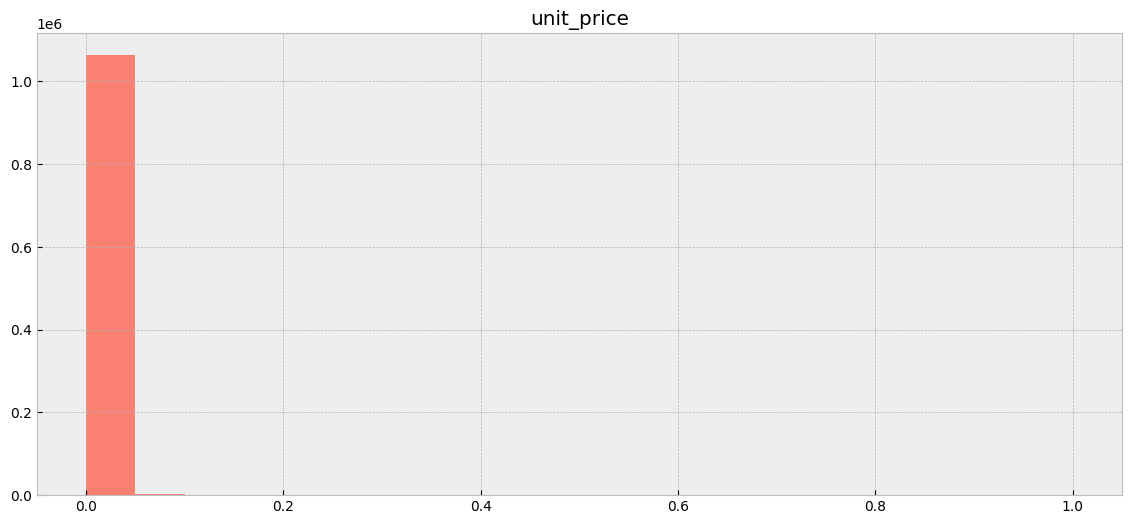


----------- Categorical Features Analysis -----------

Showing descriptive stats of categorical columns



count   unique           top  freq
vendor_id   1066840     7411      7bf10d94  1254
product_id  1066840  1066823  f96cd0f8cb41     2
name        1066800   274914          Coke  1685

C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


0 vendor_id has 7411 unique values
1 product_id has 1066823 unique values
2 name has 274914 unique values

-------------------- DDA of C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\vendors_sg.txt dataset -----------------------

The given dataset of C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\vendors_sg.txt contains 7411 rows and 5 columns.

Showing ds info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7411 entries, 0 to 7410
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       7411 non-null   int64 
 1   vendor_id        7411 non-null   object
 2   chain_id         5912 non-null   object
 3   geohash          7411 non-null   object
 4   primary_cuisine  7411 non-null   object
dtypes: int64(1), object(4)
memory usage: 289.6+ KB


None




There is df index and column "Unnamed: 0" mismatch in C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\vendors_sg.txt


Unnamed: 0 vendor_id  chain_id geohash primary_cuisine
2              4  03eb25e1  5055ab25   w21ze     bak kut teh
3              5  3613129a  8984acb6   w23b1         italian
4              7  0946c9e5  1e3a2913   w21z4     bak kut teh
5             13  89188652       NaN   w21z7           laksa
6             16  e05cc628       NaN   w21z3             tea
...          ...       ...       ...     ...             ...
7406       17798  2d0b2dfb  1a3564c8   w21zt  mala xiang guo
7407       17799  15bbf316  434020fb   w21zs  mala xiang guo
7408       17801  a1f11221  b5431702   w21zu  mala xiang guo
7409       17803  6268886c  0f494195   w21z8  mala xiang guo
7410       17804  ca14a67e  0f494195   w23b6  mala xiang guo

[7409 rows x 5 columns]

Showing a sum of NaN values by column



vendor_id          0
chain_id           0
geohash            0
primary_cuisine    0
dtype: int64



There are 0 numerical features in C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\vendors_sg.txt:
[]
There are 4 categorical features in C:/Users/User/Desktop/repos/recSys_ShopCartPred/data\vendors_sg.txt:
['vendor_id', 'chain_id', 'geohash', 'primary_cuisine'] 


----------- Categorical Features Analysis -----------

Showing descriptive stats of categorical columns



count unique       top  freq
vendor_id        7411   7411  b160c319     1
chain_id         7411   1855       nan  1499
geohash          7411     31     w21z7  1309
primary_cuisine  7411     78   chinese   770



0 vendor_id has 7411 unique values
1 chain_id has 1855 unique values
2 geohash has 31 unique values

geohash



C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


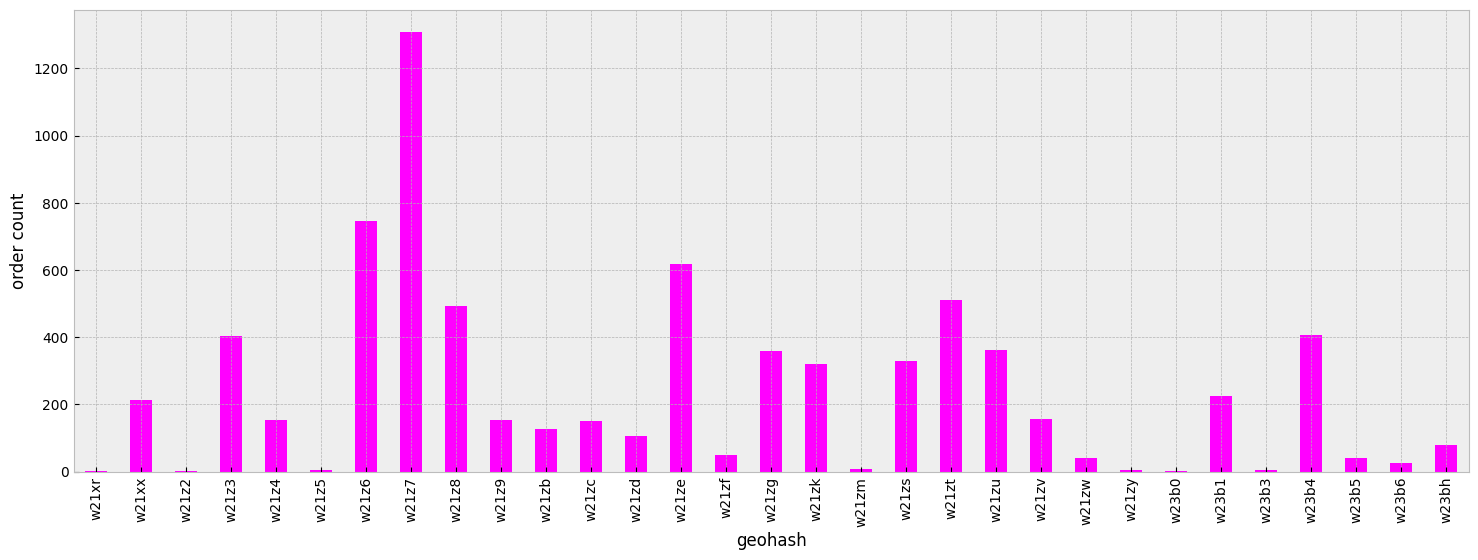

C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_16264\3572897517.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


3 primary_cuisine has 78 unique values

primary_cuisine



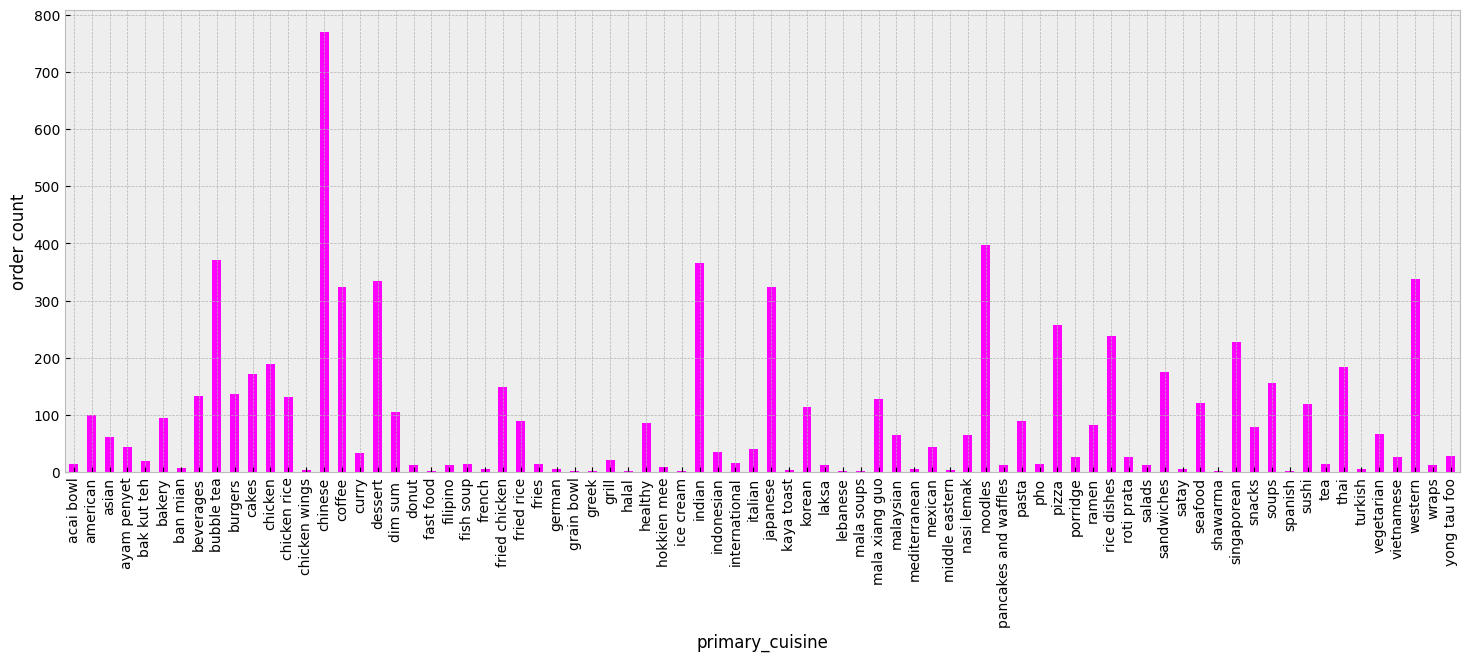

In [30]:
for i in [i for i in glob.glob(PATH + '*.{}'.format('txt'))]:
    dda(i)

**Замечания**
- В динамике покупок по дням недели определяется сезонность
- В датасете продуктов есть дубли по product_id
- В именах продуктов есть 40 пропусков
- Не все продукты есть в истории заказов за период
- Территориальное рапсределение заказов не очень равномерное
- Нормализованная **unit_price** имеет крайне длинный правый хвост (коэф смещения == 31.933794) и очень низкое среднее значение = 0.003 - значит большинство цен низкие, но есть несколько товаров, цена которых лежит на верзней границе диапазона. возможно, их придется выкинуть из анализа


### Check IDs, Uniqueness, Duplicates, Data Types, Data Shapes etc.

In [31]:
%%time
orders_sg = pd.read_pickle('data/orders_sg')
products_sg = pd.read_pickle('data/products_sg')
vendors_sg = pd.read_pickle('data/vendors_sg')

CPU times: total: 2.03 s
Wall time: 2.05 s


Смотрим на наборы связующих id между датасетами.

In [32]:
orders_sg[[col for col in orders_sg.columns if 'id' in col]]

customer_id  order_id vendor_id    product_id
0        1ba124d4e5         0  212753d2  783e85338f1c
1        1ba124d4e5         0  212753d2  084ab73246e6
2        1ba124d4e5         0  212753d2  30eba3cc2676
3        1ba124d4e5         0  212753d2  3910309eea60
4        1ba124d4e5         0  212753d2  20049fb602cb
...             ...       ...       ...           ...
4023000  7e3554a009   1999998  ff0edd9f  7602ccd87eea
4023001  7e3554a009   1999998  ff0edd9f  91129b65ae92
4023002  7e3554a009   1999999  2bba6450  7bb67a5dd524
4023003  7e3554a009   1999999  2bba6450  d40fe2db522c
4023004  7e3554a009   1999999  2bba6450  5925157ecb14

[4023005 rows x 4 columns]

In [33]:
products_sg[[col for col in products_sg.columns if 'id' in col]]

vendor_id    product_id
0        15bbf316  59099e089514
1        e7b24dc0  52e1017fdbd9
2        e7b24dc0  fcb7110cd932
3        7112a20b  d3e7708c2bc9
4        6137ef21  bf0d5ac0e03c
...           ...           ...
1066835  3a3422b7  74792a33ac62
1066836  1ee69614  c782aedb62ae
1066837  67499b6a  59537c172b6a
1066838  f444f459  c999a7a4b2f5
1066839  bfc572b9  9d5c0cd12bda

[1066840 rows x 2 columns]

In [34]:
vendors_sg[[col for col in vendors_sg.columns if 'id' in col]]

vendor_id  chain_id
Unnamed: 0                    
0           b160c319  d2786168
1           9c8f010e  d2786168
4           03eb25e1  5055ab25
5           3613129a  8984acb6
7           0946c9e5  1e3a2913
...              ...       ...
17798       2d0b2dfb  1a3564c8
17799       15bbf316  434020fb
17801       a1f11221  b5431702
17803       6268886c  0f494195
17804       ca14a67e  0f494195

[7411 rows x 2 columns]

Проверяем верно ли сменили типы данных.

In [35]:
orders_sg.dtypes

customer_id    object
geohash        object
order_id        int32
vendor_id      object
product_id     object
day_of_week     int64
order_time     object
order_day      object
dtype: object

In [36]:
products_sg.dtypes

vendor_id      object
product_id     object
name           object
unit_price    float64
dtype: object

In [37]:
vendors_sg.dtypes

vendor_id          object
chain_id           object
geohash            object
primary_cuisine    object
dtype: object

Начальные количества уникальных значений.

In [38]:
orders_sg.nunique()

customer_id     512916
geohash             45
order_id       2000000
vendor_id         7411
product_id      256502
day_of_week          7
order_time       82013
order_day           91
dtype: int64

In [39]:
products_sg.nunique()

vendor_id        7411
product_id    1066823
name           274914
unit_price        446
dtype: int64

In [40]:
vendors_sg.nunique()

vendor_id          7411
chain_id           1855
geohash              31
primary_cuisine      78
dtype: int64

In [41]:
# orders_sg[['customer_id', 'vendor_id', 'product_id']] = orders_sg[['customer_id', 'vendor_id', 'product_id']].astype(str)
# orders_sg['order_id'] = orders_sg['order_id'].astype(int)

# products_sg[['vendor_id', 'product_id']] = products_sg[['vendor_id', 'product_id']].astype(str)
# vendors_sg[['vendor_id', 'chain_id']] = vendors_sg[['vendor_id', 'chain_id']].astype(str)

#### Check Orders DS (Iteractions)

In [42]:
orders_sg['order_time'] = orders_sg['order_time'].astype(str)
orders_sg['order_day'] = orders_sg['order_day'].astype(str)
orders_sg.geohash = orders_sg.geohash.astype(str)

In [43]:
orders_sg.shape

(4023005, 8)

In [44]:
# для удобства сделаем еще числовую фичу из порядкового номера дня заказа
orders_sg['order_day_int'] = orders_sg['order_day'].parallel_apply(lambda x: int(x.replace(' days', '')))

##### Dupl

In [45]:
orders_sg.duplicated(['order_id']).sum()

2023005

Наличие дубликатов в orders_sg еще ни о чем не говорит, так как датасет заказов представляет собой набор уникальных взаимодействий заказчика с каждым продуктом, а в заказе обычно бывает несколько продуктов.

In [46]:
orders_sg.duplicated().sum()

99521

А вот то что в датасете есть полные дубликаты уже говорит о том, что либо это ошибочные дубли, либо о том, что в заказах было по несколько одинаковых товаров

In [47]:
orders_sg[orders_sg.duplicated(keep=False)].sort_values(['order_id', 'product_id'])

customer_id geohash  order_id vendor_id    product_id  day_of_week  \
30       2e7276ad3a   w21z6         6  54a7bf39  badd0863a0a4            2   
31       2e7276ad3a   w21z6         6  54a7bf39  badd0863a0a4            2   
90       60cd03df0e   w21ze        39  94027f7b  20492c73b999            3   
91       60cd03df0e   w21ze        39  94027f7b  20492c73b999            3   
97       ac21229e07   w21zk        43  f06df501  6a0685044984            6   
...             ...     ...       ...       ...           ...          ...   
4022970  2d986ed47a   w23b1   1999983  64bc8b44  e0de4253f716            3   
4022971  2d986ed47a   w23b1   1999983  64bc8b44  e0de4253f716            3   
4022975  83e881ee83   w21z7   1999986  b984a610  d31dbe57757b            0   
4022976  83e881ee83   w21z7   1999986  b984a610  d31dbe57757b            0   
4022977  83e881ee83   w21z7   1999986  b984a610  d31dbe57757b            0   

        order_time order_day  order_day_int  
30        20:40:24   87 days             87  
31        20:40:24   87 days             87  
90        12:20:15   46 days             46  
91        12:20:15   46 days             46  
97        18:38:11   77 days             77  
...            ...       ...            ...  
4022970   11:12:47   53 days             53  
4022971   11:12:47   53 days             53  
4022975   19:09:36   43 days             43  
4022976   19:09:36   43 days             43  
4022977   19:09:36   43 days             43  

[187377 rows x 9 columns]

К обработке дубликатов датасета заказов мы подойдем в конце, когда соберем все датасеты вместе.

##### geohash

In [48]:
def generate_h3_hexagons(lat, lon, resolution):
    hexagons = h3.k_ring(h3.geo_to_h3(lat, lon, resolution), 1)
    return hexagons

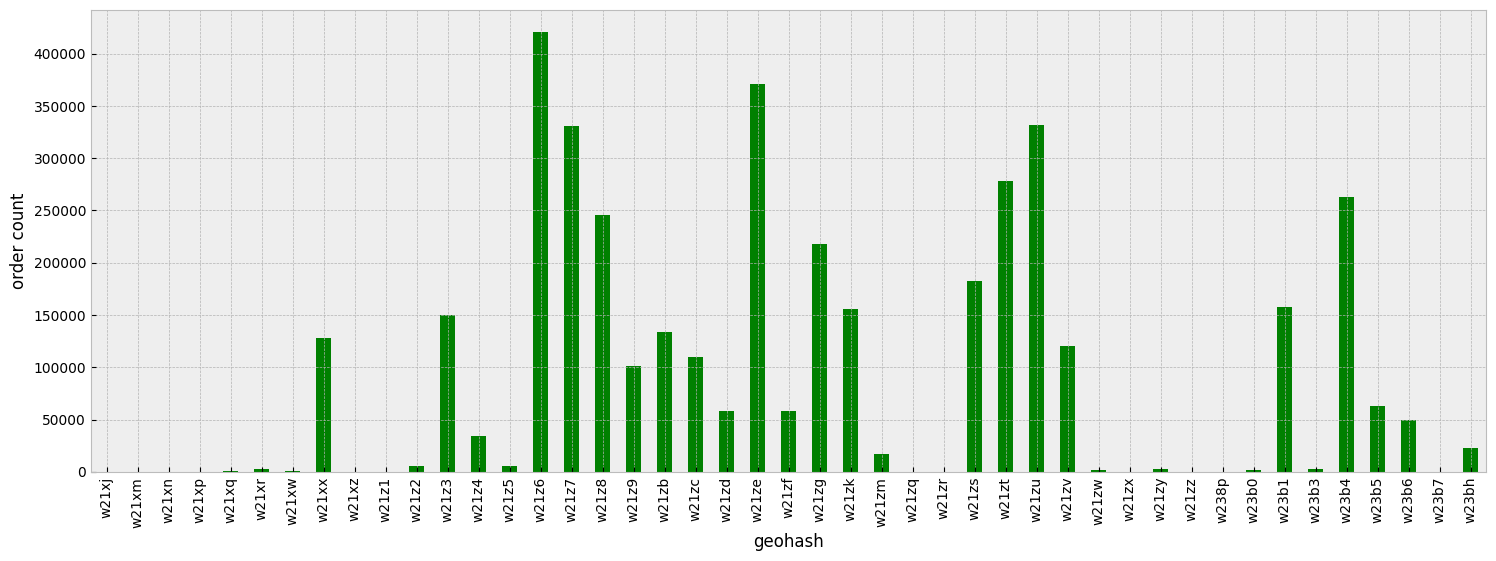

In [49]:
plot_bar_dist(orders_sg['geohash'], 90, 'green', 'geohash', fz=(18, 6))

Самый часто появлявшийся адрес находился в гексагоне w21z6, w21ze. Наверное, находятся в центре города.

Также интересно понять, как геохэши расположены относительно друг друга - установить соседей

In [50]:
hashes = {}
for h in orders_sg.geohash.unique():
    lat, lon = geohash2.decode(h)
    hashes.update({h: [lat, lon]})

# resolution level (e.g., 8)
resolution = 7
for h, coord in hashes.items():
    h3_hash = h3.geo_to_h3(float(coord[0]), float(coord[1]), resolution)
    hashes.update({h: [coord[0], coord[1], h3_hash]})

hashes_df = pd.DataFrame(hashes, index=['lat', 'lon', 'h3_hash']).T
hashes_df.head()
# храним в датасете координаты в виде строки так как длинные дроби могут терять значения после запятой

lat    lon          h3_hash
w21z7  1.3  103.9  876526acdffffff
w21zt  1.3   104.  876526ac4ffffff
w21z6  1.3  103.8  876520d83ffffff
w21z9  1.3  103.8  876520d83ffffff
w21zu  1.4  103.9  876526362ffffff

In [51]:
# вывести маркеры с попапами
# for _, r in hashes_df.iterrows():
#     lat = float(r[0])
#     lon = float(r[1])
#     folium.Marker(
#         location=[lat, lon],
#         popup=f'{_}',
#     ).add_to(m)

# m

In [52]:
# resolution = 8  # Adjust this to your desired resolution
# m = folium.Map(location=[hashes_df.iloc[0, 0], hashes_df.iloc[0, 1]], zoom_start=10)

# for row in hashes_df.iterrows():
#     hexagons = generate_h3_hexagons(float(row[1][0]), float(row[1][1]), resolution)
#     hashes_3.update({row[0]: [row[1][0], row[1][1], row[1][2], hexagons]})
#     for hexagon in hexagons:
#         vertices = h3.h3_to_geo_boundary(hexagon, geo_json=True)
#         folium.Polygon(locations=vertices, color='blue', fill=True, fill_color='blue').add_to(m)

# m

In [53]:
hashes_df.index.nunique()

45

In [54]:
hashes_df[['lat', 'lon']].value_counts(dropna=False)

lat  lon  
1.3  103.8    6
     104.     6
     103.6    5
     103.7    5
     103.9    5
1.4  103.7    4
     103.8    4
     103.9    4
     104.     3
1.5  103.8    2
     103.9    1
Name: count, dtype: int64

In [55]:
resolution = 6
# m = folium.Map(location=[i[0], i[1]], zoom_start=10)
m = folium.Map(location=[float(hashes_df.iloc[0, 0]), float(hashes_df.iloc[0, 1])], zoom_start=11)

for _, r in hashes_df.iterrows():
    hexagon = h3.geo_to_h3(float(r[0]), float(r[1]), resolution)
    vertices = h3.h3_to_geo_boundary(hexagon)
    folium.Polygon(locations=vertices, color="green", fill=True, fill_color="yellow", popup=f'{_}').add_to(m)
m

C:\Users\User\AppData\Local\Temp\ipykernel_16264\2588392661.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hexagon = h3.geo_to_h3(float(r[0]), float(r[1]), resolution)


- w21xj - w21xp - соседи
- w21z1
- w238p
- w21zz
- w23b7
- w23b3

- w21zf - w23bh - w21z5 - соседи
- w21z5 - w21zx - w23bh - соседи

Скорее всего дублирующиеся геохэши появились из-зв неточности геокодирования. Переименуем и агрегируем по геохэшу

In [56]:
remap = hashes_df.reset_index().groupby(['lat', 'lon']).agg(func = {'index': [list], 'h3_hash': [set]}).reset_index()
remap['unique'] = remap.apply(lambda r: r['index', 'list'][-1], axis=1)

In [57]:
remap.columns = remap.columns.droplevel(-1)

In [58]:
remap = dict(zip(remap['h3_hash'].explode(), remap['unique']))
preremap = dict(zip(hashes_df.reset_index()['index'], hashes_df.h3_hash))

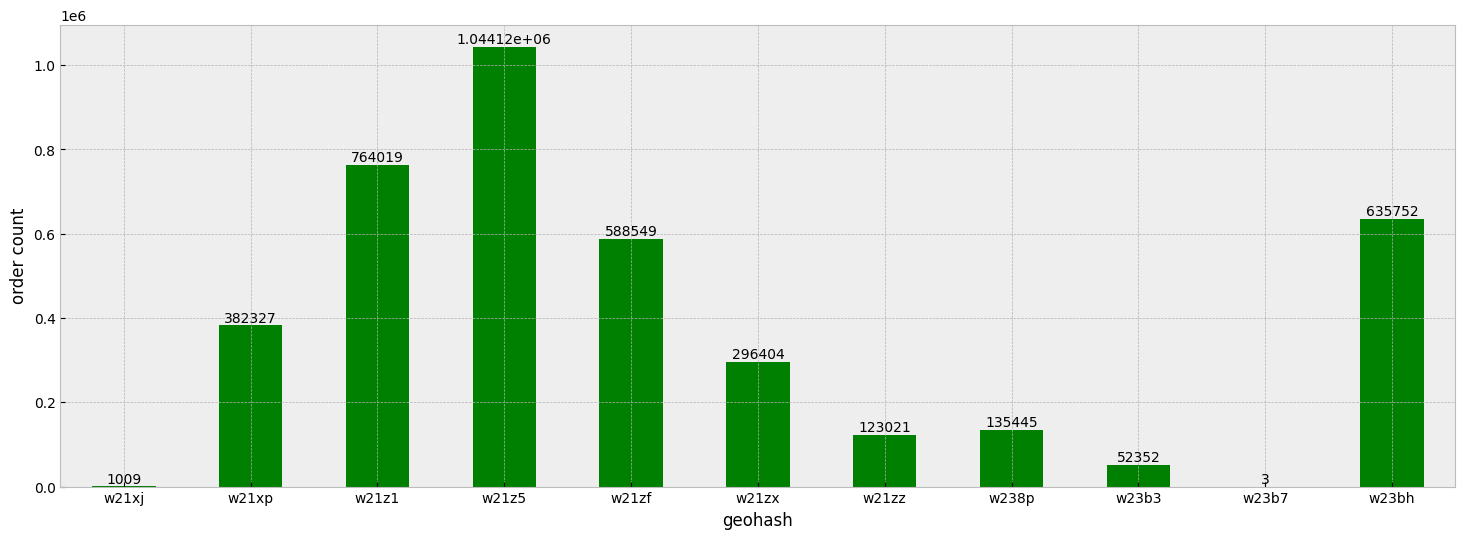

In [59]:
plot_bar_dist(orders_sg['geohash'].map(preremap).map(remap), 0, 'green', 'geohash', fz=(18, 6),  plot_counts=True)

In [60]:
orders_sg['geohash_shrunk'] = orders_sg['geohash'].map(preremap).map(remap)

In [61]:
# делаем ремап соседей
neighbours_dict = {
    'w21xj': ['w21xp'],
    'w21xp': ['w21xj'],
    'w21z1': [],
    'w238p': [],
    'w21zz': [],
    'w23b7': [],
    'w23b3': [],
    'w21zf': ['w23bh', 'w21z5'],
    'w23bh': ['w21z5', 'w21zf'],
    'w21z5': ['w21zx', 'w23bh'],
    'w21zx': ['w21z5', 'w23bh']
}

In [62]:
orders_sg['neighbours'] = orders_sg['geohash_shrunk'].map(neighbours_dict)

##### Week Day

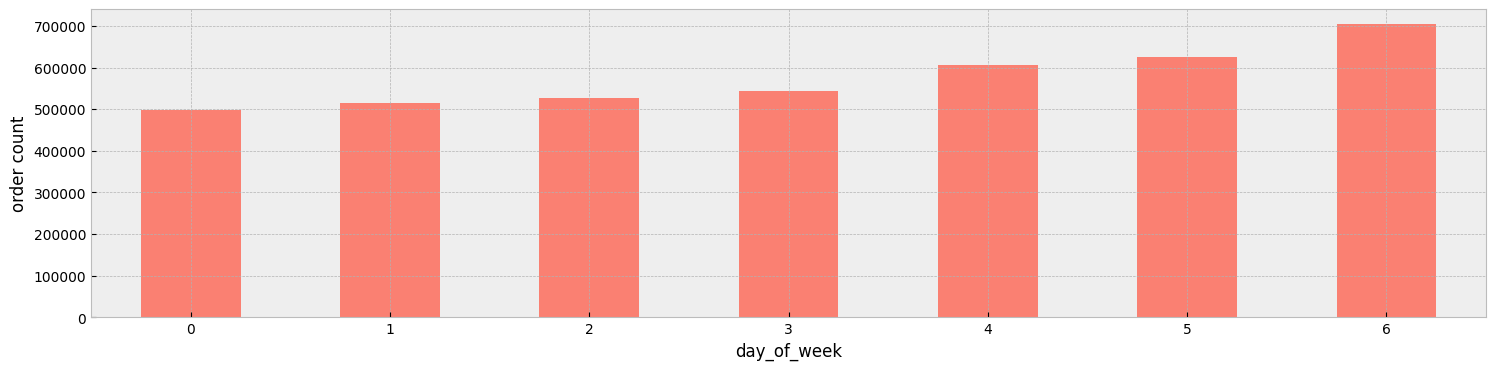

In [63]:
# orders_sg.day_of_week.hist(figsize=(18, 4), bins=20, color='salmon')
plot_bar_dist(orders_sg['day_of_week'], 0, 'salmon', 'day_of_week')

Суббота самый популярный день для покупок. А в воскресение покупают меньше всего.

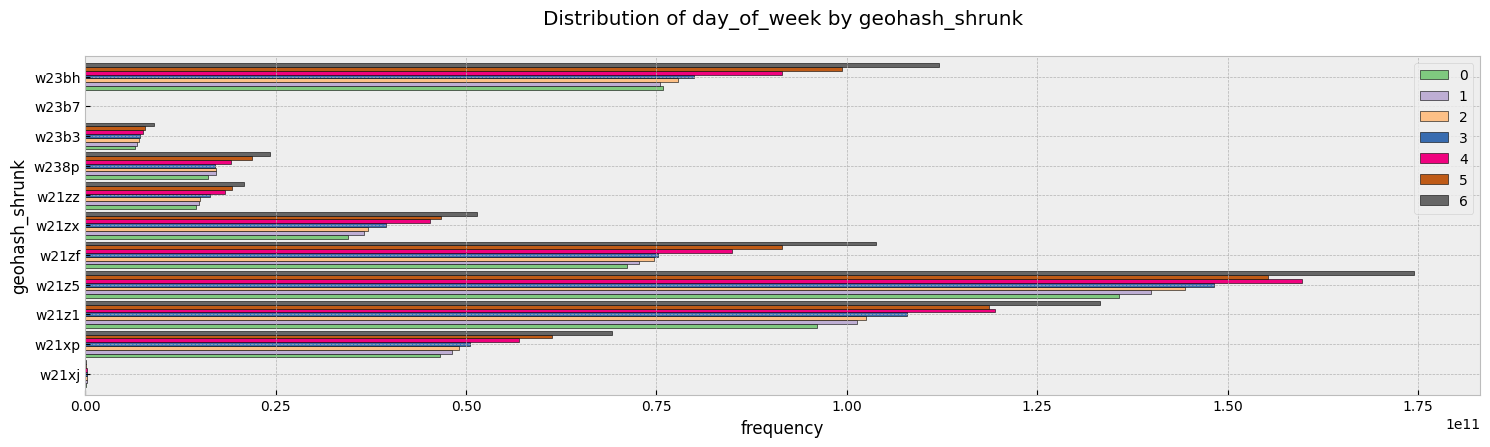

In [64]:
count_cross_plot(orders_sg, 'day_of_week', 'geohash_shrunk', 'sum', 'Accent')

В целом, вне зависимости от местонахождения, самый горячий день - суббота, самый пустой по заказам - воскресенье, в районе w23bh - понедельник.

In [65]:
# count_cross_plot(orders_sg, 'day_of_week', 'order_day', 'sum', 'Accent')

In [66]:
# проверяем, что нет ошибок в соответствии дня заказа и его дня недели
# чтобы не было что один и тот же день помечен как разные лни недели
day_dist = pd.DataFrame(orders_sg[['order_day', 'day_of_week']].value_counts()).reset_index()
day_dist.order_day.duplicated().sum()

0

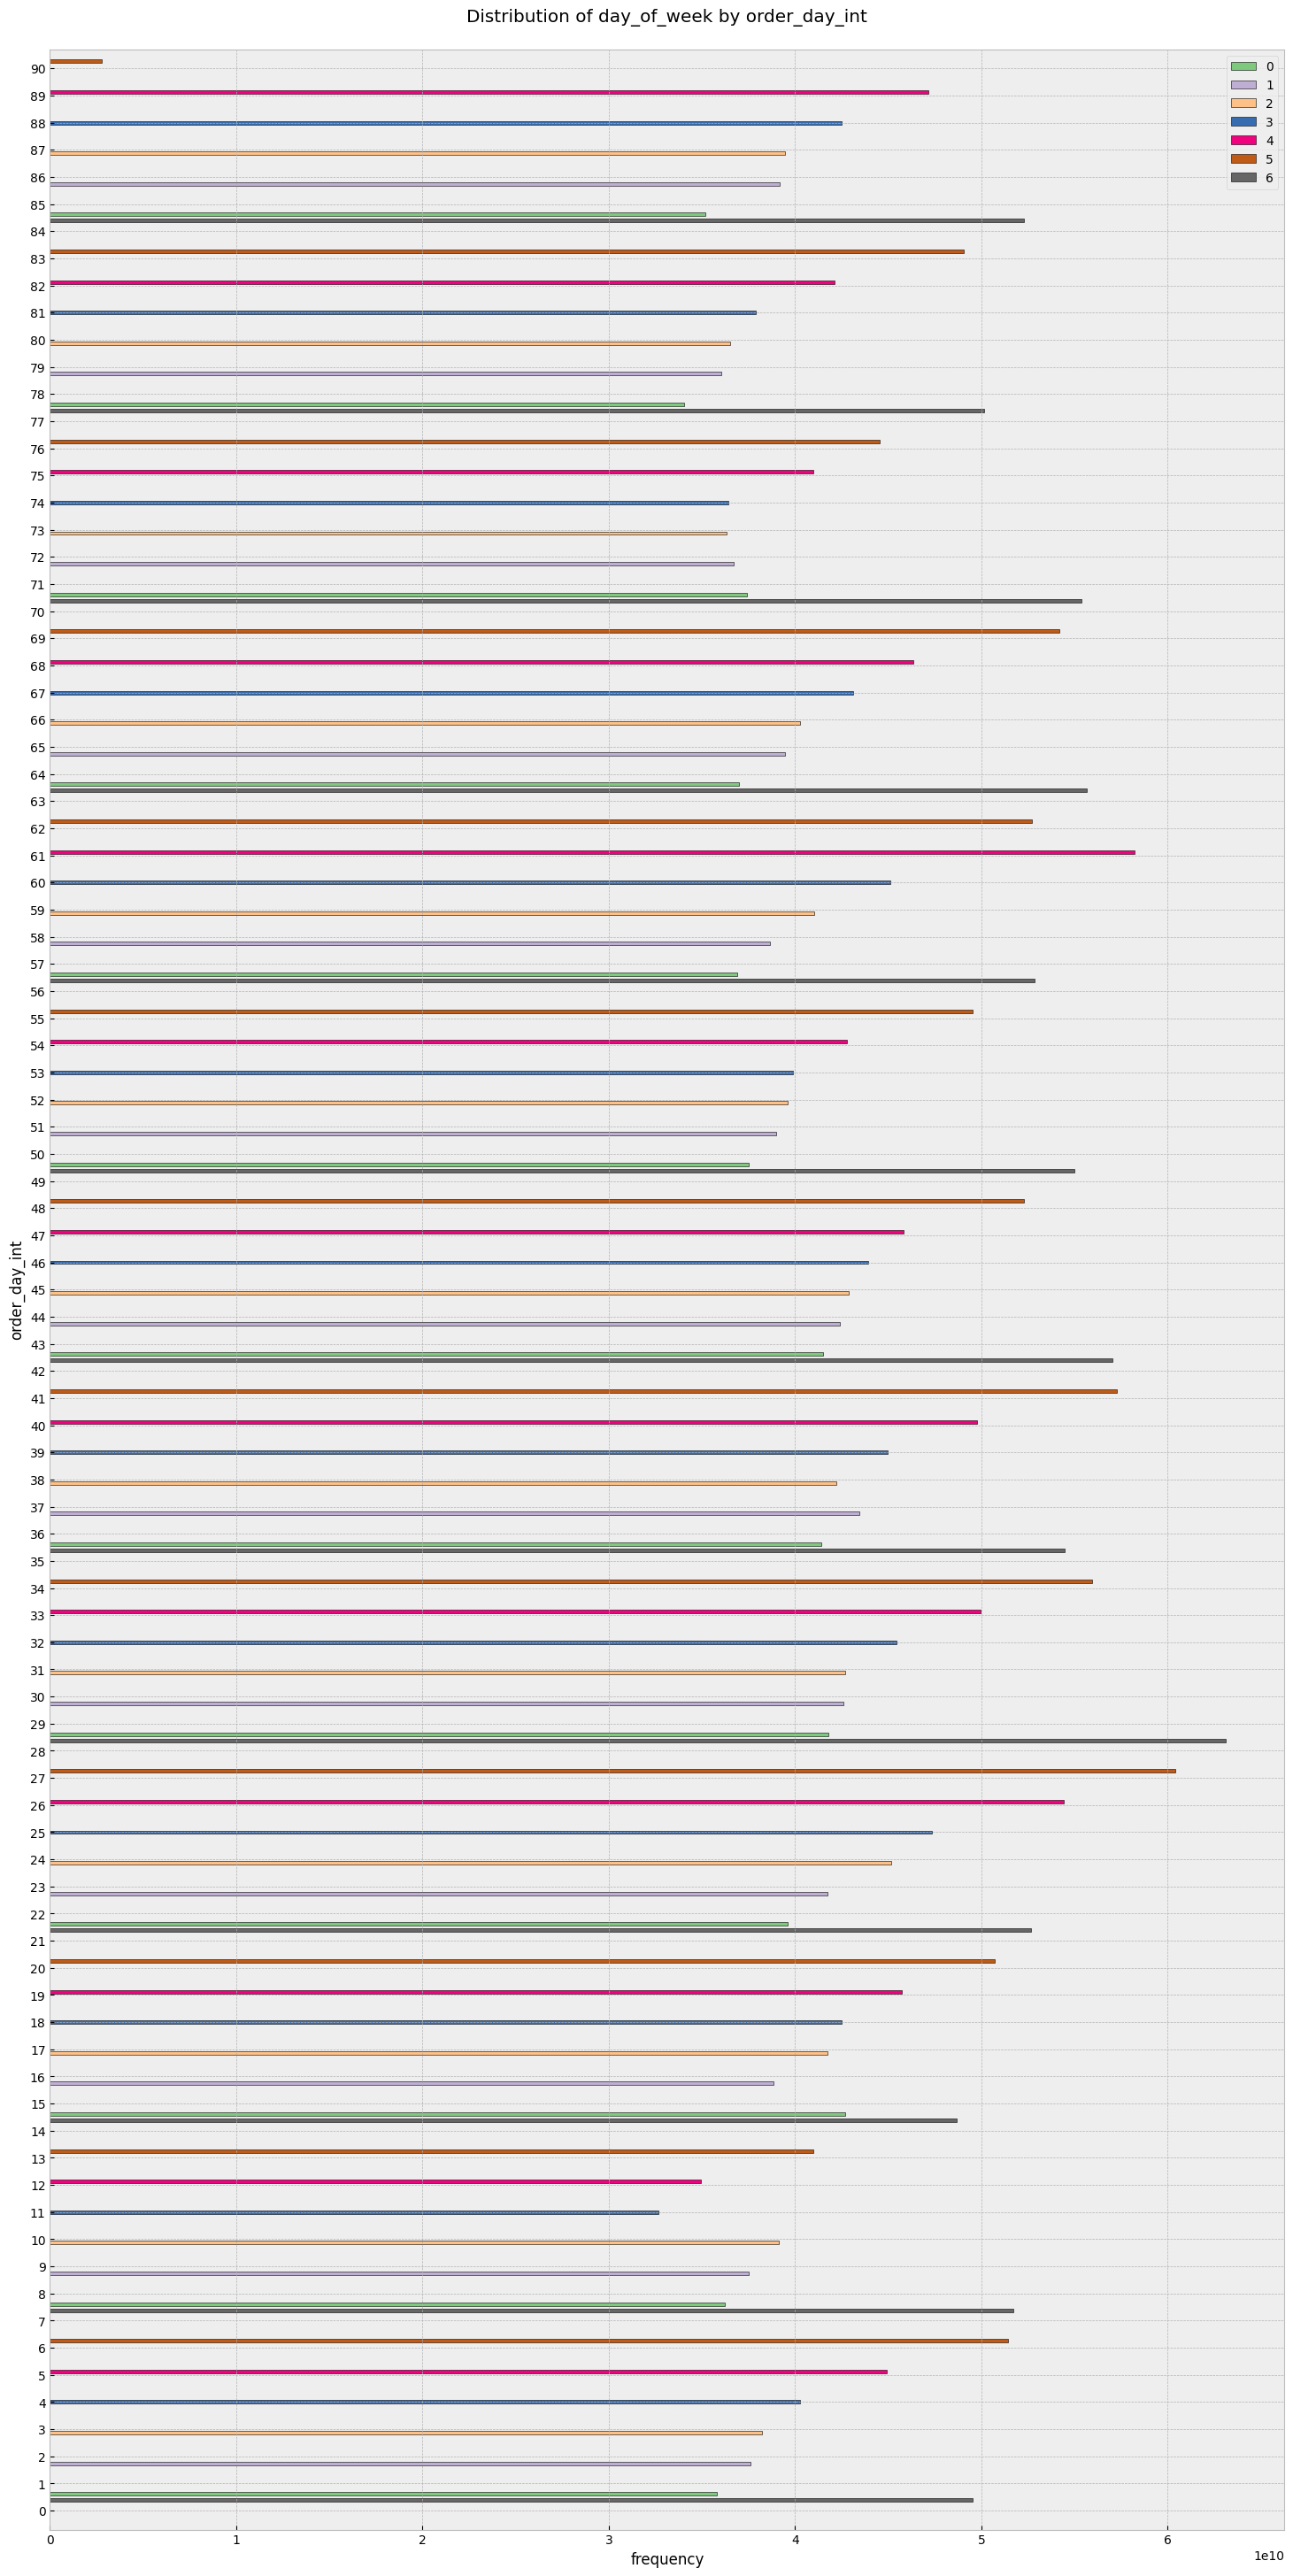

In [67]:
# здесь смотрим чтографик где каждый день подписан его днем недели
# убеждаемся что каждому дню заказа соответствует только 1 день недели и что цвета чередуются в одном порядке в соответствии с легендой
count_cross_plot(orders_sg, 'day_of_week', 'order_day_int', 'sum', 'Accent')

##### Order Day

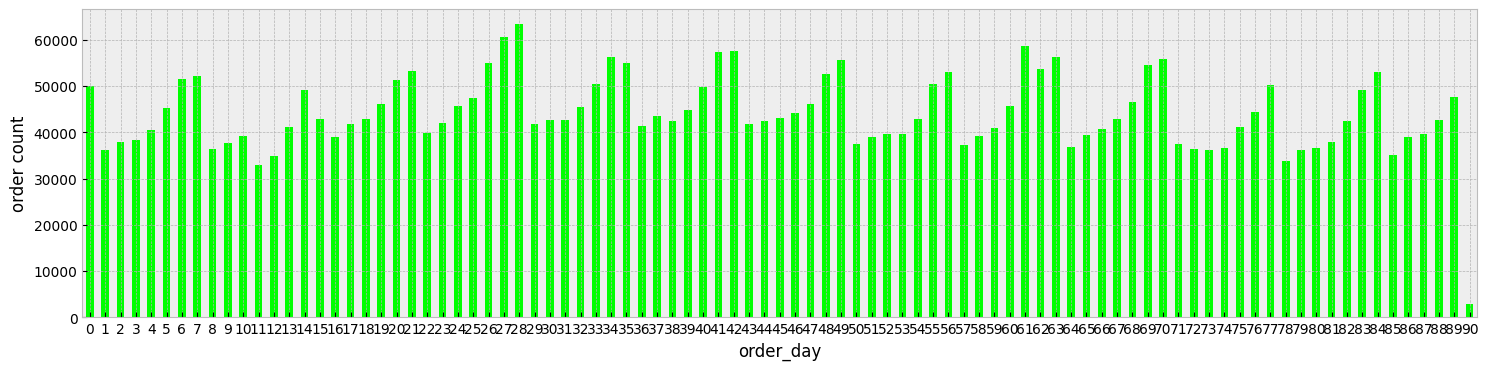

In [68]:
# orders_sg.day_of_week.hist(figsize=(18, 4), bins=20, color='salmon')
plot_bar_dist(orders_sg['order_day_int'], 0, 'lime', 'order_day')

Видим уже замеченную сезонность по дням недели в рассматриваемом промежутке.

Возьмем последние 50 дней  за исключением 90го так как в нем не очень много заказов, чтобы использовать более актуальные заказы и сократить сложность вычислений рекомендаций.

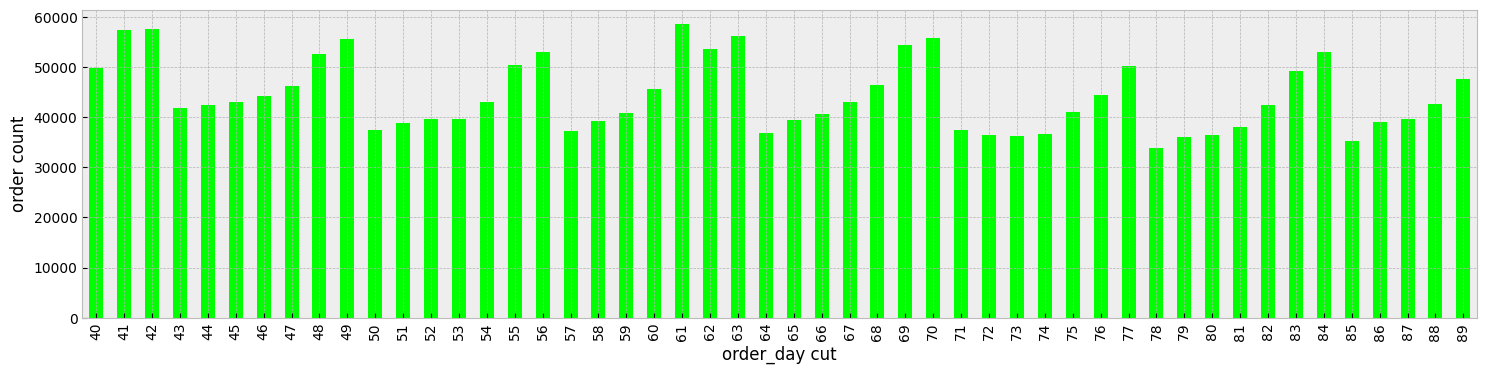

In [69]:
# orders_sg[(orders_sg.order_day_int > 39) & (orders_sg.order_day_int < 90)]['order_day_int'].hist(bins=50)
plot_bar_dist(
    orders_sg[(orders_sg.order_day_int > 39) & (orders_sg.order_day_int < 90)]['order_day_int'], 
    90, 
    'lime', 
    'order_day cut'
)

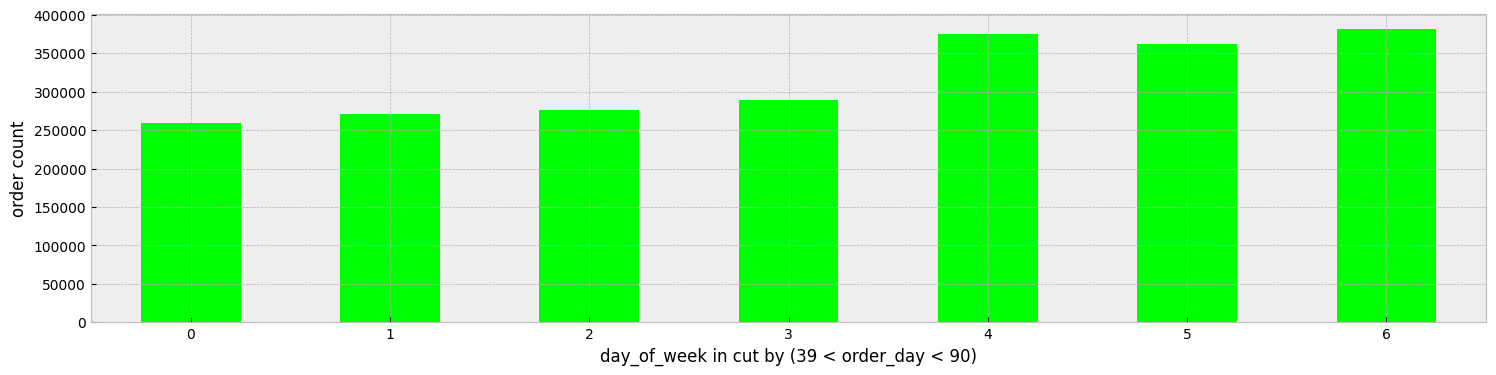

In [70]:
plot_bar_dist(
    orders_sg[(orders_sg.order_day_int > 39) & (orders_sg.order_day_int < 90)]['day_of_week'], 
    0, 
    'lime', 
    'day_of_week in cut by (39 < order_day < 90)'
)

Видно, что в целом тренд не нарушается - вс все еще самый непоулярный день, а суббота самый. Отметим что при такой выборке четверг обогнал пятницу.

In [71]:
# обрезаем заказы по дням !!!!!!
# orders_sg = orders_sg[(orders_sg.order_day_int > 39) & (orders_sg.order_day_int < 90)]

##### Order Time

In [72]:
orders_sg['order_hour'] = orders_sg['order_time'].parallel_apply(lambda x: int(x.split(':')[0]))

In [73]:
orders_sg['order_min'] = orders_sg['order_time'].parallel_apply(lambda x: int(x.split(':')[1]))

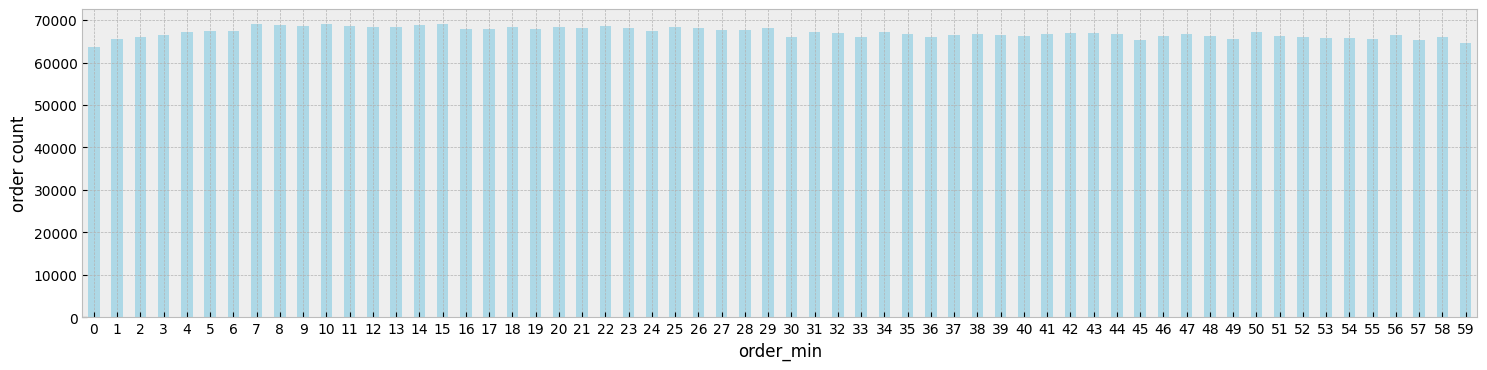

In [74]:
plot_bar_dist(
    orders_sg['order_min'], 
    0, 
    'lightblue', 
    'order_min'
)

Распределение по минутам равномерное.

In [75]:
orders_sg = orders_sg.drop(['order_min'], axis=1)

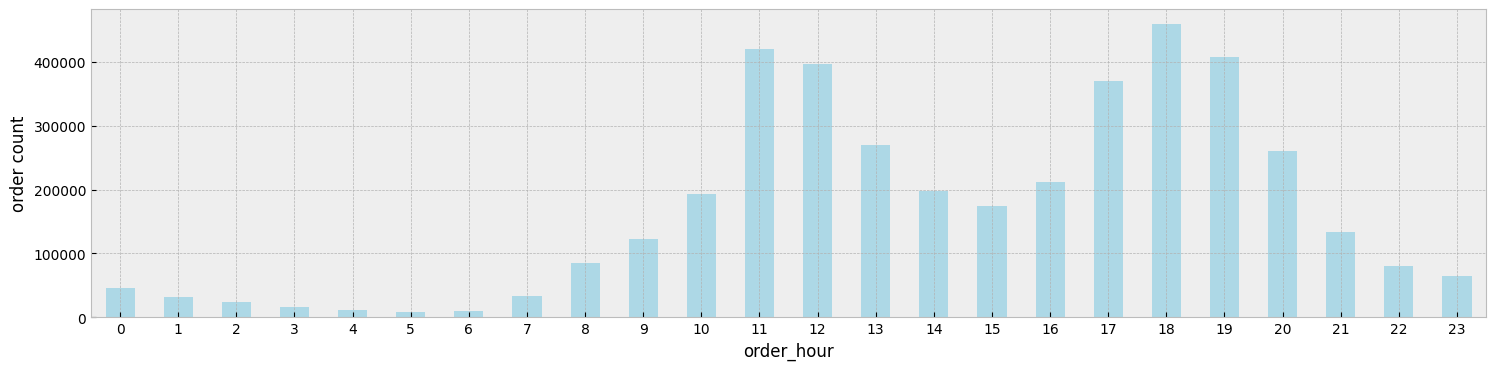

In [76]:
plot_bar_dist(
    orders_sg['order_hour'], 
    0, 
    'lightblue', 
    'order_hour'
)

В количестве заказов по часам наблюдается логичный тренд. Наибольшее количество заказов приходится на вечер.

In [77]:
# здесь можно добавить разбиение по часу на время суток утро денб вечер ночь и использовать как фичу
orders_sg['day_part'] = np.NaN
night_mask = (orders_sg.order_hour > 22) | (orders_sg.order_hour < 5)
morning_mask = (orders_sg.order_hour >= 5) & (orders_sg.order_hour < 12) 
day_mask = (orders_sg.order_hour >= 12) & (orders_sg.order_hour < 17)
evening_mask = (orders_sg.order_hour >= 17) & (orders_sg.order_hour <= 22)

orders_sg.loc[night_mask, 'day_part'] = 'night'
orders_sg.loc[morning_mask, 'day_part'] = 'morning'
orders_sg.loc[day_mask, 'day_part'] = 'day'
orders_sg.loc[evening_mask, 'day_part'] = 'evening'

C:\Users\User\AppData\Local\Temp\ipykernel_16264\1523622129.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'night' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  orders_sg.loc[night_mask, 'day_part'] = 'night'


In [78]:
orders_sg.day_part.value_counts(dropna=False)

day_part
evening    1709635
day        1249181
morning     871739
night       192450
Name: count, dtype: int64

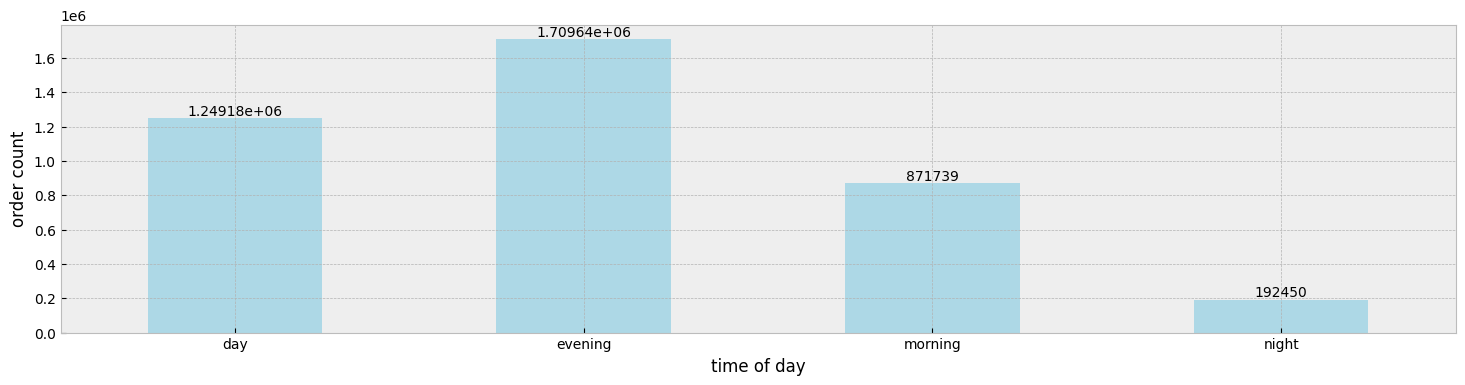

In [79]:
plot_bar_dist(
    orders_sg['day_part'], 
    0, 
    'lightblue', 
    'time of day', 
    plot_counts=True
)

In [80]:
orders_sg.shape

(4023005, 13)

#### Check Products DS and Products Interactions

In [81]:
f'Видим, что всего в датасете продуктов есть {products_sg.product_id.nunique()} уникальных айтема, тогда как в заказах есть всего {orders_sg.product_id.nunique()} товара, что **составляет {orders_sg.product_id.nunique()/products_sg.product_id.nunique() * 100 :.3f}%**'

'Видим, что всего в датасете продуктов есть 1066823 уникальных айтема, тогда как в заказах есть всего 256502 товара, что **составляет 24.044%**'

Видим, что всего в датасете продуктов есть 1066823 уникальных айтема, тогда как в заказах есть всего 256502 товара, что **составляет 24.044%** от всего множества продуктов.

In [82]:
products_sg.shape

(1066840, 4)

In [83]:
# для пометок на удаление
products_sg['to_drop'] = 0

Выше мы видели что в датасете есть пропуски в поле имени:

In [84]:
products_sg.isna().sum()

vendor_id      0
product_id     0
name          40
unit_price     0
to_drop        0
dtype: int64

In [85]:
products_sg[products_sg.name.isna()]

vendor_id    product_id name  unit_price  to_drop
110680   14503eb0  f711e7246c3d  NaN         0.0        0
119303   87fdc8b2  4e6fdcef49b0  NaN         0.0        0
125159   7556d120  c7526f62c0fd  NaN         0.0        0
132537   1c5be2cb  b482c48bd32e  NaN         0.0        0
135779   4b106f17  040f32e3af42  NaN         0.0        0
136546   47e46c6a  1cc4483d7eef  NaN         0.0        0
152681   01b23082  1b9918b019cd  NaN         0.0        0
331949   ac356557  ce8bce9721ef  NaN         0.0        0
337989   f04c1db0  c68d31f8fe77  NaN         0.0        0
342294   375b64e4  ebbed5a13410  NaN         0.0        0
343103   1911b84b  18138f61381e  NaN         0.0        0
348462   3a813d9f  2fb1468b68af  NaN         0.0        0
365250   d43eb5ce  734c30956bda  NaN         0.0        0
369799   3ee5ff45  41aa6afb9fa7  NaN         0.0        0
536340   485586e6  c50b5372e496  NaN         0.0        0
551395   374db999  c22994454552  NaN         0.0        0
561124   2ba9bc65  e9ec0b84071d  NaN         0.0        0
563528   2886913d  189cf65cbec5  NaN         0.0        0
578096   34a783d6  ca8a5d035762  NaN         0.0        0
585575   7bc78e71  402718f69089  NaN         0.0        0
586760   7e5c56e6  122f60e53d34  NaN         0.0        0
588017   7fee4177  488a77b9414f  NaN         0.0        0
588351   2a35e72d  fd7dfa52bce3  NaN         0.0        0
752422   ddceb5f4  23663ab6f7b2  NaN         0.0        0
765431   6ceb2f2b  bebe4e3b876e  NaN         0.0        0
768054   073dd042  bd5dec480871  NaN         0.0        0
775717   aa5bb62e  4dbb3b089674  NaN         0.0        0
789165   3d8e6f02  5d5108201196  NaN         0.0        0
793371   70d371cc  476479986f42  NaN         0.0        0
797133   a706f136  3b30cf620a47  NaN         0.0        0
802404   c7107d4d  5a751b1e45f4  NaN         0.0        0
969029   32a87e6f  14a3966e0e12  NaN         0.0        0
970675   778cb09f  4fbf461adb05  NaN         0.0        0
973091   d146c421  8b3262dce39c  NaN         0.0        0
994036   a89722de  ce2c50c9d713  NaN         0.0        0
997529   7053cfb6  75a460015be9  NaN         0.0        0
997583   e9061bba  df611d755e93  NaN         0.0        0
999279   8b6152fa  6c9d0b540941  NaN         0.0        0
999767   2340b528  cc688940c7cd  NaN         0.0        0
1019982  5042584c  113f92f99e5a  NaN         0.0        0

Удаляем товары без доп данных по имени, так как пропуски в имени и цене к одних и тех же продуктов.

In [86]:
products_sg = products_sg[products_sg.name.notna()]
products_sg.shape

(1066800, 5)

##### Dupl

In [87]:
products_sg.duplicated().sum()

0

In [88]:
products_sg[['vendor_id', 'product_id']].duplicated().sum()

0

In [89]:
products_sg[['vendor_id', 'name', 'unit_price']].duplicated().sum()

0

In [90]:
products_sg[['product_id', 'name', 'unit_price']].duplicated().sum()

12

In [91]:
products_sg[['product_id', 'name']].duplicated().sum()

15

15 дублей по имени и айди продукта

In [92]:
products_sg[['product_id', 'unit_price']].duplicated().sum()

14

In [93]:
# продукты у которых один айди и имя и цена (но разные вендоры)
# на ких посмотрим позже - это скорее всего смена вендора
products_sg[products_sg[['product_id', 'name', 'unit_price']].duplicated(keep=False)].sort_values('product_id').head(4)

vendor_id    product_id  \
841968  4cf81fe1  032690175d82   
392653  a06f1cbf  032690175d82   
919194  987da7cb  06cbeac1e258   
715087  c19e57fb  06cbeac1e258   

                                                  name  unit_price  to_drop  
841968  I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭      0.0028        0  
392653  I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭      0.0028        0  
919194  Teriyaki Chicken Burger with French Fries Meal      0.0036        0  
715087  Teriyaki Chicken Burger with French Fries Meal      0.0036        0

In [94]:
products_sg[products_sg[['product_id', 'name']].duplicated(keep=False)].sort_values('product_id').head(6)

vendor_id    product_id  \
392653  a06f1cbf  032690175d82   
841968  4cf81fe1  032690175d82   
919194  987da7cb  06cbeac1e258   
715087  c19e57fb  06cbeac1e258   
606997  a06f1cbf  0e1f455b56a9   
713906  4cf81fe1  0e1f455b56a9   

                                                  name  unit_price  to_drop  
392653  I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭      0.0028        0  
841968  I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭      0.0028        0  
919194  Teriyaki Chicken Burger with French Fries Meal      0.0036        0  
715087  Teriyaki Chicken Burger with French Fries Meal      0.0036        0  
606997       I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭      0.0028        0  
713906       I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭      0.0028        0

In [95]:
products_sg[products_sg[['product_id', 'unit_price']].duplicated(keep=False)].sort_values('product_id')#.head(6)

vendor_id    product_id  \
841968   4cf81fe1  032690175d82   
392653   a06f1cbf  032690175d82   
919194   987da7cb  06cbeac1e258   
715087   c19e57fb  06cbeac1e258   
606997   a06f1cbf  0e1f455b56a9   
713906   4cf81fe1  0e1f455b56a9   
842537   4cf81fe1  2f9ddb3f502c   
819256   a06f1cbf  2f9ddb3f502c   
201134   60cde597  370c513a5f54   
838206   6e20616b  370c513a5f54   
179743   a06f1cbf  3ae6f3dfb813   
203658   4cf81fe1  3ae6f3dfb813   
642409   fadb1f63  46fa3d16539d   
235537   ca7aceae  46fa3d16539d   
887713   987da7cb  5897822e1acf   
913618   c19e57fb  5897822e1acf   
392374   a06f1cbf  5f9cfe69e1db   
204539   4cf81fe1  5f9cfe69e1db   
819599   a06f1cbf  708349b068e8   
630208   4cf81fe1  708349b068e8   
741511   c85aa5a5  8ad8e3a9aacb   
933717   578908a5  8ad8e3a9aacb   
606234   a06f1cbf  930e41f2f003   
1056800  4cf81fe1  930e41f2f003   
609224   4cf81fe1  b9720354dbeb   
393693   a06f1cbf  b9720354dbeb   
1032620  a06f1cbf  f96cd0f8cb41   
204050   4cf81fe1  f96cd0f8cb41   

                                                    name  unit_price  to_drop  
841968    I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭      0.0028        0  
392653    I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭      0.0028        0  
919194    Teriyaki Chicken Burger with French Fries Meal      0.0036        0  
715087    Teriyaki Chicken Burger with French Fries Meal      0.0036        0  
606997         I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭      0.0028        0  
713906         I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭      0.0028        0  
842537       I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭      0.0028        0  
819256       I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭      0.0028        0  
201134                              Haagen Dazs Mini-Tub      0.0024        0  
838206                             Haagen Dazs Mini-Tub       0.0024        0  
179743   I08. Ginger Onion Diced Chicken with Rice 姜葱鸡丁饭      0.0028        0  
203658   I08. Ginger Onion Diced Chicken with Rice 姜葱鸡丁饭      0.0028        0  
642409      Lam's Signature Whole Chicken Feast 阿南精选双人套餐      0.0152        0  
235537      Lam's Signature Whole Chicken Feast 阿南精选双人套餐      0.0152        0  
887713                                Cheezarella Sticks      0.0012        0  
913618                                Cheezarella Sticks      0.0012        0  
392374             I04. Kyoto Pork Ribs With Rice 京都排骨王饭      0.0028        0  
204539           I04. Jing Du Pork Ribs with Rice 京都排骨王饭      0.0028        0  
819599     I01. Ginger Onion Sliced Pork with Rice 姜葱猪肉饭      0.0028        0  
630208     I01. Ginger Onion Sliced Pork with Rice 姜葱猪肉饭      0.0028        0  
741511        Half Litre Takeaway Apple + FREE 1 Topping      0.0076        0  
933717        Half Litre Takeaway Apple + FREE 1 Topping      0.0076        0  
606234    I07. Dried Chili Diced Chicken with Rice 宫保鸡丁饭      0.0028        0  
1056800   I07. Dried Chili Diced Chicken with Rice 宫保鸡丁饭      0.0028        0  
609224               I25. Fish Head Bee Hoon Soup 鱼头粗米粉汤      0.0032        0  
393693               I25. Fish Head Bee Hoon Soup 鱼头粗米粉汤      0.0032        0  
1032620   I11. Ginger Onion Sliced Fish with Rice 姜葱生鱼片饭      0.0028        0  
204050    I11. Ginger Onion Sliced Fish with Rice 姜葱生鱼片饭      0.0028        0

In [96]:
# продукты у которых один айди и имя но разная цена (и вендоры) - смена вендора
set(products_sg[products_sg[['product_id', 'name']].duplicated(keep=False)].product_id) - \
set(products_sg[products_sg[['product_id', 'unit_price']].duplicated(keep=False)].product_id)

{'2c87c973b870', '5b89c2e3313b', 'd1d3db7bc18f'}

In [97]:
# продукты у которых один айди и цена но разные имена (и вендоры) - смена вендора и имени/ошибка в имени
set(products_sg[products_sg[['product_id', 'unit_price']].duplicated(keep=False)].product_id) -\
set(products_sg[products_sg[['product_id', 'name']].duplicated(keep=False)].product_id)

{'370c513a5f54', '5f9cfe69e1db'}

In [98]:
products_sg.duplicated(['product_id']).sum()

17

17 дублей по id

In [99]:
products_sg[products_sg.duplicated(['product_id'], keep=False)].sort_values('product_id')

vendor_id    product_id  \
841968   4cf81fe1  032690175d82   
392653   a06f1cbf  032690175d82   
715087   c19e57fb  06cbeac1e258   
919194   987da7cb  06cbeac1e258   
713906   4cf81fe1  0e1f455b56a9   
606997   a06f1cbf  0e1f455b56a9   
236011   4cf81fe1  2c87c973b870   
608240   a06f1cbf  2c87c973b870   
819256   a06f1cbf  2f9ddb3f502c   
842537   4cf81fe1  2f9ddb3f502c   
201134   60cde597  370c513a5f54   
838206   6e20616b  370c513a5f54   
179743   a06f1cbf  3ae6f3dfb813   
203658   4cf81fe1  3ae6f3dfb813   
235537   ca7aceae  46fa3d16539d   
642409   fadb1f63  46fa3d16539d   
913618   c19e57fb  5897822e1acf   
887713   987da7cb  5897822e1acf   
821675   a06f1cbf  5b89c2e3313b   
500002   4cf81fe1  5b89c2e3313b   
392374   a06f1cbf  5f9cfe69e1db   
204539   4cf81fe1  5f9cfe69e1db   
630208   4cf81fe1  708349b068e8   
819599   a06f1cbf  708349b068e8   
741511   c85aa5a5  8ad8e3a9aacb   
933717   578908a5  8ad8e3a9aacb   
606234   a06f1cbf  930e41f2f003   
1056800  4cf81fe1  930e41f2f003   
609224   4cf81fe1  b9720354dbeb   
393693   a06f1cbf  b9720354dbeb   
609011   a06f1cbf  d1d3db7bc18f   
893957   4cf81fe1  d1d3db7bc18f   
1032620  a06f1cbf  f96cd0f8cb41   
204050   4cf81fe1  f96cd0f8cb41   

                                                    name  unit_price  to_drop  
841968    I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭      0.0028        0  
392653    I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭      0.0028        0  
715087    Teriyaki Chicken Burger with French Fries Meal      0.0036        0  
919194    Teriyaki Chicken Burger with French Fries Meal      0.0036        0  
713906         I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭      0.0028        0  
606997         I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭      0.0028        0  
236011     I10. Salted Egg Diced Chicken with Rice 咸蛋鸡丁饭      0.0028        0  
608240     I10. Salted Egg Diced Chicken with Rice 咸蛋鸡丁饭      0.0032        0  
819256       I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭      0.0028        0  
842537       I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭      0.0028        0  
201134                              Haagen Dazs Mini-Tub      0.0024        0  
838206                             Haagen Dazs Mini-Tub       0.0024        0  
179743   I08. Ginger Onion Diced Chicken with Rice 姜葱鸡丁饭      0.0028        0  
203658   I08. Ginger Onion Diced Chicken with Rice 姜葱鸡丁饭      0.0028        0  
235537      Lam's Signature Whole Chicken Feast 阿南精选双人套餐      0.0152        0  
642409      Lam's Signature Whole Chicken Feast 阿南精选双人套餐      0.0152        0  
913618                                Cheezarella Sticks      0.0012        0  
887713                                Cheezarella Sticks      0.0012        0  
821675         I09. Butter Diced Chicken with Rice 奶皇鸡丁饭      0.0032        0  
500002         I09. Butter Diced Chicken with Rice 奶皇鸡丁饭      0.0028        0  
392374             I04. Kyoto Pork Ribs With Rice 京都排骨王饭      0.0028        0  
204539           I04. Jing Du Pork Ribs with Rice 京都排骨王饭      0.0028        0  
630208     I01. Ginger Onion Sliced Pork with Rice 姜葱猪肉饭      0.0028        0  
819599     I01. Ginger Onion Sliced Pork with Rice 姜葱猪肉饭      0.0028        0  
741511        Half Litre Takeaway Apple + FREE 1 Topping      0.0076        0  
933717        Half Litre Takeaway Apple + FREE 1 Topping      0.0076        0  
606234    I07. Dried Chili Diced Chicken with Rice 宫保鸡丁饭      0.0028        0  
1056800   I07. Dried Chili Diced Chicken with Rice 宫保鸡丁饭      0.0028        0  
609224               I25. Fish Head Bee Hoon Soup 鱼头粗米粉汤      0.0032        0  
393693               I25. Fish Head Bee Hoon Soup 鱼头粗米粉汤      0.0032        0  
609011             I06. Butter Pork Ribs with Rice 奶皇排骨饭      0.0032        0  
893957             I06. Butter Pork Ribs with Rice 奶皇排骨饭      0.0028        0  
1032620   I11. Ginger Onion Sliced Fish with Rice 姜葱生鱼片饭      0.0028        0  
204050    I11. Ginger Onion Sliced Fish with Rice 姜葱生鱼片饭      

In [100]:
products_sg.duplicated(['vendor_id', 'product_id']).sum()

0

Есть дубли по айди, нет абсолютных дубликатов в продуктах по айди и вендору, что хорошо

Кажется немного странным что у разных вендоров в датасете есть абсолютно идентичные товары по названию и цене, нужна доп информация. Скорее всего это все товары у которых за рассматриваемый период менялся вендор. Позднее мы все равно будем клеить продукты к заказам, тогда будет видно, какие вендоры актуальные для заказов и мы удалим которые не приклеятся из-за смены вендора.

У количество дублей по айди и по имени и айди отличается. 15 дублей по имени и айди, проверим сначала, где еще 2 продукта, которые дубли просто по айди

In [101]:
set(products_sg[products_sg.duplicated(['product_id'], keep=False)].name) - set(products_sg[products_sg.duplicated(['name', 'product_id'], keep=False)].name)

{'Haagen Dazs Mini-Tub',
 'Haagen Dazs Mini-Tub ',
 'I04. Jing Du Pork Ribs with Rice 京都排骨王饭',
 'I04. Kyoto Pork Ribs With Rice 京都排骨王饭'}

В 1 продукте есть опечатка в виде доп пробела, это поправим чтобы не было доп товаров

Во 2 продукте есть различие в названии несмотря на то, что они вроде бы одинаковые

In [102]:
products_sg.loc[products_sg.name == 'Haagen Dazs Mini-Tub ', 'name']  = 'Haagen Dazs Mini-Tub'

In [103]:
products_sg.loc[products_sg.name == 'I04. Jing Du Pork Ribs with Rice 京都排骨王饭']

vendor_id    product_id                                     name  \
204539  4cf81fe1  5f9cfe69e1db  I04. Jing Du Pork Ribs with Rice 京都排骨王饭   
416581  7bcc735a  14a828fd7ca5  I04. Jing Du Pork Ribs with Rice 京都排骨王饭   

        unit_price  to_drop  
204539      0.0028        0  
416581      0.0028        0

In [104]:
products_sg.loc[products_sg.name == 'I04. Kyoto Pork Ribs With Rice 京都排骨王饭']

vendor_id    product_id                                   name  \
392374  a06f1cbf  5f9cfe69e1db  I04. Kyoto Pork Ribs With Rice 京都排骨王饭   
393391  7bcc735a  db9ea30b4a0f  I04. Kyoto Pork Ribs With Rice 京都排骨王饭   

        unit_price  to_drop  
392374      0.0028        0  
393391      0.0028        0

In [105]:
translator = Translator(from_lang="zh", to_lang='en')
print(
    translator.translate("京都排骨王饭"),
    '\n',
    translator.translate("京都排骨王饭")
)

MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  09 HOURS 37 MINUTES 51 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE 
 MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  09 HOURS 37 MINUTES 50 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE


 Интересная ситуация, похожая на ошибку либо изменения в данных

Из этих 4х 
- товары с одинаковым названием имеют разные айди
- товары с одинаковыми айди 5f9cfe69e1db имеют разные названия
- все товары имеют одинаковую цену
- товары имеют идентичную форму записи и одинаковый конец названия на китайском

Логично переименовать Jing Du в Kyoto, так как перевод говорит что там есть слово Киото и чтобы один и тот же товар не рекомендовался как разные 

С другой стороны если это сделать, то у одного вендора будут продукты с одинаковым названием. но разными айди, и у разных вендоров будет товар с одним и тем же айди и названием. Второе мы уже встречали в этих данных, оставим, а для первой проблемы -  проверим есть ли этот товар в заказах и просто кикнем этот товар, либо сменим вендора

In [106]:
orders_sg[orders_sg.product_id.isin(['db9ea30b4a0f', '5f9cfe69e1db', '14a828fd7ca5'])]

customer_id geohash  order_id vendor_id    product_id  day_of_week  \
33599    8a4d6dfcb3   w21zt     16379  a06f1cbf  5f9cfe69e1db            6   
596073   3ddfc03ef2   w21zt    290150  a06f1cbf  5f9cfe69e1db            5   
728250   baaa90a060   w21zt    354648  a06f1cbf  5f9cfe69e1db            5   
961776   115a5fba9c   w21zt    468672  a06f1cbf  5f9cfe69e1db            0   
1397761  0442917069   w21zt    681717  a06f1cbf  5f9cfe69e1db            0   
1437172  2ad0374431   w21zt    700675  a06f1cbf  5f9cfe69e1db            3   
1437173  2ad0374431   w21zt    700676  a06f1cbf  5f9cfe69e1db            6   
1962742  f2a1265bd4   w21zv    961582  a06f1cbf  5f9cfe69e1db            4   
1962745  f2a1265bd4   w21zv    961582  a06f1cbf  5f9cfe69e1db            4   
2603189  f63289b389   w21zt   1289523  a06f1cbf  5f9cfe69e1db            1   
2902162  42f6694a14   w21zt   1441949  a06f1cbf  5f9cfe69e1db            2   
3256846  fab864bef7   w21zt   1623265  a06f1cbf  5f9cfe69e1db            6   
3765535  3aac7e0ac4   w21zt   1874563  a06f1cbf  5f9cfe69e1db            5   
3865450  c4170fa3bd   w21zt   1923153  a06f1cbf  5f9cfe69e1db            6   

        order_time order_day  order_day_int geohash_shrunk      neighbours  \
33599     20:10:11   56 days             56          w21zx  [w21z5, w23bh]   
596073    20:42:28   34 days             34          w21zx  [w21z5, w23bh]   
728250    17:31:05   48 days             48          w21zx  [w21z5, w23bh]   
961776    19:24:34   22 days             22          w21zx  [w21z5, w23bh]   
1397761   20:00:54   50 days             50          w21zx  [w21z5, w23bh]   
1437172   13:35:07    4 days              4          w21zx  [w21z5, w23bh]   
1437173   20:26:27    0 days              0          w21zx  [w21z5, w23bh]   
1962742   19:33:44   26 days             26          w21zz              []   
1962745   19:33:44   26 days             26          w21zz              []   
2603189   18:31:07   44 days             44          w21zx  [w21z5, w23bh]   
2902162   11:45:47   24 days             24          w21zx  [w21z5, w23bh]   
3256846   13:51:48    7 days              7          w21zx  [w21z5, w23bh]   
3765535   17:50:30   83 days             83          w21zx  [w21z5, w23bh]   
3865450   19:37:18   35 days             35          w21zx  [w21z5, w23bh]   

         order_hour day_part  
33599            20  evening  
596073           20  evening  
728250           17  evening  
961776           19  evening  
1397761          20  evening  
1437172          13      day  
1437173          20  evening  
1962742          19  evening  
1962745          19  evening  
2603189          18  evening  
2902162          11  morning  
3256846          13      day  
3765535          17  evening  
3865450          19  evening

Этот товар есть в продажах только под одним айди 5f9cfe69e1db и только от одного вендора a06f1cbf

In [107]:
products_sg[products_sg.product_id.isin(['db9ea30b4a0f', '5f9cfe69e1db', '14a828fd7ca5'])]

vendor_id    product_id                                     name  \
204539  4cf81fe1  5f9cfe69e1db  I04. Jing Du Pork Ribs with Rice 京都排骨王饭   
392374  a06f1cbf  5f9cfe69e1db    I04. Kyoto Pork Ribs With Rice 京都排骨王饭   
393391  7bcc735a  db9ea30b4a0f    I04. Kyoto Pork Ribs With Rice 京都排骨王饭   
416581  7bcc735a  14a828fd7ca5  I04. Jing Du Pork Ribs with Rice 京都排骨王饭   

        unit_price  to_drop  
204539      0.0028        0  
392374      0.0028        0  
393391      0.0028        0  
416581      0.0028        0

In [108]:
products_sg.shape

(1066800, 5)

В итоге заключаем, что вендор 7bcc735a с продуктами 14a828fd7ca5 и db9ea30b4a0f выглядит логично, разные айди - разные названия, а товар 5f9cfe69e1db похоже что сменил вендора и название, и еще не продавался с новым названием, удалим пару, которой нет в заказах

In [109]:
# products_sg.loc[products_sg.name == 'I04. Jing Du Pork Ribs with Rice 京都排骨王饭', 'name'] = 'I04. Kyoto Pork Ribs With Rice 京都排骨王饭'
products_sg = products_sg.drop(products_sg[products_sg.product_id.isin(['5f9cfe69e1db']) & (products_sg.vendor_id == '4cf81fe1')].index, axis=0)
# products_sg = products_sg.drop(products_sg[products_sg.product_id.isin(['db9ea30b4a0f', '14a828fd7ca5'])].index, axis=0)

In [110]:
products_sg[['product_id', 'name', 'unit_price']].duplicated().sum()

13

In [111]:
orders_sg[orders_sg.product_id.isin(products_sg[products_sg[['product_id', 'name', 'unit_price']].duplicated()].product_id) &
         orders_sg.vendor_id.isin(products_sg[products_sg[['product_id', 'name', 'unit_price']].duplicated(keep=False)].vendor_id)][['vendor_id', 'product_id']].nunique()

vendor_id     1
product_id    8
dtype: int64

Помним что в заказах у этих продуктов только вендор a06f1cbf. Уберем дубли (либо можно не убирать дубли, просто присклейке заказов и продуктов **по вендору и продукту** те продукты, которых нет в дс заказов с соответствующим вендором не приклеятся)

Удаляем те продукты которые в этим списке и у них вендор не a06f1cbf и такие продукты у которых пары продукт-вендор нет в заказах.

In [112]:
# products_sg[['product_id', 'name']].duplicated().sum()

In [113]:
# products_sg[['product_id', 'unit_price']].duplicated().sum()

In [114]:
# products_sg[['product_id']].duplicated().sum()

In [115]:
print(orders_sg.shape, products_sg.shape)

(4023005, 13) (1066799, 5)


##### Unit Price

In [116]:
products_sg[products_sg.unit_price < 0].shape

(0, 5)

In [117]:
products_sg[products_sg.unit_price == 0].shape

(294502, 5)

Смотрим на скошенность числовой переменной цены. Цена была нормализована, предполагаем, что при нормализации  произошла ошибка - большие выбросы справа перетянули нормальные значения крайне близко к нулю, а затем эти значения были урезаны до 4 знаков после запятой, поэтому получилось так много продуктов с 0 ценой.

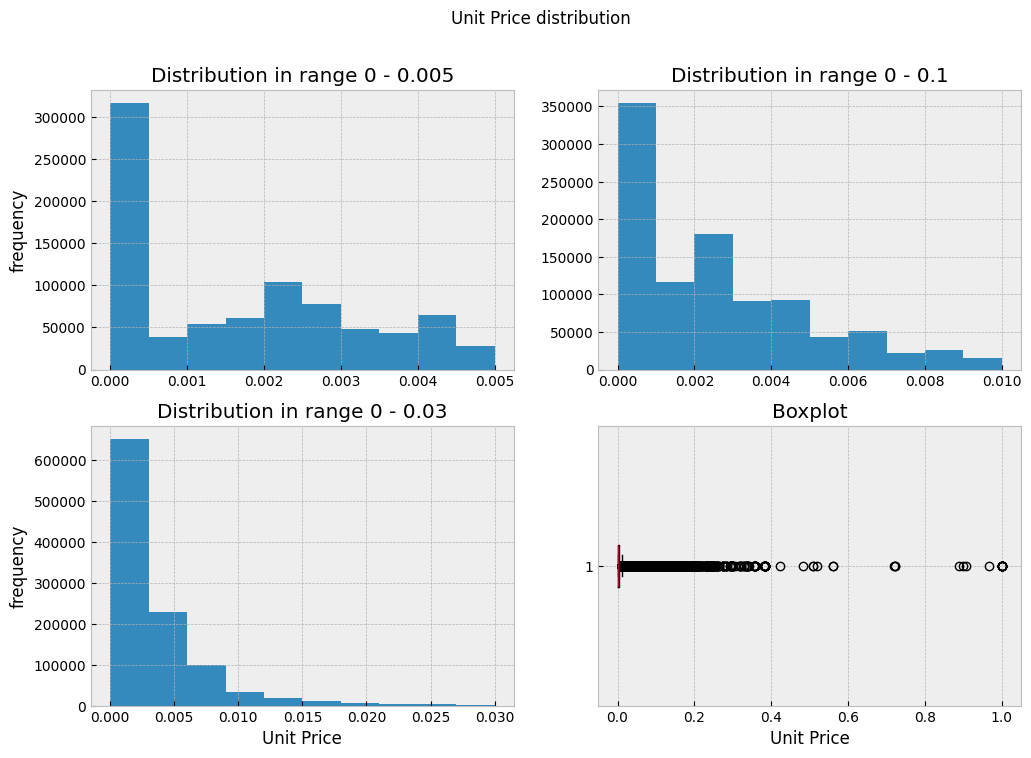

In [118]:
plt.figure(figsize=(12, 8))
plt.suptitle('Unit Price distribution')

plt.subplot(221)
plt.title('Distribution in range 0 - 0.005')
products_sg.unit_price.hist(range=(0, 0.005))
plt.ylabel('frequency')

plt.subplot(222)
plt.title('Distribution in range 0 - 0.1')
products_sg.unit_price.hist(range=(0, 0.01))

plt.subplot(223)
plt.title('Distribution in range 0 - 0.03')
plt.ylabel('frequency')
plt.xlabel('Unit Price')
products_sg.unit_price.hist(range=(0, 0.03))

plt.subplot(224)
plt.title('Boxplot')
plt.xlabel('Unit Price')
plt.boxplot(products_sg['unit_price'], vert=False)

plt.show()

>Так как цена не будет спользоваться в дальшейшей модели коллаборативной фильтрации, то не будем удалять из датасета продуктов нулевые цены и из датасета заказов заказы с продуктами с нулевой ценой.

In [119]:
# products_sg.loc[products_sg.unit_price == 0. 'to_drop'] = 1
# products_sg = products_sg[products_sg.unit_price != 0]

Однако выбросы справа необходимо отрезать. Построим еще один более крупный боксплот, чтобы оценить границу.

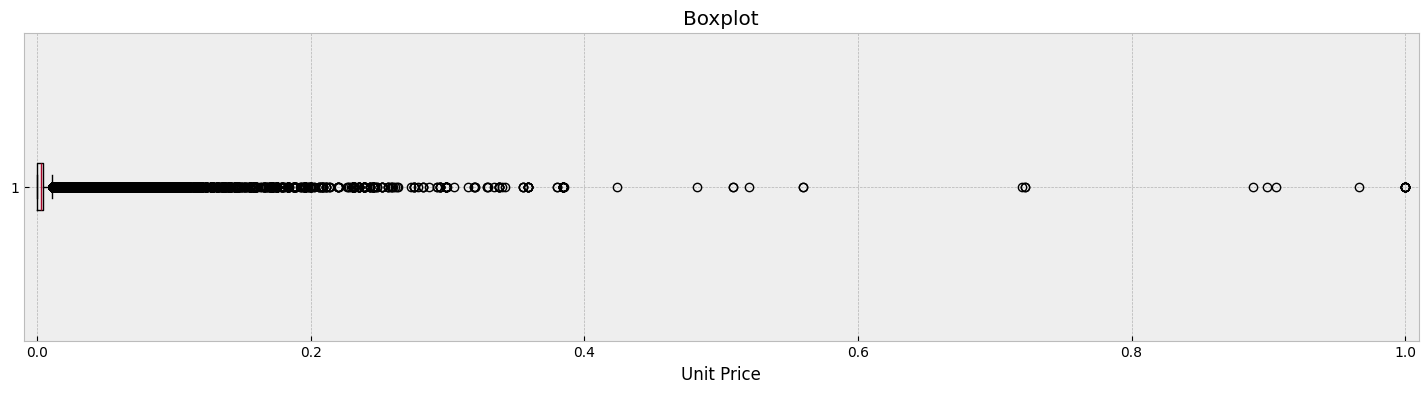

In [120]:
plt.figure(figsize=(18, 4))
plt.title('Boxplot')
plt.xlabel('Unit Price')
plt.boxplot(products_sg['unit_price'], vert=False)
plt.margins(x=0.01)
plt.show();

Спокойно можно обрезать по 0.3

In [121]:
f'{products_sg[products_sg.unit_price >= 0.3].shape[0] / products_sg.shape[0] * 100 :.5f} %'

'0.00619 %'

Обрезая диапазон до 30% мы отрезаем всего лишь шесть тясячных процента данных.

In [122]:
f'{products_sg[products_sg.unit_price >= 0.03].shape[0] / products_sg.shape[0] * 100 :.5f} %'

'0.90139 %'

Снизим порог цены до 0.03.

In [123]:
products_sg.loc[products_sg.unit_price > 0.03, 'to_drop'] = 1
# products_sg = products_sg[products_sg.unit_price <= 0.03]
display(products_sg['to_drop'].value_counts(dropna=False))
products_sg.shape

to_drop
0    1057601
1       9198
Name: count, dtype: int64

(1066799, 5)

##### Name

Особенности текстового поля с именем рассмотрим ниже

Почистим имена, удалим те, у которых имя состоит только из лищних символов, переведем иероглифы.

In [124]:
def translate(name, translators = [Translator(from_lang='zh', to_lang='en'), 
                                   Translator(from_lang='ja', to_lang='en'), 
                                   Translator(from_lang='vi', to_lang='en')]):
    c = 0
    name_translated = name
    while (name_translated == name) and (c <= len(translators)):
        for translator in translators:
            name_translated = translator.translate(name)
            c += 1
    return name_translated

In [125]:
def clean_names(name):
    import re
    # col = []
    name_done = ''
    name_cl =  re.sub(r'\b(\w+)( \1\b)+', r'\1',  # повторяющиеся слова
                        re.sub('\d+', '',  # цифры
                             re.sub(r'[^\w\s]', '', 
                                    str(name).lower())  # пунктуация
                            )
                     )
    for word in name_cl.split(' '):
        word_cl = re.sub(' +', ' ',  # лишние пробелы
                         re.sub(r'^([a-z])\1+$', r'', word)  # слова из повторяющихся букв
                        )
        name_done = ' '.join([name_done.strip(), word_cl])
                                        
    return name_done.strip()

In [126]:
products_sg['name_clean'] = products_sg['name'].parallel_apply(clean_names)

In [131]:
# еще можно перевести иероглифы
# пока удалим их
# products_sg['name_clean_tr'] = products_sg['name_clean'].parallel_apply(lambda x: Translator(from_lang="zh", to_lang='en').Translate(x))

In [132]:
def drop_non_latin(name):
    import re
    return re.sub('[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', '', name)

In [133]:
products_sg['name_clean'] = products_sg['name_clean'].parallel_apply(drop_non_latin)

Помечаем на удаление пустые названия

In [134]:
print(products_sg[products_sg['name_clean'] == ''].shape[0],
      products_sg[products_sg['name_clean'].isna()].shape[0])

2149 0


In [135]:
products_sg.loc[products_sg['name_clean'] == '', 'to_drop'] = 1
products_sg.to_drop.value_counts(dropna=False)

to_drop
0    1055460
1      11339
Name: count, dtype: int64

In [136]:
# на будущее можно более тщательно проверить содержание названий и их длину чтобы вычистить не имеющие смысла
products_sg[products_sg['name_clean'] == products_sg['name']]

vendor_id    product_id         name  unit_price  to_drop   name_clean
17342    c533dfee  8bb4cf6ba1f6         rice      0.0024        0         rice
43297    d75f970e  f275cf62870c  extra large      0.0032        0  extra large
89121    71fdd83c  51db649b8268         test      0.0000        0         test
93813    fc43244e  b75cc735f99c    xyz pizza      0.0044        0    xyz pizza
97324    1f53ed32  83d94af32848      bbfdbdf      0.4820        1      bbfdbdf
...           ...           ...          ...         ...      ...          ...
1030999  0af3f58d  72d0b6f479d9          dva      0.0016        0          dva
1035093  29fddb65  52cf4704484e       kahula      0.0032        0       kahula
1038234  d9c49265  e3c6784c894b         acvz      0.0012        0         acvz
1049239  677e35fc  575c5b8dbb8a        large      0.0012        0        large
1064087  cddcc8f9  589c66c0d365       ghfgju      0.0020        0       ghfgju

[518 rows x 6 columns]

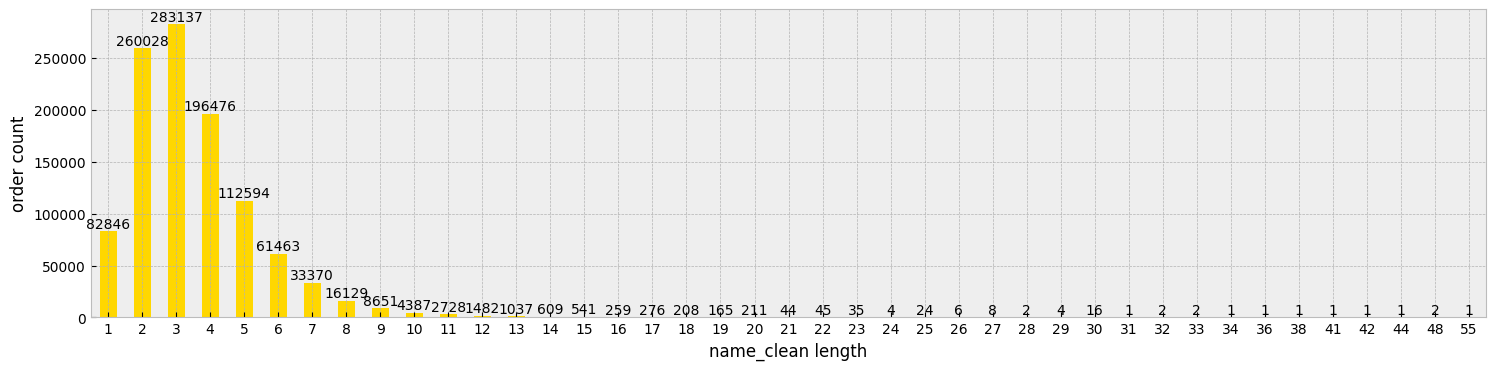

In [139]:
plot_bar_dist(products_sg['name_clean'].apply(lambda x: len(x.split(' '))), 0, 'gold', 'name_clean length', plot_counts=True)

In [140]:
products_sg[products_sg['name_clean'].apply(lambda x: len(x.split(' '))) == 20]

vendor_id    product_id  \
2002     c78d2937  f8b4ca3ce368   
2650     e4ea41e5  cb058f8a2ac7   
5130     1e79d2ac  3f79890f6ea3   
7528     c56e9af4  875dfe5e2794   
10682    5359f164  b14f19625c86   
...           ...           ...   
947681   595c99a8  c796ff398c17   
958405   9b9d3707  dcc2c5ada322   
987494   46ea2f3f  a8f5ff4916ba   
1002202  c18e8aff  e6638ac39dcb   
1056376  5dc3ab29  d256fb92677d   

                                                      name  unit_price  \
2002     Ultimate March Buddy Meal: 1 Nasi Lemak with C...      0.0064   
2650     Ultimate March Buddy Meal: 1 Nasi Lemak with C...      0.0064   
5130     Set 4: 1 X Curry Chicken + 1 X Mee Rebus + 2 X...      0.0112   
7528     Set 4: 1 X Curry Chicken + 1 X Mee Rebus + 2 X...      0.0112   
10682    Set 4: 1 X Curry Chicken + 1 X Mee Rebus + 2 X...      0.0112   
...                                                    ...         ...   
947681   Set 4: 1 X Curry Chicken + 1 X Mee Rebus + 2 X...      0.0112   
958405   D3. Salted Egg Sotong w/ Taiwanese Wine Eggpla...      0.0120   
987494   Avocado On Toast (Vegetarian. Sliced avocado s...      0.0000   
1002202  Each Voucher Code Can only be Used Once, Our S...      0.0000   
1056376  Box Of Six (6) Taiwanese Mooncake Red Bean Pas...      0.0028   

         to_drop                                         name_clean  
2002           0  ultimate march buddy meal nasi lemak with chic...  
2650           0  ultimate march buddy meal nasi lemak with chic...  
5130           0  set x curry chicken x mee rebus x curry puff x...  
7528           0  set x curry chicken x mee rebus x curry puff x...  
10682          0  set x curry chicken x mee rebus x curry puff x...  
...          ...                                                ...  
947681         0  set x curry chicken x mee rebus x curry puff x...  
958405         0  d salted egg sotong w taiwanese wine eggplant ...  
987494         0  avocado on toast vegetarian sliced avocado ser...  
1002202        0  each voucher code can only be used once our sy...  
1056376        0  box of six taiwanese mooncake red bean paste w...  

[211 rows x 6 columns]

При дальнейшей токенизации и нлп обработке имен необходимо укоротить названия. **Хорошо поможет удаление всего что находилось в скобках перед очисткой от пуктуации.** Сейчас сделаем это для красоты выведения в рекомендациях.

In [141]:
products_sg['name_clean'].loc[157160]

'original tonkotsu ramen suparakkis tonkotsu ramen uses a unique blend of pork bones to create a tonkotsu soup stock that has a smooth texture strong flavour white creamy color flavoured with a blend of japanese shoyu sea salt kelp suparakkis secret blend of flavoured oils its no surprise that original ramen is our best seller'

Обрежем существующие названия до 8 слов

In [142]:
products_sg['name_clean_cut'] = np.NaN
products_sg.loc[products_sg['name_clean'].apply(lambda x: len(x.split(' '))) > 8, 'name_clean_cut'] = products_sg['name_clean'].apply(
    lambda x: ' '.join(x.split(' ')[:8]))

C:\Users\User\AppData\Local\Temp\ipykernel_16264\3774203429.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['crispfried tofu in truffle sauce with truffle pearl'
 'family meal x sp mcnug pc sp hm'
 'sauteed beef cube with shishito peppers in black' ...
 'lo han mixed vegetable braised noddles hor fun'
 'chicken wing otah ikan bilis egg nasi lemak'
 'refreshing lemon grass jelly with longan kiwi seeds']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  products_sg.loc[products_sg['name_clean'].apply(lambda x: len(x.split(' '))) > 8, 'name_clean_cut'] = products_sg['name_clean'].apply(


In [143]:
products_sg['name_clean_cut'] = products_sg['name_clean_cut'].fillna(products_sg['name_clean'])

In [144]:
products_sg[['name', 'name_clean', 'name_clean_cut']].isna().sum()

name              0
name_clean        0
name_clean_cut    0
dtype: int64

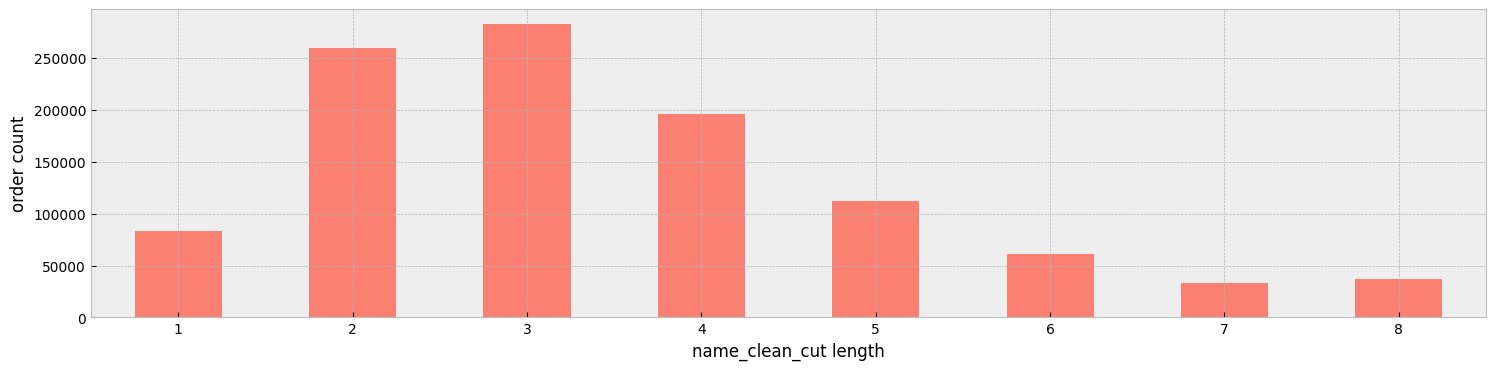

In [145]:
plot_bar_dist(products_sg['name_clean_cut'].apply(lambda x: len(x.split(' '))), 0, 'salmon', 'name_clean_cut length')

##### Merge Check

Склеим датасеты, чтобы увидеть более полную картину дублей и соотношения набора продуктов и продуктов в заказах

In [146]:
%%time
merged = orders_sg.merge(products_sg, on=['product_id', 'vendor_id'], how='left')

CPU times: total: 5.88 s
Wall time: 5.95 s


In [147]:
merged.shape

(4023005, 18)

In [148]:
merged.isna().sum()

customer_id        0
geohash            0
order_id           0
vendor_id          0
product_id         0
day_of_week        0
order_time         0
order_day          0
order_day_int      0
geohash_shrunk     0
neighbours         0
order_hour         0
day_part           0
name              49
unit_price        49
to_drop           49
name_clean        49
name_clean_cut    49
dtype: int64

Видим что 49 продуктов по паре айди и вендора не присутствуют в заказах.

In [149]:
merged[merged.unit_price.isna()].vendor_id.unique()

array(['a06f1cbf'], dtype=object)

In [150]:
merged[merged.unit_price.isna()].product_id.unique()

array(['1cc4fc0888d2', '5639066e786a', 'e65f47a39650', '6acee6cf16ca',
       '3cfc6048b8eb', '06f435509b10'], dtype=object)

In [151]:
products_sg[products_sg.product_id.isin(merged[merged.unit_price.isna()].product_id)]

vendor_id    product_id                                          name  \
213384  4cf81fe1  6acee6cf16ca  I16. Mixed Ingredients Crispy Noodles 什锦滑蛋生面   
258777  4cf81fe1  3cfc6048b8eb                        I15. Mee Goreng 海鲜马来炒面   
294543  4cf81fe1  e65f47a39650                   I13. KL Dai Lok Mee K L 大碌面   
306263  4cf81fe1  5639066e786a                 I14. KL White Loh Mee K L 白卤面   
431639  4cf81fe1  1cc4fc0888d2              I17. Salted Fish Fried Rice 咸鱼炒饭   
444594  4cf81fe1  06f435509b10                    I18. Fried Dry Hor Fun 干炒河   

        unit_price  to_drop                           name_clean  \
213384      0.0024        0  i mixed ingredients crispy noodles    
258777      0.0024        0                        i mee goreng    
294543      0.0028        0                i kl dai lok mee k l    
306263      0.0028        0              i kl white loh mee k l    
431639      0.0024        0            i salted fish fried rice    
444594      0.0024        0                 i fried dry hor fun    

                             name_clean_cut  
213384  i mixed ingredients crispy noodles   
258777                        i mee goreng   
294543                i kl dai lok mee k l   
306263              i kl white loh mee k l   
431639            i salted fish fried rice   
444594                 i fried dry hor fun

In [152]:
products_sg[products_sg.vendor_id.isin(merged[merged.unit_price.isna()].vendor_id) \
            & products_sg.product_id.isin(merged[merged.unit_price.isna()].product_id)]

Empty DataFrame
Columns: [vendor_id, product_id, name, unit_price, to_drop, name_clean, name_clean_cut]
Index: []

Видим, что с продуктами в целом нет ничего подозрительного, просто датасет продуктов сожержит большее количество продуктов чем продавалось в рассматриваемый период, однако важно заметить что продукты '1cc4fc0888d2', '5639066e786a', 'e65f47a39650', '6acee6cf16ca', '3cfc6048b8eb', '06f435509b10' продаваемые вендором 'a06f1cbf' есть в датасете продаж, но их нет в датасете продуктов

In [153]:
# здесь у всех без сэмпла вендор a06f1cbf
merged[merged.name.isna()].sample(10)

customer_id geohash  order_id vendor_id    product_id  day_of_week  \
165193   b287a31618   w21zv     80911  a06f1cbf  6acee6cf16ca            0   
2603192  f63289b389   w21zt   1289524  a06f1cbf  6acee6cf16ca            1   
1660729  cb662ac16d   w21zt    809267  a06f1cbf  6acee6cf16ca            6   
1256675  49f768a5c8   w21zt    612810  a06f1cbf  1cc4fc0888d2            5   
2157977  f660fa84b0   w21zt   1061165  a06f1cbf  e65f47a39650            6   
1969735  ffef7e3ee2   w21zt    965247  a06f1cbf  1cc4fc0888d2            4   
3765539  3aac7e0ac4   w21zt   1874564  a06f1cbf  6acee6cf16ca            6   
313142   bd8f89ca53   w21zt    152159  a06f1cbf  3cfc6048b8eb            5   
488193   2c1a7f957b   w21zt    237745  a06f1cbf  e65f47a39650            6   
27540    f869fc7f2d   w21zt     13407  a06f1cbf  1cc4fc0888d2            1   

        order_time order_day  order_day_int geohash_shrunk      neighbours  \
165193    11:55:23    8 days              8          w21zz              []   
2603192   18:38:43    2 days              2          w21zx  [w21z5, w23bh]   
1660729   19:43:59    7 days              7          w21zx  [w21z5, w23bh]   
1256675   17:55:59   55 days             55          w21zx  [w21z5, w23bh]   
2157977   17:27:12   77 days             77          w21zx  [w21z5, w23bh]   
1969735   19:47:23   33 days             33          w21zx  [w21z5, w23bh]   
3765539   17:35:27   77 days             77          w21zx  [w21z5, w23bh]   
313142    18:14:04   41 days             41          w21zx  [w21z5, w23bh]   
488193    19:34:53    7 days              7          w21zx  [w21z5, w23bh]   
27540     11:56:42   44 days             44          w21zx  [w21z5, w23bh]   

         order_hour day_part name  unit_price  to_drop name_clean  \
165193           11  morning  NaN         NaN      NaN        NaN   
2603192          18  evening  NaN         NaN      NaN        NaN   
1660729          19  evening  NaN         NaN      NaN        NaN   
1256675          17  evening  NaN         NaN      NaN        NaN   
2157977          17  evening  NaN         NaN      NaN        NaN   
1969735          19  evening  NaN         NaN      NaN        NaN   
3765539          17  evening  NaN         NaN      NaN        NaN   
313142           18  evening  NaN         NaN      NaN        NaN   
488193           19  evening  NaN         NaN      NaN        NaN   
27540            11  morning  NaN         NaN      NaN        NaN   

        name_clean_cut  
165193             NaN  
2603192            NaN  
1660729            NaN  
1256675            NaN  
2157977            NaN  
1969735            NaN  
3765539            NaN  
313142             NaN  
488193             NaN  
27540              NaN

In [154]:
orders_sg[orders_sg.vendor_id == 'a06f1cbf'].shape

(308, 13)

In [155]:
merged[(merged.vendor_id == 'a06f1cbf') & (merged.name.notna())].shape

(259, 18)

In [156]:
merged[(merged.product_id == '6acee6cf16ca')]

customer_id geohash  order_id vendor_id    product_id  day_of_week  \
165193   b287a31618   w21zv     80911  a06f1cbf  6acee6cf16ca            0   
313149   bd8f89ca53   w21zt    152160  a06f1cbf  6acee6cf16ca            1   
1660729  cb662ac16d   w21zt    809267  a06f1cbf  6acee6cf16ca            6   
2157976  f660fa84b0   w21zt   1061164  a06f1cbf  6acee6cf16ca            5   
2157978  f660fa84b0   w21zt   1061165  a06f1cbf  6acee6cf16ca            6   
2264510  08c68e7555   w21zt   1115540  a06f1cbf  6acee6cf16ca            1   
2573603  1c20106051   w21zt   1274572  a06f1cbf  6acee6cf16ca            0   
2603192  f63289b389   w21zt   1289524  a06f1cbf  6acee6cf16ca            1   
3765539  3aac7e0ac4   w21zt   1874564  a06f1cbf  6acee6cf16ca            6   

        order_time order_day  order_day_int geohash_shrunk      neighbours  \
165193    11:55:23    8 days              8          w21zz              []   
313149    18:04:00   23 days             23          w21zx  [w21z5, w23bh]   
1660729   19:43:59    7 days              7          w21zx  [w21z5, w23bh]   
2157976   18:59:37   41 days             41          w21zx  [w21z5, w23bh]   
2157978   17:27:12   77 days             77          w21zx  [w21z5, w23bh]   
2264510   19:44:09   44 days             44          w21zx  [w21z5, w23bh]   
2573603   19:19:12   15 days             15          w21zx  [w21z5, w23bh]   
2603192   18:38:43    2 days              2          w21zx  [w21z5, w23bh]   
3765539   17:35:27   77 days             77          w21zx  [w21z5, w23bh]   

         order_hour day_part name  unit_price  to_drop name_clean  \
165193           11  morning  NaN         NaN      NaN        NaN   
313149           18  evening  NaN         NaN      NaN        NaN   
1660729          19  evening  NaN         NaN      NaN        NaN   
2157976          18  evening  NaN         NaN      NaN        NaN   
2157978          17  evening  NaN         NaN      NaN        NaN   
2264510          19  evening  NaN         NaN      NaN        NaN   
2573603          19  evening  NaN         NaN      NaN        NaN   
2603192          18  evening  NaN         NaN      NaN        NaN   
3765539          17  evening  NaN         NaN      NaN        NaN   

        name_clean_cut  
165193             NaN  
313149             NaN  
1660729            NaN  
2157976            NaN  
2157978            NaN  
2264510            NaN  
2573603            NaN  
2603192            NaN  
3765539            NaN

Можно заметить, что указанные продукты имеются в датасете заказов, но с другим вендором, что приводит к выводу, что у продукта сменился вендор, а данные в датасете продуктов не обновили. Заменим в датасете взаимодействий вендора на актуального на момент заказа, чтобы не терять заказы.

In [157]:
products_sg[(products_sg.product_id.isin(merged[merged.name.isna()].product_id.unique()))]

vendor_id    product_id                                          name  \
213384  4cf81fe1  6acee6cf16ca  I16. Mixed Ingredients Crispy Noodles 什锦滑蛋生面   
258777  4cf81fe1  3cfc6048b8eb                        I15. Mee Goreng 海鲜马来炒面   
294543  4cf81fe1  e65f47a39650                   I13. KL Dai Lok Mee K L 大碌面   
306263  4cf81fe1  5639066e786a                 I14. KL White Loh Mee K L 白卤面   
431639  4cf81fe1  1cc4fc0888d2              I17. Salted Fish Fried Rice 咸鱼炒饭   
444594  4cf81fe1  06f435509b10                    I18. Fried Dry Hor Fun 干炒河   

        unit_price  to_drop                           name_clean  \
213384      0.0024        0  i mixed ingredients crispy noodles    
258777      0.0024        0                        i mee goreng    
294543      0.0028        0                i kl dai lok mee k l    
306263      0.0028        0              i kl white loh mee k l    
431639      0.0024        0            i salted fish fried rice    
444594      0.0024        0                 i fried dry hor fun    

                             name_clean_cut  
213384  i mixed ingredients crispy noodles   
258777                        i mee goreng   
294543                i kl dai lok mee k l   
306263              i kl white loh mee k l   
431639            i salted fish fried rice   
444594                 i fried dry hor fun

In [160]:
orders_sg[(orders_sg.product_id.isin(merged[merged.name.isna()].product_id.unique()))]

customer_id geohash  order_id vendor_id    product_id  day_of_week  \
27540    f869fc7f2d   w21zt     13407  a06f1cbf  1cc4fc0888d2            1   
116141   e1f82dd768   w21zt     57071  a06f1cbf  5639066e786a            5   
150003   6984879e0e   w21zt     73429  a06f1cbf  e65f47a39650            5   
165193   b287a31618   w21zv     80911  a06f1cbf  6acee6cf16ca            0   
263158   dd14d6efaf   w21zt    128010  a06f1cbf  e65f47a39650            6   
263159   dd14d6efaf   w21zt    128011  a06f1cbf  1cc4fc0888d2            4   
313142   bd8f89ca53   w21zt    152159  a06f1cbf  3cfc6048b8eb            5   
313149   bd8f89ca53   w21zt    152160  a06f1cbf  6acee6cf16ca            1   
313150   bd8f89ca53   w21zt    152161  a06f1cbf  06f435509b10            0   
488191   2c1a7f957b   w21zt    237745  a06f1cbf  06f435509b10            6   
488192   2c1a7f957b   w21zt    237745  a06f1cbf  1cc4fc0888d2            6   
488193   2c1a7f957b   w21zt    237745  a06f1cbf  e65f47a39650            6   
714640   d086b08557   w21zt    347894  a06f1cbf  06f435509b10            4   
715183   4b7e679d46   w21zt    348141  a06f1cbf  06f435509b10            0   
748552   99f855a7bb   w21zt    364449  a06f1cbf  e65f47a39650            5   
823332   5c66e109b8   w21zt    400902  a06f1cbf  e65f47a39650            6   
890555   bdbb07f511   w21zt    433668  a06f1cbf  1cc4fc0888d2            5   
1066221  1670b0302a   w21zt    520313  a06f1cbf  3cfc6048b8eb            2   
1247905  8ced41cb47   w21zt    608610  a06f1cbf  3cfc6048b8eb            0   
1256674  49f768a5c8   w21zt    612810  a06f1cbf  e65f47a39650            5   
1256675  49f768a5c8   w21zt    612810  a06f1cbf  1cc4fc0888d2            5   
1381893  6c24d2ce1a   w21zt    674160  a06f1cbf  e65f47a39650            2   
1660729  cb662ac16d   w21zt    809267  a06f1cbf  6acee6cf16ca            6   
1662358  bfbbec96ff   w21zt    810028  a06f1cbf  3cfc6048b8eb            6   
1708799  7ba89d987d   w21zv    832693  a06f1cbf  e65f47a39650            4   
1784125  0077b691ca   w21zv    870420  a06f1cbf  3cfc6048b8eb            5   
1869674  33347cc3f6   w21zt    914073  a06f1cbf  06f435509b10            2   
1945652  7f07f12e54   w21zt    952779  a06f1cbf  3cfc6048b8eb            0   
1969735  ffef7e3ee2   w21zt    965247  a06f1cbf  1cc4fc0888d2            4   
2049673  f77882917d   w21zt   1005983  a06f1cbf  06f435509b10            3   
2049674  f77882917d   w21zt   1005983  a06f1cbf  1cc4fc0888d2            3   
2099792  628a047344   w21zt   1031228  a06f1cbf  3cfc6048b8eb            3   
2157974  f660fa84b0   w21zt   1061164  a06f1cbf  e65f47a39650            5   
2157976  f660fa84b0   w21zt   1061164  a06f1cbf  6acee6cf16ca            5   
2157977  f660fa84b0   w21zt   1061165  a06f1cbf  e65f47a39650            6   
2157978  f660fa84b0   w21zt   1061165  a06f1cbf  6acee6cf16ca            6   
2264510  08c68e7555   w21zt   1115540  a06f1cbf  6acee6cf16ca            1   
2462860  31c4114e8d   w21zt   1217587  a06f1cbf  06f435509b10            2   
2553429  241fc45585   w21zt   1264176  a06f1cbf  1cc4fc0888d2            2   
2573603  1c20106051   w21zt   1274572  a06f1cbf  6acee6cf16ca            0   
2573605  1c20106051   w21zt   1274572  a06f1cbf  3cfc6048b8eb            0   
2603192  f63289b389   w21zt   1289524  a06f1cbf  6acee6cf16ca            1   
2813869  e4d5c263d8   w21zt   1397064  a06f1cbf  e65f47a39650            2   
3035888  8b3fefbe7f   w21zt   1510367  a06f1cbf  1cc4fc0888d2            3   
3340884  138e7cc377   w21zt   1665937  a06f1cbf  e65f47a39650            2   
3340886  138e7cc377   w21zt   1665937  a06f1cbf  1cc4fc0888d2            2   
3515570  c7c64bf146   w21zv   1752406  a06f1cbf  5639066e786a            5   
3765538  3aac7e0ac4   w21zt   1874564  a06f1cbf  3cfc6048b8eb            6   
3765539  3aac7e0ac4   w21zt   1874564  a06f1cbf  6acee6cf16ca            6   

        order_time order_day  order_day_int geohash_shrunk      neighbours  \
27540     11:56:42   44 days 

Видим что актуальный вендор  заказах - это a06f1cbf, чтобы не удалять продукты из заказов, приведем вендора в датасте продуктов к новому

In [166]:
# можно было предположить что у эти вендоры принадлежат к одной сети, но нет
vendors_sg[vendors_sg.vendor_id.isin(['a06f1cbf', '4cf81fe1'])]

vendor_id  chain_id geohash primary_cuisine
Unnamed: 0                                            
6988        4cf81fe1       nan   w21xr         chinese
7503        a06f1cbf  f24465fd   w21zt         chinese

In [167]:
# orders_sg.loc[(orders_sg.vendor_id == 'a06f1cbf') & 
              # (orders_sg.product_id.isin(merged[merged.name.isna()].product_id.unique())), 'vendor_id'] = '4cf81fe1'
products_sg.loc[(products_sg.vendor_id == '4cf81fe1') & 
          (products_sg.product_id.isin(merged[merged.name.isna()].product_id.unique())), 'vendor_id'] = 'a06f1cbf'

In [168]:
# перемердживаем измененные датасеты
merged = orders_sg.merge(products_sg, on=['product_id', 'vendor_id'], how='left')

In [169]:
merged.shape

(4023005, 18)

In [170]:
merged.isna().sum()

customer_id       0
geohash           0
order_id          0
vendor_id         0
product_id        0
day_of_week       0
order_time        0
order_day         0
order_day_int     0
geohash_shrunk    0
neighbours        0
order_hour        0
day_part          0
name              0
unit_price        0
to_drop           0
name_clean        0
name_clean_cut    0
dtype: int64

In [173]:
merged[['customer_id', 'geohash', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int',
       'geohash_shrunk', 'order_hour', 'day_part', 'name',
       'unit_price', 'to_drop', 'name_clean', 'name_clean_cut']].nunique()

customer_id        512916
geohash                45
order_id          2000000
vendor_id            7411
product_id         256502
day_of_week             7
order_time          82013
order_day              91
order_day_int          91
geohash_shrunk         11
order_hour             24
day_part                4
name                99591
unit_price            185
to_drop                 2
name_clean          85654
name_clean_cut      85572
dtype: int64

In [174]:
# чисто ради интереса посчитаем среднее количество заказов од одного покупателя за эти 90 дней
merged.order_id.nunique() / merged.customer_id.nunique()

3.899273955189544

#### Check Vendors DS

In [175]:
vendors_sg.vendor_id.nunique()

7411

In [176]:
products_sg.vendor_id.nunique()

7411

In [177]:
orders_sg.vendor_id.nunique()

7411

In [178]:
set(orders_sg.vendor_id) == set(vendors_sg.vendor_id) == set(products_sg.vendor_id)

True

Все вендоры из датасета вендоров представлены в заказах

In [179]:
vendors_sg

vendor_id  chain_id geohash primary_cuisine
Unnamed: 0                                            
0           b160c319  d2786168   w21z6         mexican
1           9c8f010e  d2786168   w21ze         mexican
4           03eb25e1  5055ab25   w21ze     bak kut teh
5           3613129a  8984acb6   w23b1         italian
7           0946c9e5  1e3a2913   w21z4     bak kut teh
...              ...       ...     ...             ...
17798       2d0b2dfb  1a3564c8   w21zt  mala xiang guo
17799       15bbf316  434020fb   w21zs  mala xiang guo
17801       a1f11221  b5431702   w21zu  mala xiang guo
17803       6268886c  0f494195   w21z8  mala xiang guo
17804       ca14a67e  0f494195   w23b6  mala xiang guo

[7411 rows x 4 columns]

In [180]:
vendors_sg.duplicated(['vendor_id']).sum()

0

In [181]:
vendors_sg.duplicated(['vendor_id', 'geohash']).sum()

0

Интересно, что означает хэш в датасете с вендорами?

In [182]:
print(len(set(vendors_sg.geohash)), len(set(orders_sg.geohash)))

31 45


In [183]:
len(set(vendors_sg.geohash) & set(orders_sg.geohash))

31

In [184]:
set(vendors_sg.geohash) - set(orders_sg.geohash)

set()

In [185]:
set(orders_sg.geohash) - set(vendors_sg.geohash) 

{'w21xj',
 'w21xm',
 'w21xn',
 'w21xp',
 'w21xq',
 'w21xw',
 'w21xz',
 'w21z1',
 'w21zq',
 'w21zr',
 'w21zx',
 'w21zz',
 'w238p',
 'w23b7'}

Множество геохэшей датасета вендоров является подмножеством множества геохэшей датасета продаж
Получается, если геохэш вендора означает местоположение вендора, то все вендоры находятся примерно в той же области, откуда происходят заказы.

In [186]:
vendors_sg[['geohash', 'vendor_id']].value_counts(dropna=False)

geohash  vendor_id
w21xr    4cf81fe1     1
w21zk    2b992a15     1
         29e1b765     1
         28f5bafd     1
         28a35710     1
                     ..
w21z7    ba373d26     1
         ba2329fa     1
         ba15b5c2     1
         b9de26c6     1
w23bh    fe4cf855     1
Name: count, Length: 7411, dtype: int64

In [187]:
orders_sg.geohash.nunique()

45

In [188]:
check = orders_sg[['vendor_id', 'geohash']].merge(vendors_sg[['vendor_id', 'geohash']], on='vendor_id', how='left')
check[check.geohash_x != check.geohash_y]

vendor_id geohash_x geohash_y
13       ee4f2ee0     w21z6     w21z7
14       ee4f2ee0     w21z6     w21z7
15       ee4f2ee0     w21z6     w21z7
16       ee4f2ee0     w21z6     w21z7
17       b62d39b7     w21z6     w21z3
...           ...       ...       ...
4023000  ff0edd9f     w21zt     w21zv
4023001  ff0edd9f     w21zt     w21zv
4023002  2bba6450     w21zt     w21zv
4023003  2bba6450     w21zt     w21zv
4023004  2bba6450     w21zt     w21zv

[1340274 rows x 3 columns]

Выше мы видим множество вендоров, товары которых доставлялись вне гексагона присутствия вендора.

~1. интересно что у каждого взаимодействия (заказа) есть только 1 вендор~
~2. для каждого вендора в заказах есть несколько разных геохэшей~

Какой же выбран геохэш для вендора в датасете вендоров - не ясно точно :( рандомный из датасета заказов?
Остановимся на том, что он имеет значение местонахождения вендора

##### Primary Cuisine

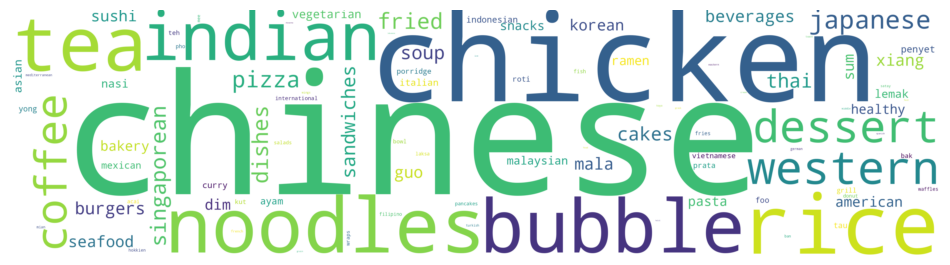

In [189]:
plot_wordcloud(vendors_sg['primary_cuisine'])

Самая популярная еда в сингапуре у данной доставки - китайска кухня, курица, макароны, рис, бабл ти. Можно рекомендовать исходя их кухни.

In [191]:
# тут еще доделать исследование вендоров - проверка сетей
# На основе разметки сетей можно проще сопоставлять вендоров и продукты вендоров. Предлагать на основе сети вендоровю.

#### Merged DS

Для более полного пониамния дубликатов соберем всю информацию из 3 датасетов воедино

In [192]:
merged2 = merged.merge(vendors_sg, how='left', on='vendor_id').rename(columns={'geohash_x': 'geohash_order', 'geohash_y': 'geohash_vendor'})
merged2.shape

(4023005, 21)

In [193]:
merged2.isna().sum()

customer_id        0
geohash_order      0
order_id           0
vendor_id          0
product_id         0
day_of_week        0
order_time         0
order_day          0
order_day_int      0
geohash_shrunk     0
neighbours         0
order_hour         0
day_part           0
name               0
unit_price         0
to_drop            0
name_clean         0
name_clean_cut     0
chain_id           0
geohash_vendor     0
primary_cuisine    0
dtype: int64

In [196]:
merged2[merged2.drop('neighbours', axis=1).duplicated(keep='first')].shape

(99521, 21)

In [197]:
merged2.columns

Index(['customer_id', 'geohash_order', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int',
       'geohash_shrunk', 'neighbours', 'order_hour', 'day_part', 'name',
       'unit_price', 'to_drop', 'name_clean', 'name_clean_cut', 'chain_id',
       'geohash_vendor', 'primary_cuisine'],
      dtype='object')

In [200]:
# % дублей в датасете заказов
f' % дублей в датасете заказов - {merged2[merged2.drop("neighbours", axis=1).duplicated()].shape[0] / merged2.shape[0] * 100 :.2f} %'

' % дублей в датасете заказов - 2.47 %'

In [202]:
merged2.drop('neighbours', axis=1).duplicated(keep=False).sum()

187377

In [203]:
merged2[['customer_id', 'geohash_order', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int', 'name',
       'primary_cuisine']].duplicated(keep=False).sum()

187377

Посмотрим на агрегацию дублей по количеству. Если максимальное количество не превышает разумное одинаковых количество товаров в корзине, то дропнем их

In [204]:
# dupl_products = pd.DataFrame(merged2[merged2.duplicated(keep=False)].groupby(['customer_id', 'geohash_order', 'order_id', 'vendor_id', 
#                  'product_id', 'day_of_week', 'order_time', 'order_day', 
#                  'order_day_int', 'name', 'unit_price', 'chain_id', 
#                  'geohash_vendor', 'primary_cuisine']).agg('size'))

.drop('neighbours', axis=1) - удалим временно фичу с соседями.

In [208]:
merged2 = merged2.drop('neighbours', axis=1)

In [209]:
%%time
dupl_interactions = (
              merged2[merged2.duplicated(keep=False)].groupby(merged2[merged2.duplicated(keep=False)].columns.tolist())
              .size()
              .reset_index()
              .rename(columns = {0: 'count'})
            )

CPU times: total: 20.4 s
Wall time: 20.7 s


In [210]:
dupl_interactions['count'].sum()

187377

In [211]:
dupl_interactions['count'].value_counts(dropna=False)

count
2     78557
3      7598
4      1292
5       269
6        78
7        37
8        12
9         8
11        3
13        1
15        1
Name: count, dtype: int64

Количество штук до 10 не вызывает вопросов совсем, больше 10 - посмотрим что это за товары

In [212]:
dupl_interactions[dupl_interactions['count'] > 10]

customer_id geohash_order  order_id vendor_id    product_id  \
6699   1387f1c488         w21z7   1498189  a36b7d7a  b31d6c9d1966   
32743  6013608afc         w21ze   1072442  020439a9  29a7bbfc44e0   
36493  6acf997ae3         w21zs    750996  7e2d81c2  caf014dd125c   
39754  74a787a7da         w21ze   1026590  020439a9  564c3583680c   
47229  8a56755689         w21z8   1087361  fb606a7d  74d4a9ac4768   

       day_of_week order_time order_day  order_day_int geohash_shrunk  ...  \
6699             2   18:42:37   80 days             80          w21z5  ...   
32743            1   13:43:04   37 days             37          w21z5  ...   
36493            6   16:44:01   21 days             21          w21z5  ...   
39754            1   14:41:21   37 days             37          w21z5  ...   
47229            5   20:05:37    6 days              6          w21xp  ...   

       day_part                  name unit_price  to_drop  \
6699    evening             Ala Carte     0.0032        0   
32743       day        Yakitori Stick     0.0000        0   
36493       day  Single Regular Scoop     0.0028        0   
39754       day      Customized Bento     0.0000        0   
47229   evening              Spicy 中辣     0.0000        0   

                 name_clean        name_clean_cut  chain_id geohash_vendor  \
6699              ala carte             ala carte  94fcafef          w21z7   
32743        yakitori stick        yakitori stick  dfdc19d5          w21z7   
36493  single regular scoop  single regular scoop  8b17f4e6          w21zs   
39754      customized bento      customized bento  dfdc19d5          w21z7   
47229                spicy                 spicy   b2264498          w21z8   

      primary_cuisine count  
6699          healthy    13  
32743        japanese    11  
36493         dessert    11  
39754        japanese    15  
47229  mala xiang guo    11  

[5 rows x 21 columns]

In [213]:
translator.translate("中辣")

'MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  09 HOURS 12 MINUTES 48 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE'

Это палочки и единичные скупы, Ala Carte тоже предполагает единичное блюдо - нормально, что их брали по многу штук. и что-то острое среднеострое :) В целом считаем, что можно сбросить дубли

In [214]:
# Сбросим полные дубли
merged2 = merged2.drop_duplicates()

In [215]:
merged2.shape

(3923484, 20)

Для проверки сравниваем с количествами уникальных значений сырых данных, убеждаемся, что ничего не потеряли

In [216]:
merged2.nunique()

customer_id         512916
geohash_order           45
order_id           2000000
vendor_id             7411
product_id          256502
day_of_week              7
order_time           82013
order_day               91
order_day_int           91
geohash_shrunk          11
order_hour              24
day_part                 4
name                 99591
unit_price             185
to_drop                  2
name_clean           85654
name_clean_cut       85572
chain_id              1855
geohash_vendor          31
primary_cuisine         78
dtype: int64

##### Drop other

In [ ]:
обрезать по дням 39 - 90
отрезать нули в цене продуктов

In [227]:
merged2['neighbours'] = merged2['geohash_shrunk'].map(neighbours_dict)

In [228]:
merged2.to_drop.value_counts(dropna=False)

to_drop
0    3918912
1       4572
Name: count, dtype: int64

In [229]:
merged2 = merged2[merged2.to_drop == 0]
merged2.shape

(3918912, 21)

In [231]:
merged2.drop('neighbours', axis=1).nunique()

customer_id         512544
geohash_order           45
order_id           1997886
vendor_id             7409
product_id          255601
day_of_week              7
order_time           82013
order_day               91
order_day_int           91
geohash_shrunk          11
order_hour              24
day_part                 4
name                 99121
unit_price              76
to_drop                  1
name_clean           85336
name_clean_cut       85254
chain_id              1855
geohash_vendor          31
primary_cuisine         78
dtype: int64

##### All Visual

In [232]:
# визуальный анализ взаимосвязей всех фич

In [233]:
merged2.columns

Index(['customer_id', 'geohash_order', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int',
       'geohash_shrunk', 'order_hour', 'day_part', 'name', 'unit_price',
       'to_drop', 'name_clean', 'name_clean_cut', 'chain_id', 'geohash_vendor',
       'primary_cuisine', 'neighbours'],
      dtype='object')

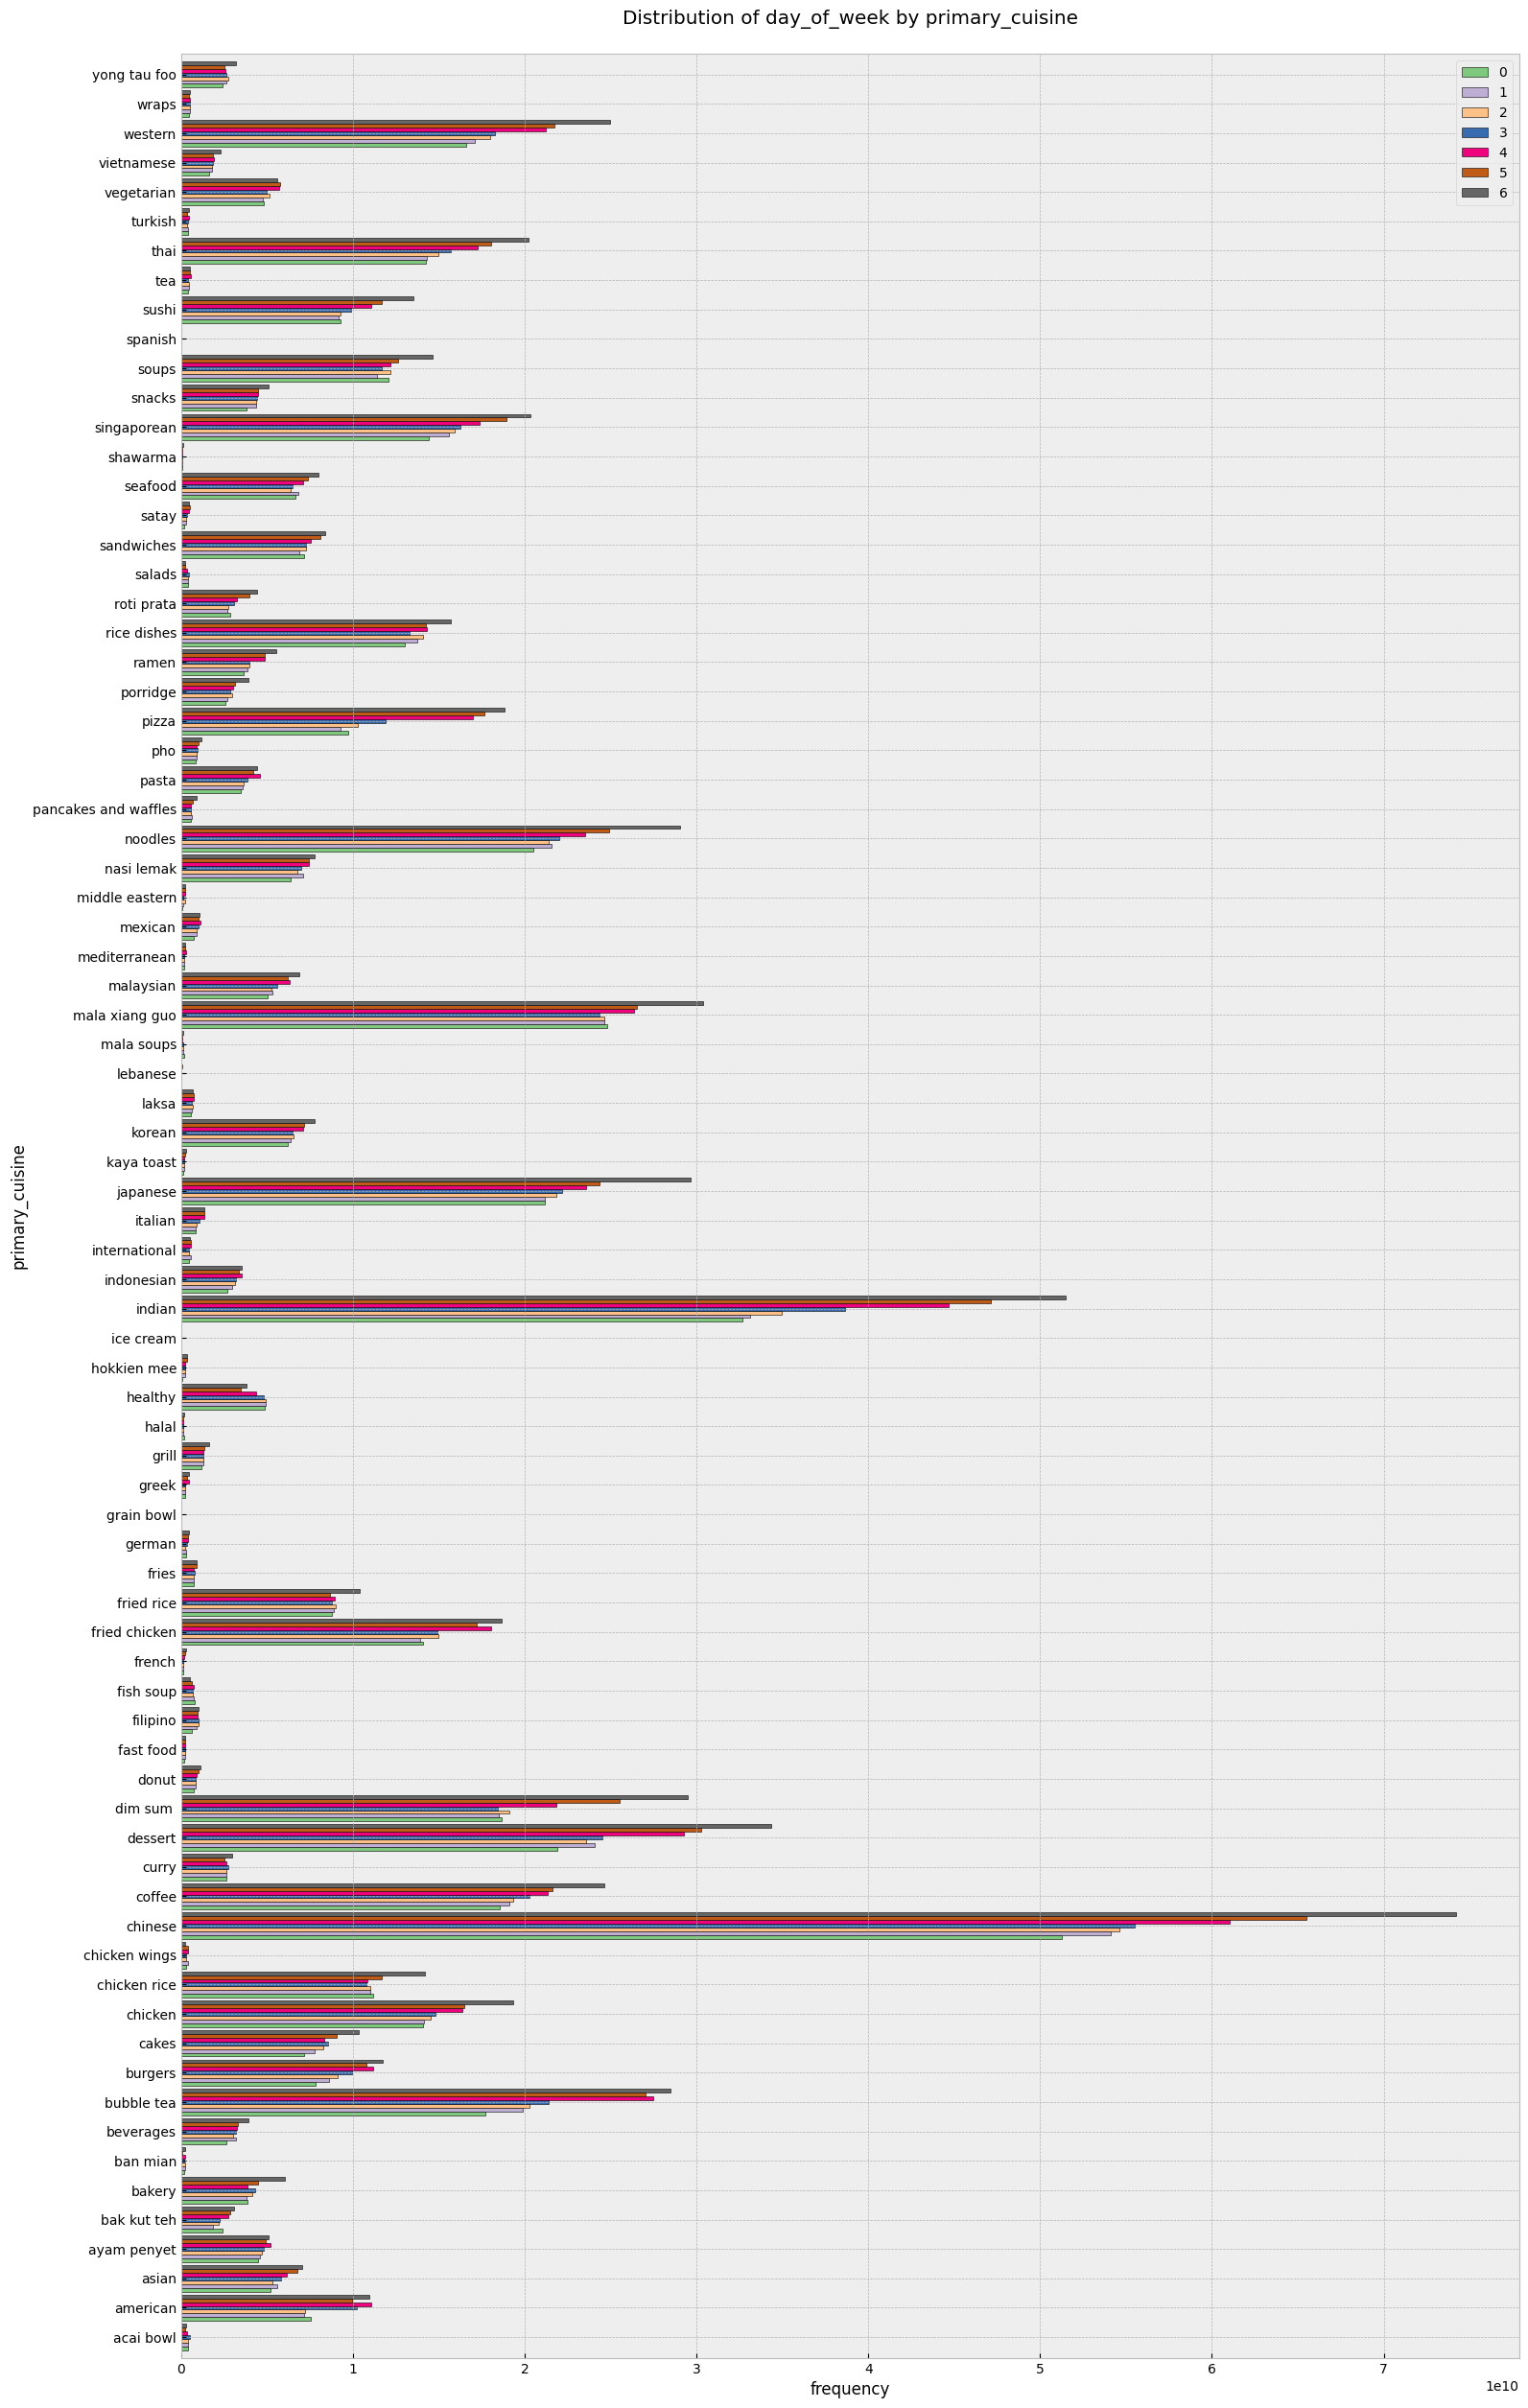

In [234]:
count_cross_plot(merged2, 'day_of_week', 'primary_cuisine', 'sum', 'Accent')

Пасту больше всего покупают по четвергам! А карри, куриные крыляшки, фастфуд и картошку фри и обычные напитки одинаково в течение недели. Интересно что единственная кухня которая нарушает тренд - здоровая, ее больше покупают на неделе. Можно использовать распределение кухонь по дням чтобы в определенные дни предлагать определенную кухню.

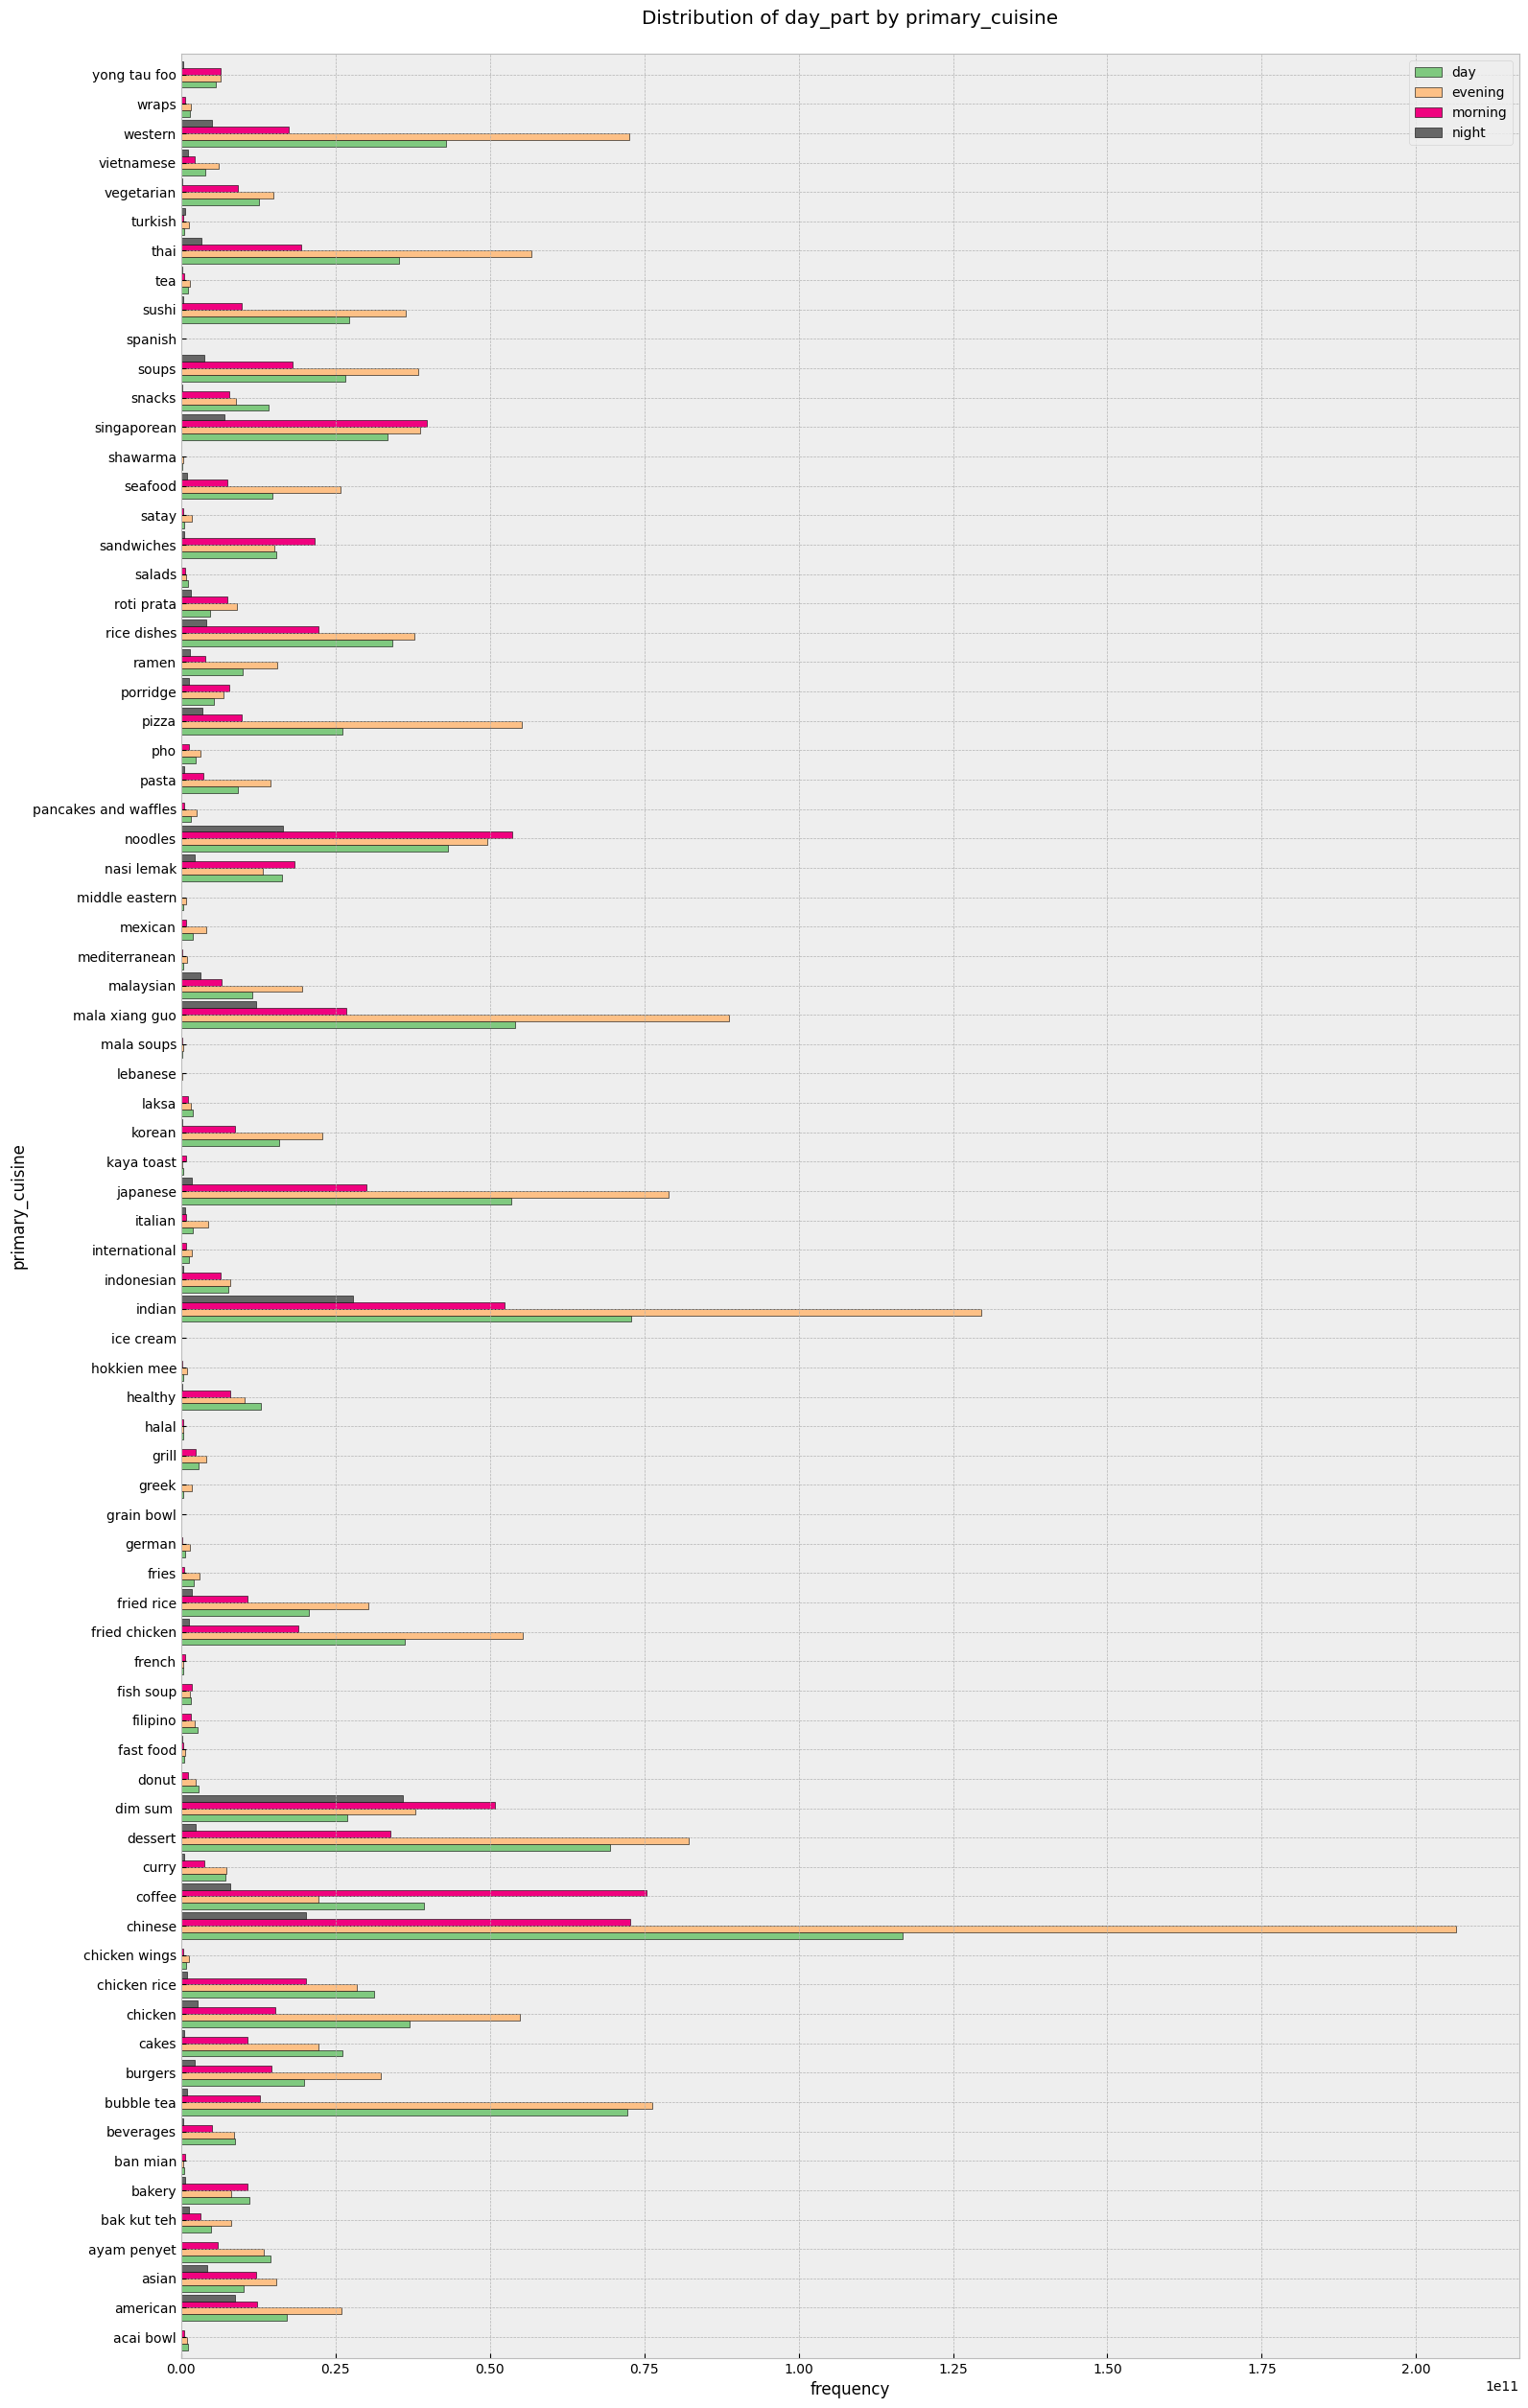

In [235]:
count_cross_plot(merged2, 'day_part', 'primary_cuisine', 'sum', 'Accent')

Логично видно что кофе больше всего покупают утром, а также на завтрак в сингапуре любят есть выпечку, dimsum, сэндвичи, сингапурскую кухню, заварную лапшу едят в любое время суток, на обед бабл ти и ayam penyet, а вот на ужин китайсую кухню.

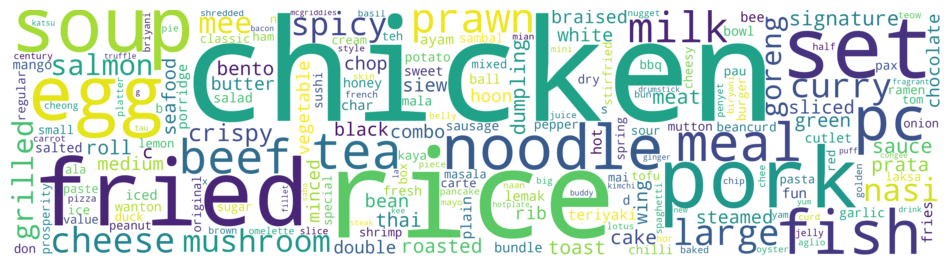

In [236]:
plot_wordcloud(merged2['name_clean_cut'])

Сагрегируем unit_price чтобы посмотреть распределение.

In [239]:
merged2['price_category'] = np.NaN
cheap_mask = (merged2.unit_price < 0.005)
medium_mask = (merged2.unit_price >= 0.005) & (merged2.unit_price < 0.015) 
high_mask = (merged2.unit_price >= 0.015)

merged2.loc[cheap_mask, 'price_category'] = 'cheap'
merged2.loc[medium_mask, 'price_category'] = 'normal'
merged2.loc[high_mask, 'price_category'] = 'expensive'
merged2.price_category.value_counts(dropna=False)

C:\Users\User\AppData\Local\Temp\ipykernel_16264\1963123244.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'cheap' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged2.loc[cheap_mask, 'price_category'] = 'cheap'


price_category
cheap        3211788
normal        668746
expensive      38378
Name: count, dtype: int64

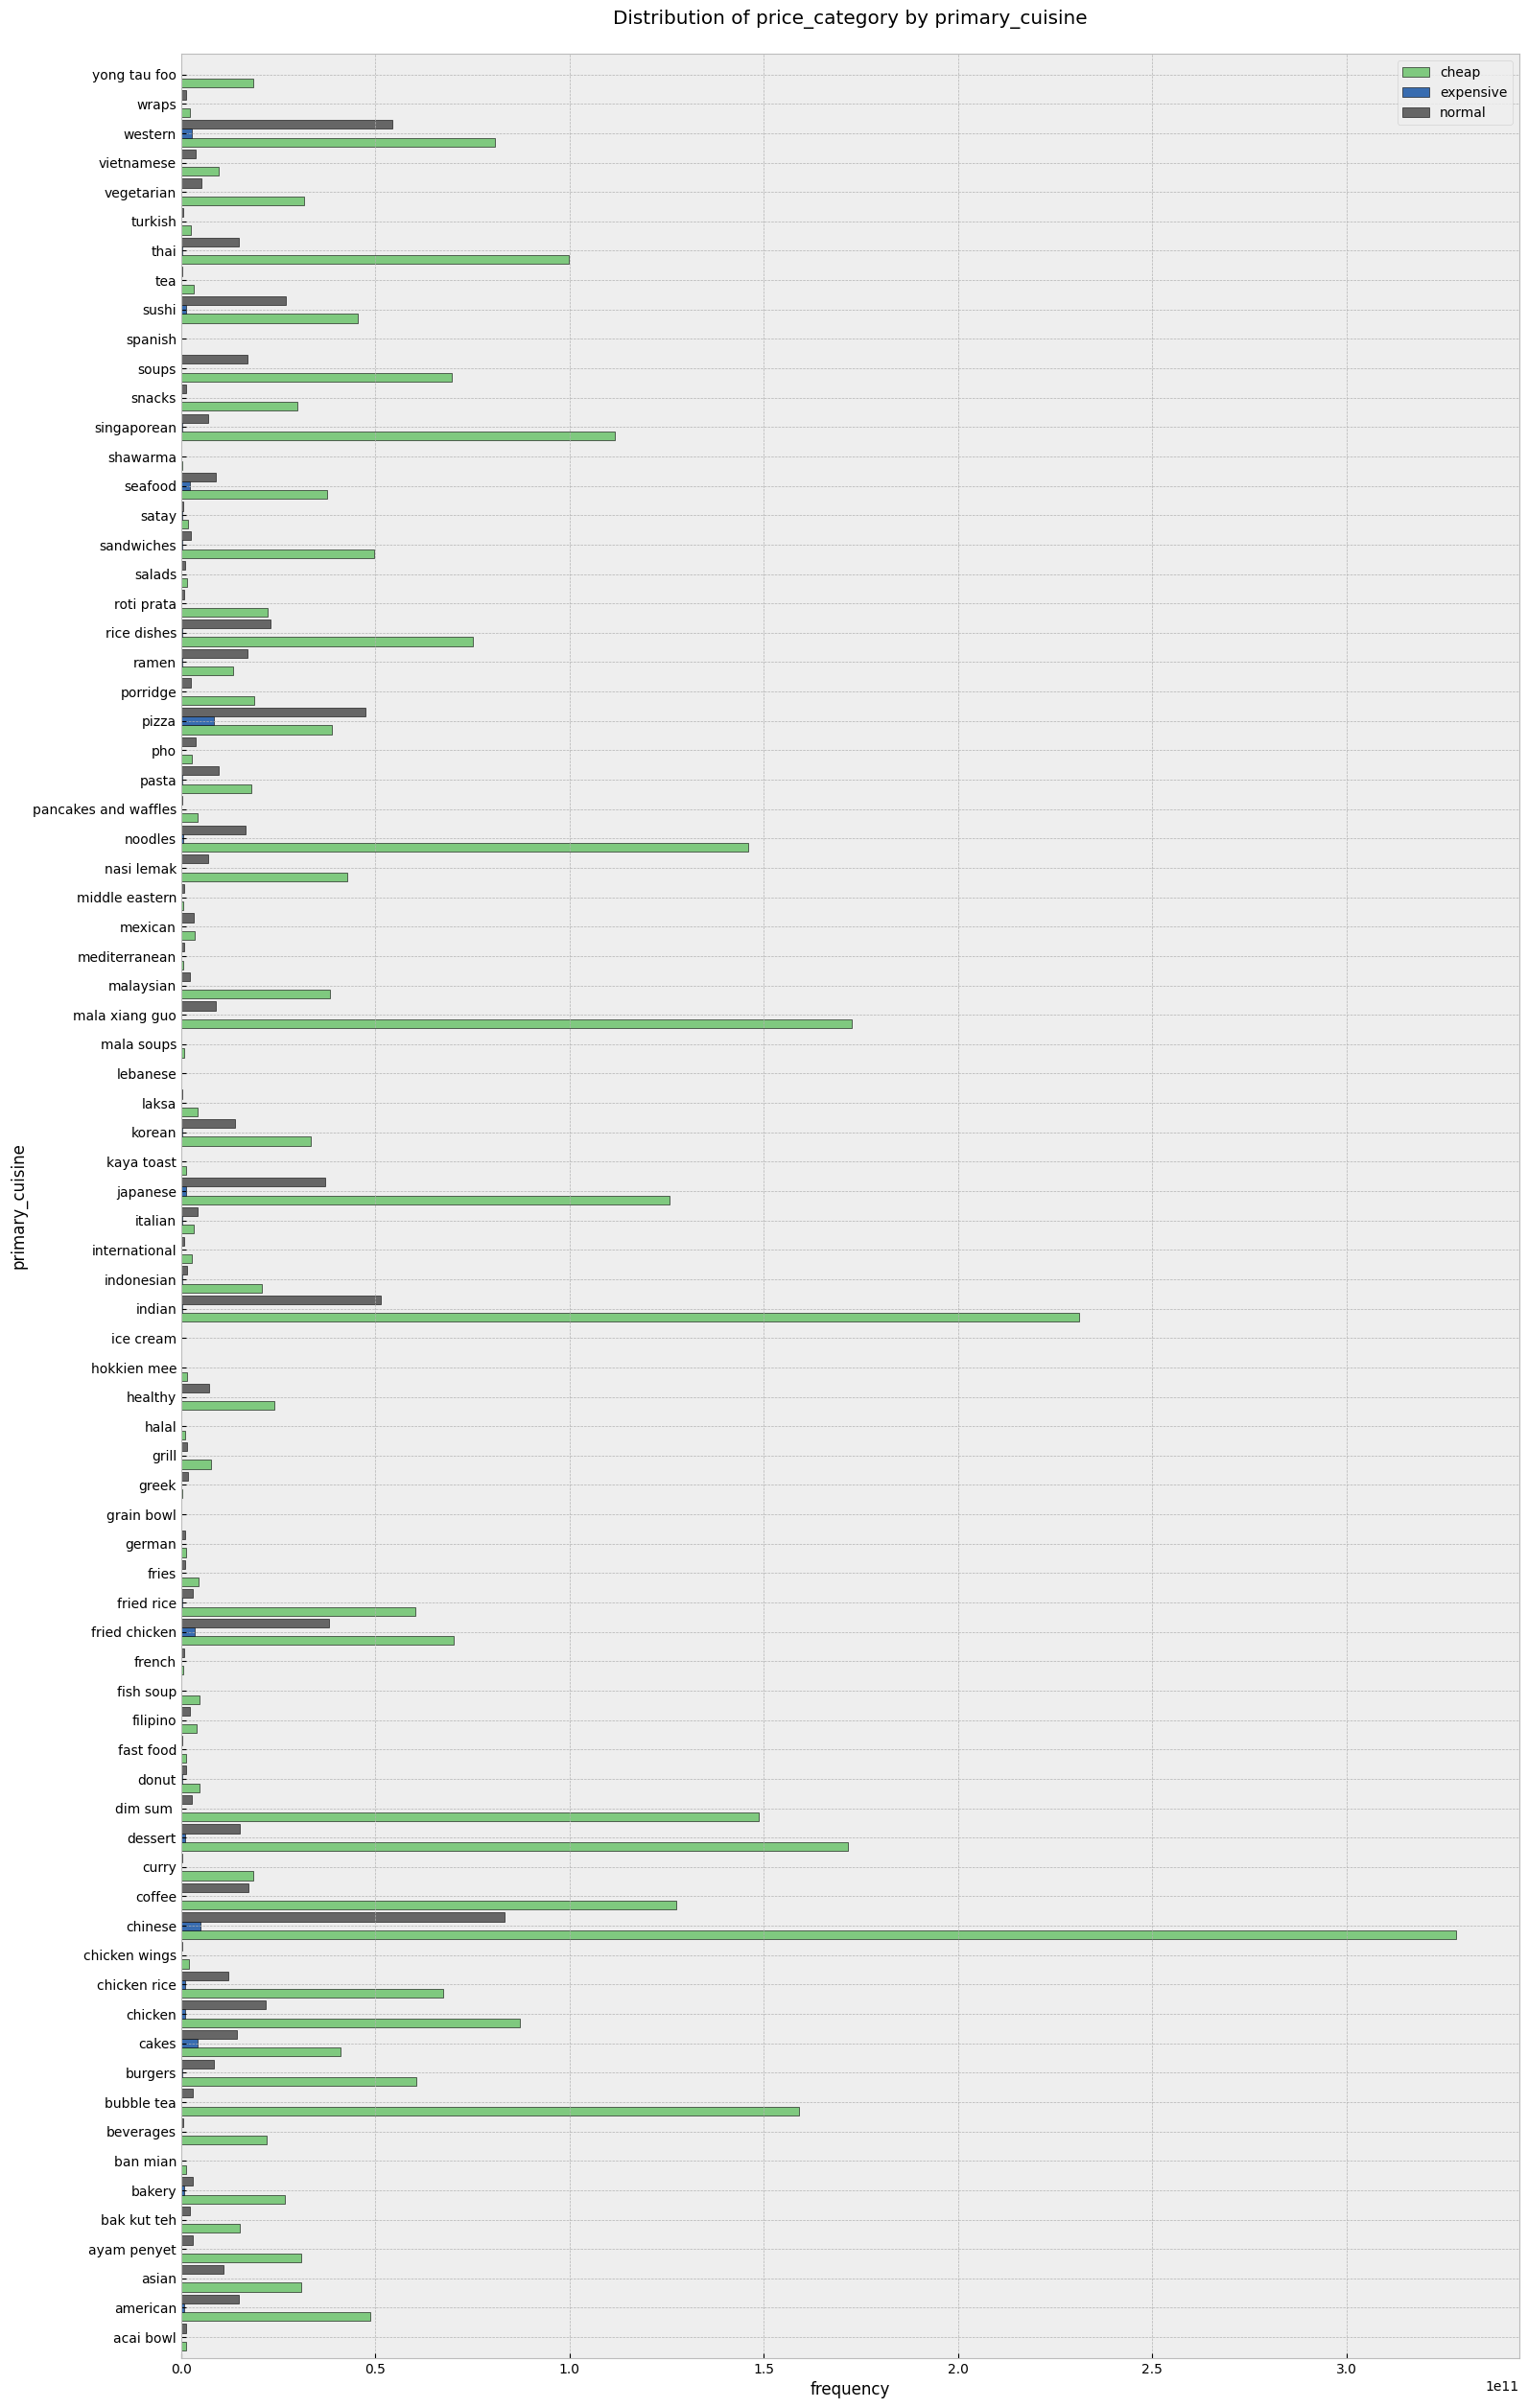

In [240]:
count_cross_plot(merged2, 'price_category', 'primary_cuisine', 'sum', 'Accent')

Самые дорогие - пицца, торты и западная кухня.

In [242]:
merged2.columns

Index(['customer_id', 'geohash_order', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int',
       'geohash_shrunk', 'order_hour', 'day_part', 'name', 'unit_price',
       'to_drop', 'name_clean', 'name_clean_cut', 'chain_id', 'geohash_vendor',
       'primary_cuisine', 'neighbours', 'price_category'],
      dtype='object')

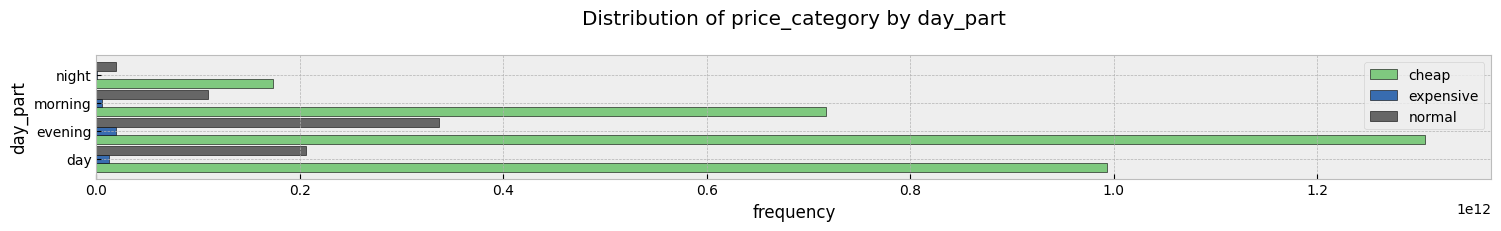

In [248]:
count_cross_plot(merged2, 'price_category', 'day_part', 'sum', 'Accent')

Нельзя сказать что дороговизна покупок как-то зависит от дня недели или дня внутри датасета.

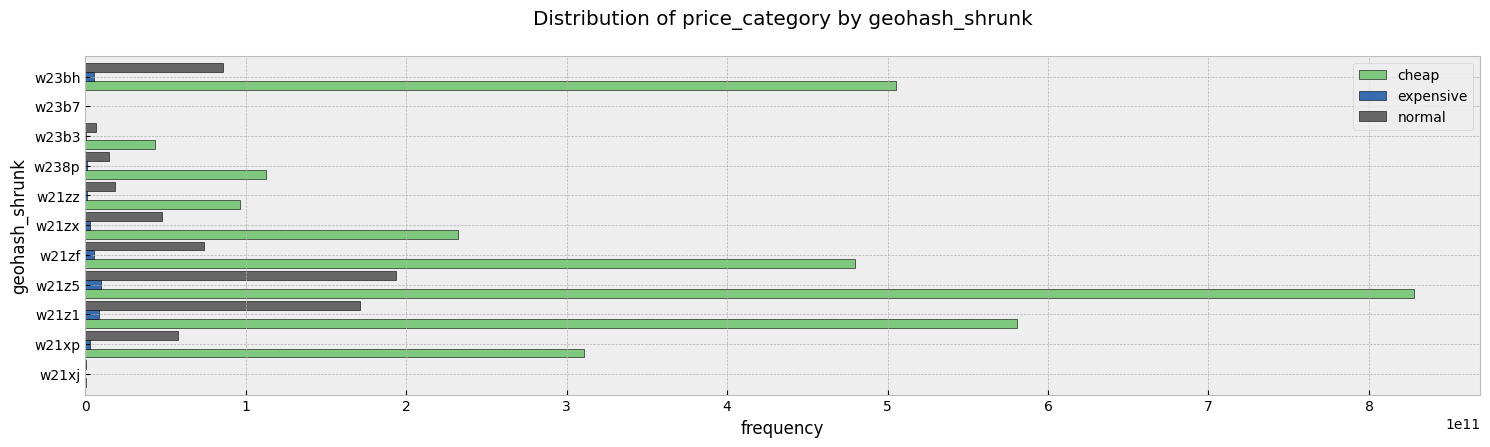

In [250]:
count_cross_plot(merged2, 'price_category', 'geohash_shrunk', 'sum', 'Accent')

Так же как и нет района в котором покупают больше дорогую или дешевую еду.

##### geohashes

Рассчитавем расстояние между вендором и заказчиком, такую фичу можно добавить в модель.

Расстояние рассчитывается как геометрические расстояние по прямой между центрами двух гексагонов (имеем их координаты).

In [251]:
def calc_geo_dist(hash1, hash2):
    lat1, lon1 = geohash2.decode(hash1)
    lat2, lon2 = geohash2.decode(hash2)
    lat1, lat2, lon1, lon2 = float(lat1), float(lat2), float(lon1), float(lon2)        
    return round(((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2) ** 0.5, 1)

# def calc_geo_dist():
#     lat1, lon1 = geohash2.decode(df['geohash_order'])
#     lat2, lon2 = geohash2.decode(df['geohash_vendor'])
#     lat1, lat2, lon1, lon2 = float(lat1), float(lat2), float(lon1), float(lon2)        
#     return round(((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2) ** 0.5, 1)

In [252]:
merged2['delivery_dist'] = merged2[['geohash_order', 'geohash_vendor']].progress_apply(lambda x: calc_geo_dist(x['geohash_order'], x['geohash_vendor']), axis=1)

  0%|          | 0/3918912 [00:00<?, ?it/s]

In [253]:
# plot_bar_dist(merged2['delivery_dist'], 0, 'violet', 'delivery_dist distribution')
merged2['delivery_dist'].value_counts()

delivery_dist
0.0    3201615
0.1     700167
0.2      14215
0.3       2915
Name: count, dtype: int64

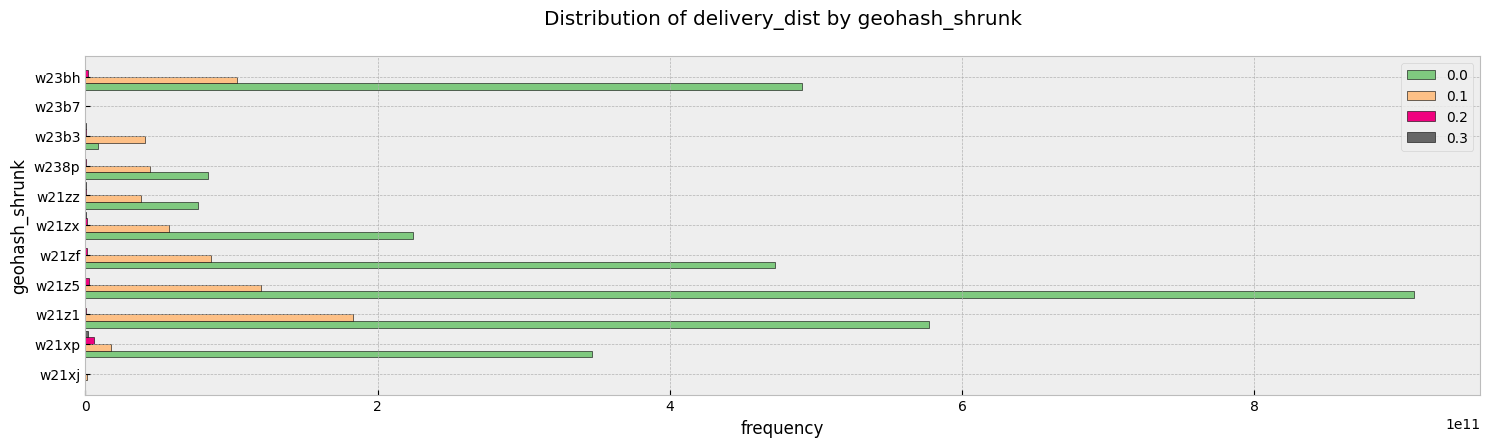

In [254]:
count_cross_plot(merged2, 'delivery_dist', 'geohash_shrunk', 'sum', 'Accent')

Дальше всего доставки ездят из w21xp.

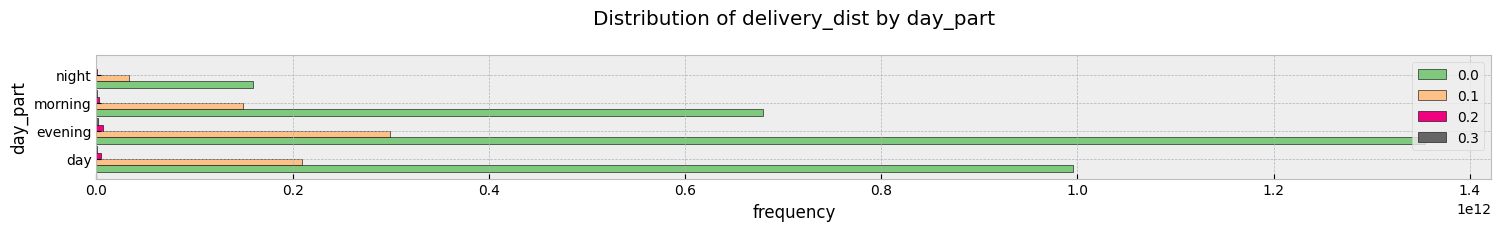

In [255]:
count_cross_plot(merged2, 'delivery_dist', 'day_part', 'sum', 'Accent')

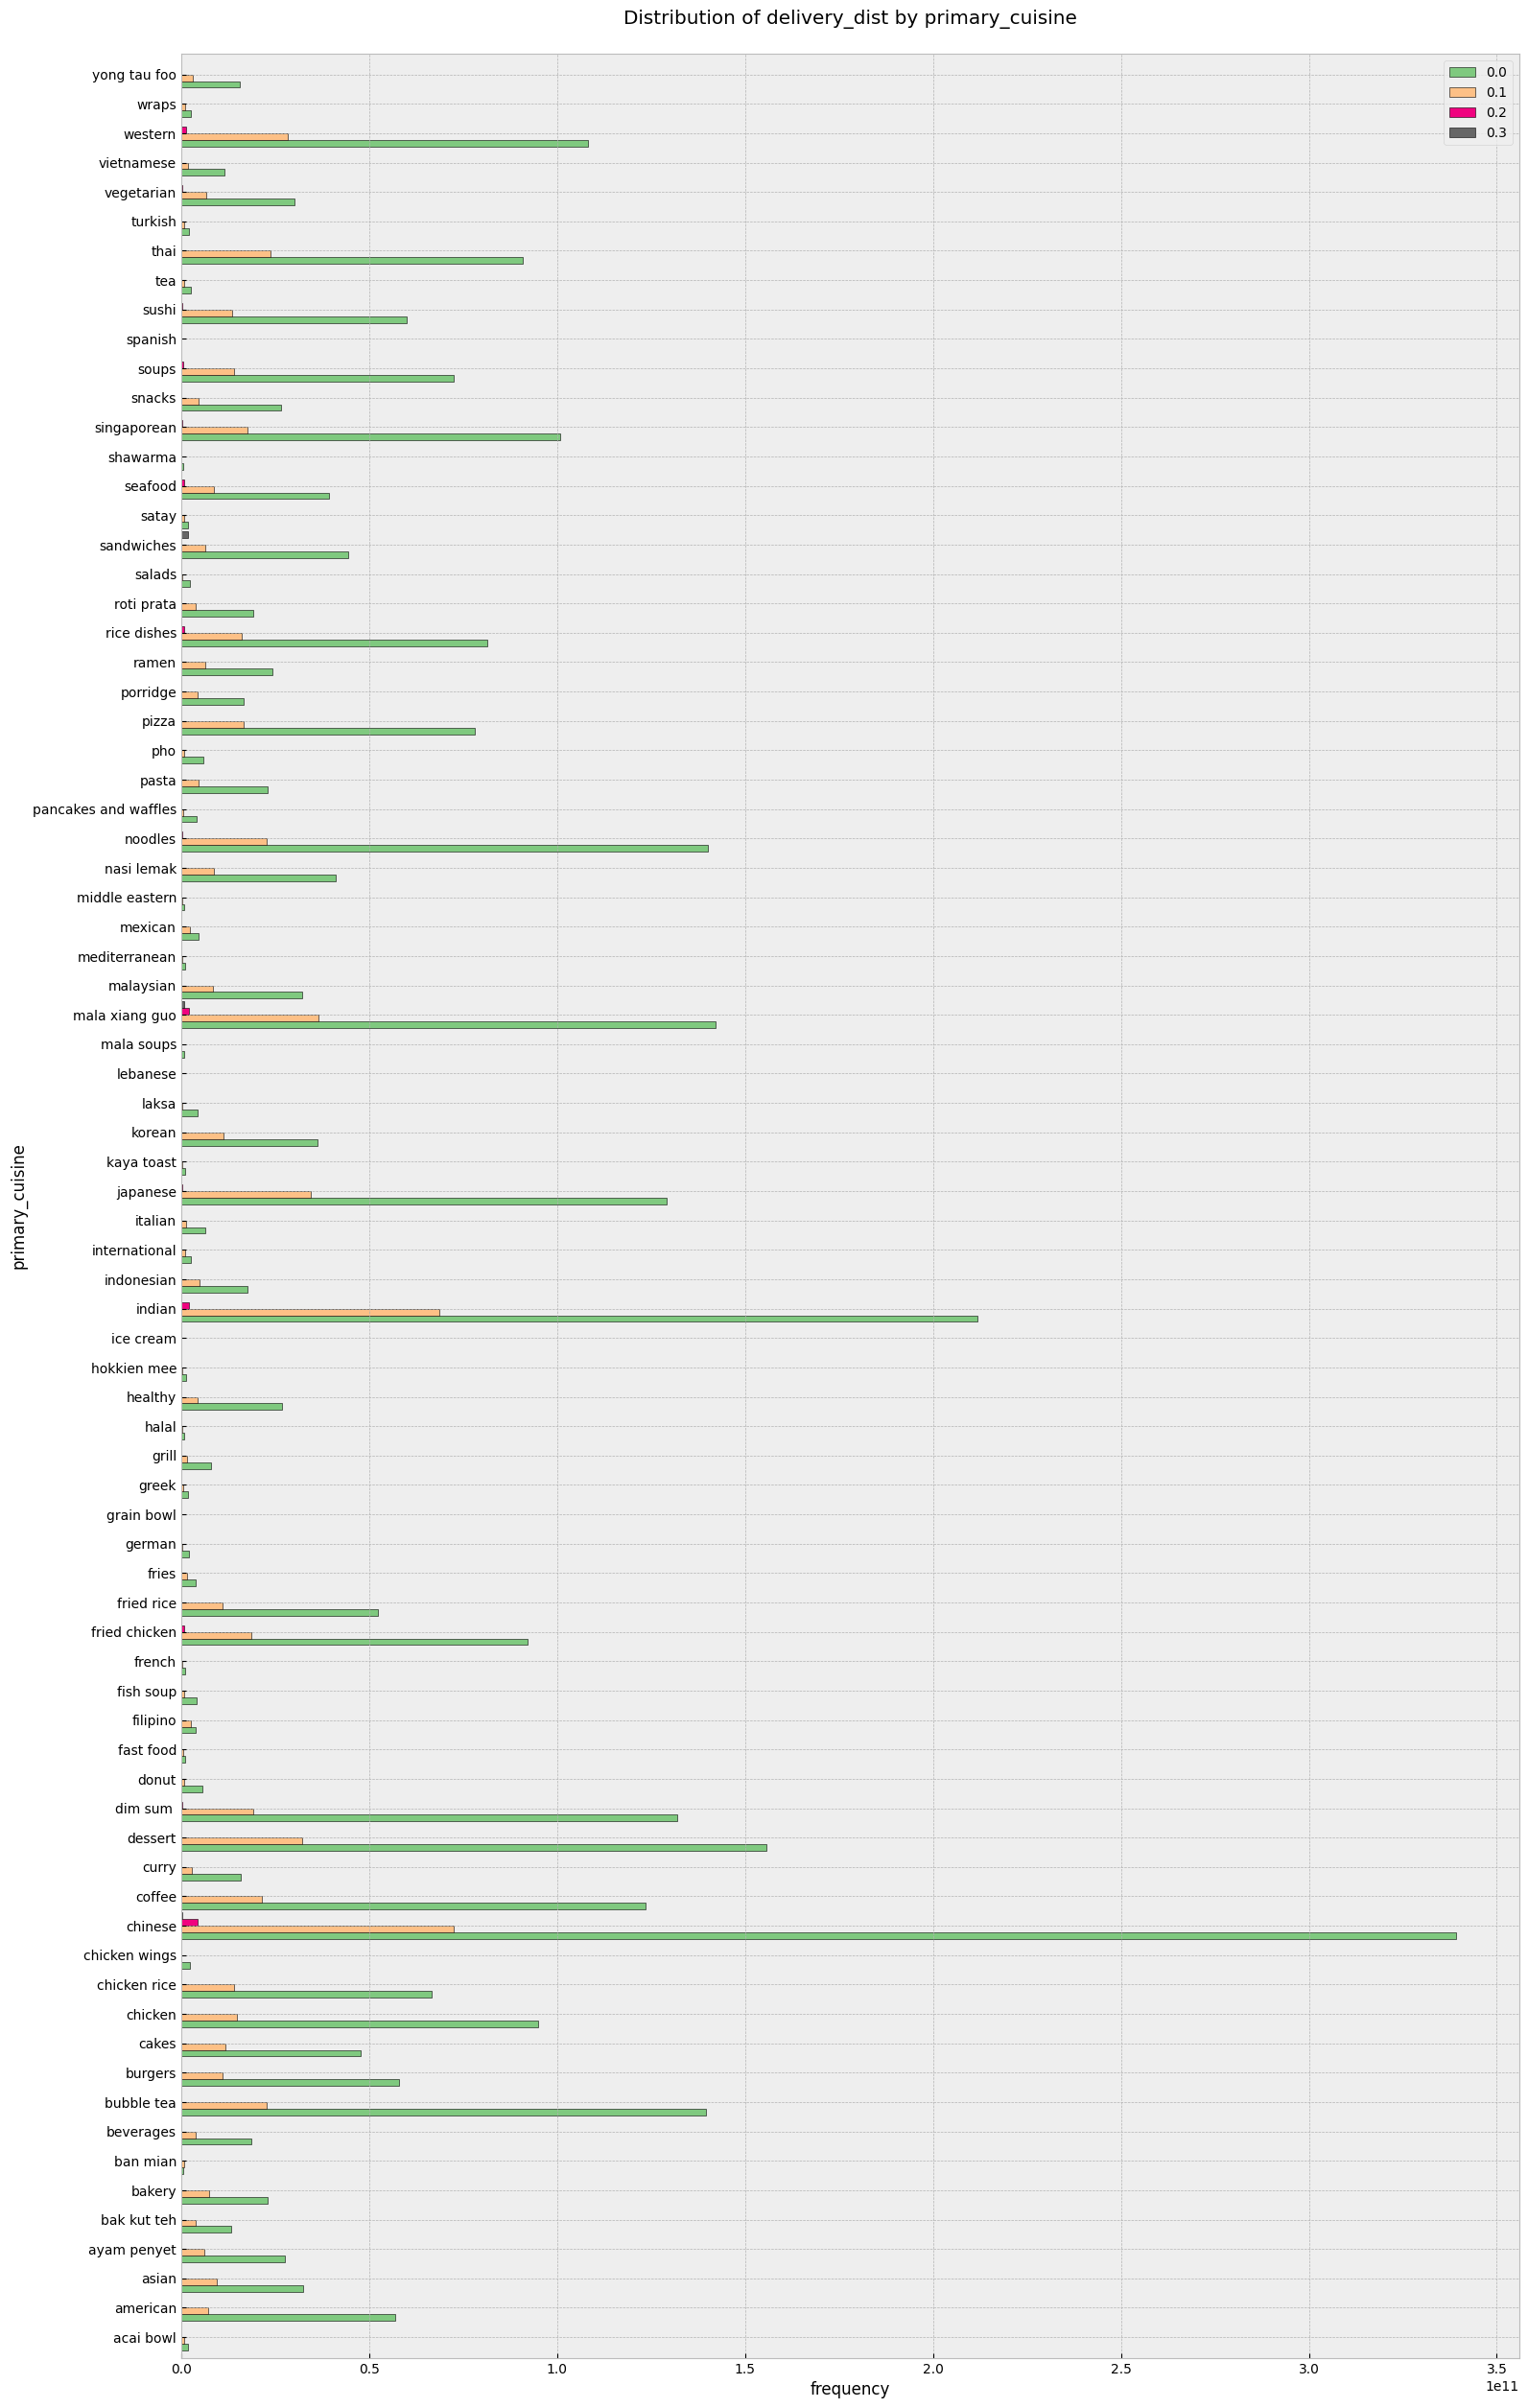

In [256]:
count_cross_plot(merged2, 'delivery_dist', 'primary_cuisine', 'sum', 'Accent')

Дальше всего возят satay, western кухню.

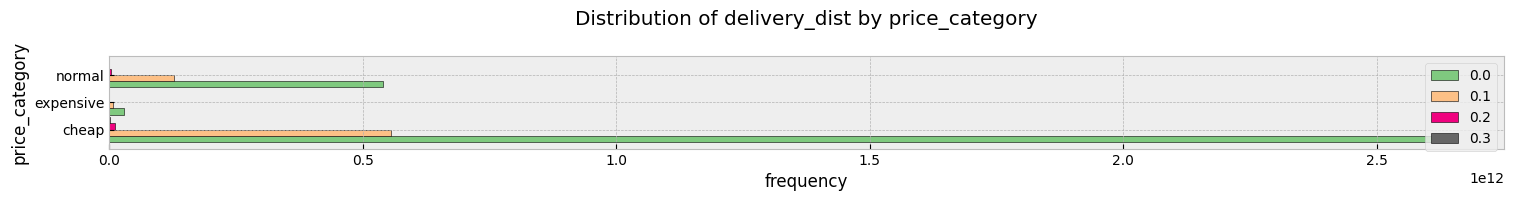

In [257]:
count_cross_plot(merged2, 'delivery_dist', 'price_category', 'sum', 'Accent')

#### Make Groupped Orders DS

In [259]:
merged2.columns

Index(['customer_id', 'geohash_order', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int',
       'geohash_shrunk', 'order_hour', 'day_part', 'name', 'unit_price',
       'to_drop', 'name_clean', 'name_clean_cut', 'chain_id', 'geohash_vendor',
       'primary_cuisine', 'neighbours', 'price_category', 'delivery_dist'],
      dtype='object')

In [260]:
%%time
# agg_func_count = {'product_id': ['count', 'nunique', 'size']}
# agg_func_text = {
#     'product_id': ['count', 'nunique', set],
#     'vendor_id': ['count', 'nunique', set], 
#     'order_day_int': [set],
#     'day_of_week': [set], 
#     'order_time': [set],
#     'order_hour': [set],
#     'name_clean_cut': [set], 
#     'geohash_shrunk': [set], 
#     'geohash_vendor': [set],
#     'primary_cuisine': [set, 'count', 'nunique'],
#     'price_category': [set, 'count', 'nunique'],
#     'delivery_dist': [set, 'count', 'nunique']
    
# }
# group = merged2.groupby('order_id').agg(agg_func_text)
# group.to_pickle('data/groupped_orders')

CPU times: total: 9min 22s
Wall time: 10min 52s


In [554]:
# group = pd.read_pickle('data/groupped_orders')

In [261]:
group

product_id          \
              count nunique   
order_id                      
0                 5       5   
1                 8       8   
2                 4       4   
3                 3       3   
4                 4       4   
...             ...     ...   
1999995           1       1   
1999996           2       2   
1999997           3       3   
1999998           2       2   
1999999           3       3   

                                                            vendor_id          \
                                                        set     count nunique   
order_id                                                                        
0         {30eba3cc2676, 20049fb602cb, 3910309eea60, 783...         5       1   
1         {01110c80a0fa, 146127be77d4, 5289a6f50a7b, 64a...         8       1   
2         {b47b2a83502a, a3e4aac0520d, 2c349859aa69, 4e1...         4       1   
3                {60a5baff060c, ad485fc36ebe, d732733afc92}         3       1   
4         {bc5f3e4a7234, 5bb2e3772724, ff6a45fa52e6, cbe...         4       1   
...                                                     ...       ...     ...   
1999995                                      {cad0a6aa5b51}         1       1   
1999996                        {6b36ca15e1f6, 142ad3401af3}         2       1   
1999997          {e418a2a168d8, 75ff2fb5b5ef, 3707116ae849}         3       1   
1999998                        {7602ccd87eea, 91129b65ae92}         2       1   
1999999          {5925157ecb14, 7bb67a5dd524, d40fe2db522c}         3       1   

                     order_day_int day_of_week  order_time order_hour  ...  \
                 set           set         set         set        set  ...   
order_id                                                               ...   
0         {212753d2}          {85}         {0}  {12:03:29}       {12}  ...   
1         {21830106}          {61}         {4}  {19:03:03}       {19}  ...   
2         {ee4f2ee0}           {8}         {0}  {18:08:42}       {18}  ...   
3         {b62d39b7}          {59}         {2}  {19:05:15}       {19}  ...   
4         {e33ad7ec}          {81}         {3}  {20:13:08}       {20}  ...   
...              ...           ...         ...         ...        ...  ...   
1999995   {2dbc05bb}          {32}         {3}  {16:21:22}       {16}  ...   
1999996   {43bd9cf3}           {4}         {3}  {15:57:51}       {15}  ...   
1999997   {81960769}          {28}         {6}  {10:27:34}       {10}  ...   
1999998   {ff0edd9f}          {55}         {5}  {22:09:10}       {22}  ...   
1999999   {2bba6450}          {62}         {5}  {19:57:51}       {19}  ...   

         geohash_vendor primary_cuisine                     price_category  \
                    set             set count nunique                  set   
order_id                                                                     
0               {w21z7}         {ramen}     5       1             {normal}   
1               {w21zt}       {western}     8       1              {cheap}   
2               {w21z7}    {vietnamese}     4       1              {cheap}   
3               {w21z3}         {pizza}     3       1             {normal}   
4               {w21z6}         {pasta}     4       1  {expensive, normal}   
...                 ...             ...   ...     ...                  ...   
1999995         {w21zt}    {nasi lemak}     1       1             {normal}   
1999996         {w21zt}   {singaporean}     2       1              {cheap}   
1999997         {w21zt}         {cakes}     3       1              {cheap}   
1999998         {w21zv}         {pasta}     2       1              {cheap}   
1999999         {w21zv}    {fried rice}     3       1      {cheap, normal}   

                       delivery_dist                
         count nunique           set count nunique  
order_id                                            
0            5       1         {0.0}     5       1  
1            8       1         {0.0}     

In [266]:
print('В заказах нет повторяющихся продуктов (после очистки), до очистки были - ', all(group[('product_id', 'nunique')] == group[('product_id', 'count')]))
print('Каждому уникальному заказу соответствует только один вендор - ', all(group[('vendor_id', 'nunique')] == 1))
print('В заказах нет повторяющихся вендоров - ', all(group[('vendor_id', 'nunique')] == group[('vendor_id', 'count')]))
print('\n')
print('В каждом уникальном заказе есть только один товар - ', all(group['name_clean_cut', 'set'].str.len() == 1))
print('В каких-то заказах есть только один товар - ', any(group['name_clean_cut', 'set'].str.len() == 1))
print('Есть заказы в которых нет товаров - ', any(group['name_clean_cut', 'set'].str.len() == 0))
print('\n')
print('Каждому уникальному заказу соответствует только 1 геохэш - ', all(group['geohash_shrunk', 'set'].str.len() == 1))
print('Каждому уникальному заказу соответствуют товары только одной кухни - ', all(group['primary_cuisine', 'set'].str.len() == 1))
print('Каждому уникальному заказу соответствует только одно время заказа - ', all(group['order_time', 'set'].str.len() == 1))
print('Каждому уникальному заказу соответствует только один день заказа - ', all(group['day_of_week', 'set'].str.len() == 1))
print('\n')
print('Каждому уникальному заказу соответствует только один час заказа - ', all(group['order_hour', 'set'].str.len() == 1))
print('Каждому уникальному заказу соответствует только один вендор геохэш - ', all(group['geohash_vendor', 'set'].str.len() == 1))

print('', '\n')
print('Во всех заказах только по одной кухне в заказе - ', all(group[('primary_cuisine', 'nunique')] == 1))
print('Во всех заказах нет повторяющихся кухонь - (фолс)', all(group[('primary_cuisine', 'nunique')] == group[('primary_cuisine', 'count')]))
print('Во всех заказах только по одной ценовой категории товара в заказе - ', all(group['price_category', 'set'].str.len() == 1))
print('Во всех заказах только по одной дальности доставки товара в заказе - ', all(group['delivery_dist', 'set'].str.len() == 1))
print('Каждому уникальному заказу соответствует только одна ценовая категория для всех товаров заказа - ', all(group[('price_category', 'nunique')] == 1))
print('В заказах нет дублирующихся ценовых категорий товаров (фолс) - ', all(group[('price_category', 'nunique')] == group[('price_category', 'count')]))
print('Каждому уникальному заказу соответствует только одна дальности доставки для всех товаров заказа - ', all(group[('delivery_dist', 'nunique')] == 1))
print('В заказах нет дублирующихся дальностей доставки (фолс) - ', all(group[('delivery_dist', 'nunique')] == group[('delivery_dist', 'count')]))

В заказах нет повторяющихся продуктов (после очистки), до очистки были -  True
Каждому уникальному заказу соответствует только один вендор -  True
В заказах нет повторяющихся вендоров -  False


В каждом уникальном заказе есть только один товар -  False
В каких-то заказах есть только один товар -  True
Есть заказы в которых нет товаров -  False


Каждому уникальному заказу соответствует только 1 геохэш -  True
Каждому уникальному заказу соответствуют товары только одной кухни -  True
Каждому уникальному заказу соответствует только одно время заказа -  True
Каждому уникальному заказу соответствует только один день заказа -  True


Каждому уникальному заказу соответствует только один час заказа -  True
Каждому уникальному заказу соответствует только один вендор геохэш -  True
 

Во всех заказах только по одной кухне в заказе -  True
Во всех заказах нет повторяющихся кухонь - (фолс) False
Во всех заказах только по одной ценовой категории товара в заказе -  False
Во всех заказах только по 

**Всё верно!**

- в одном заказе всегда только разные товары (тк мы удалили дубли)
- в одном заказе не всегда только 1 вендор и бывают дублирующиеся вендоры, что ок
- в одном заказе товары с разными названиями
- одному заказу всегда соответствует 1 хэш заказа и иногда несколько хэшей вендора, всегда 1 тип кухни, 1 день и 1 время - тут все логично, кроме типа кухни

если у заказа бывает несколько вендоров, а у каждого вендора своя кухня, то было бы логично, чтобы внутри одного заказа иногда попадались разные кухни

In [268]:
groupped_orders = group[[('vendor_id', 'set'), 
                         ('product_id', 'set'), 
                         ('order_day_int', 'set'), 
                         ('day_of_week', 'set'), 
                         ('geohash_shrunk', 'set'),
                         ('geohash_vendor', 'set'),
                         ('order_time', 'set'),
                         ('order_hour', 'set'),
                         ('name_clean_cut', 'set'),
                         ('primary_cuisine', 'set'),
                         ('price_category', 'set'),
                         ('delivery_dist', 'set')]].copy(deep=True)

groupped_orders.columns = groupped_orders.columns.droplevel(-1)

In [269]:
groupped_orders

vendor_id                                         product_id  \
order_id                                                                  
0         {212753d2}  {30eba3cc2676, 20049fb602cb, 3910309eea60, 783...   
1         {21830106}  {01110c80a0fa, 146127be77d4, 5289a6f50a7b, 64a...   
2         {ee4f2ee0}  {b47b2a83502a, a3e4aac0520d, 2c349859aa69, 4e1...   
3         {b62d39b7}         {60a5baff060c, ad485fc36ebe, d732733afc92}   
4         {e33ad7ec}  {bc5f3e4a7234, 5bb2e3772724, ff6a45fa52e6, cbe...   
...              ...                                                ...   
1999995   {2dbc05bb}                                     {cad0a6aa5b51}   
1999996   {43bd9cf3}                       {6b36ca15e1f6, 142ad3401af3}   
1999997   {81960769}         {e418a2a168d8, 75ff2fb5b5ef, 3707116ae849}   
1999998   {ff0edd9f}                       {7602ccd87eea, 91129b65ae92}   
1999999   {2bba6450}         {5925157ecb14, 7bb67a5dd524, d40fe2db522c}   

         order_day_int day_of_week geohash_shrunk geohash_vendor  order_time  \
order_id                                                                       
0                 {85}         {0}        {w21z5}        {w21z7}  {12:03:29}   
1                 {61}         {4}        {w21zx}        {w21zt}  {19:03:03}   
2                  {8}         {0}        {w21z1}        {w21z7}  {18:08:42}   
3                 {59}         {2}        {w21z1}        {w21z3}  {19:05:15}   
4                 {81}         {3}        {w21z1}        {w21z6}  {20:13:08}   
...                ...         ...            ...            ...         ...   
1999995           {32}         {3}        {w21zx}        {w21zt}  {16:21:22}   
1999996            {4}         {3}        {w21zx}        {w21zt}  {15:57:51}   
1999997           {28}         {6}        {w21zx}        {w21zt}  {10:27:34}   
1999998           {55}         {5}        {w21zx}        {w21zv}  {22:09:10}   
1999999           {62}         {5}        {w21zx}        {w21zv}  {19:57:51}   

         order_hour                                     name_clean_cut  \
order_id                                                                 
0              {12}  {japanese beef yakiniku don, teriyaki salmon d...   
1              {19}  {grilled fish, saba fish with rice, chicken ch...   
2              {18}  {v beef noodle soup, v spring rolls, v summer ...   
3              {19}   {cinque formaggi, diavola, linguine al granchio}   
4              {20}  {da paolo dolcetto, bruschetta, valrhona choc ...   
...             ...                                                ...   
1999995        {16}        {buddy meal a x nasi lemak bergedil drinks}   
1999996        {15}     {r nasi goreng kampung, d crispy chicken roll}   
1999997        {10}               {curry puff, tuna puff, chicken pie}   
1999998        {22}  {smoked duck penne with thai sauce, laksa praw...   
1999999        {19}  {beef, a salted egg chicken cutlet, tom yam fr...   

         primary_cuisine       price_category delivery_dist  
order_id                                                     
0                {ramen}             {normal}         {0.0}  
1              {western}              {cheap}         {0.0}  
2           {vietnamese}              {cheap}         {0.1}  
3                {pizza}             {normal}         {0.0}  
4                {pasta}  {expensive, normal}         {0.0}  
...                  ...                  ...           ...  
1999995     {nasi lemak}             {normal}         {0.0}  
1999996    {singaporean}              {cheap}         {0.0}  
1999997          {cakes}              {cheap}         {0.0}  
1999998          {pasta}              {cheap}         {0.1}  
1999999     {fried rice}      {cheap, normal}         {0.1}  

[1997886 rows x 12 columns]

In [270]:
# de-set data
groupped_orders[['order_day_int', 'day_of_week', 'order_time', 'order_hour', 'primary_cuisine', 'geohash_shrunk', 'delivery_dist']] = \
groupped_orders[['order_day_int', 'day_of_week', 'order_time', 'order_hour', 'primary_cuisine', 'geohash_shrunk', 'delivery_dist']].explode(['order_day_int', 'day_of_week', 
                                                                                                                             'order_time', 'order_hour', 'primary_cuisine', 
                                                                                                                             'geohash_shrunk', 'delivery_dist'])

In [271]:
groupped_orders['product_id'] = groupped_orders['product_id'].parallel_apply(lambda x: list(x))
groupped_orders['vendor_id'] = groupped_orders['vendor_id'].parallel_apply(lambda x: list(x))
groupped_orders['name_clean_cut'] = groupped_orders['name_clean_cut'].parallel_apply(lambda x: list(x))
groupped_orders['geohash_vendor'] = groupped_orders['geohash_vendor'].parallel_apply(lambda x: list(x))
groupped_orders['price_category'] = groupped_orders['price_category'].parallel_apply(lambda x: list(x))

In [272]:
groupped_orders = groupped_orders.reset_index()

In [273]:
groupped_orders.to_pickle('data/groupped_orders_proc')

In [274]:
groupped_orders

order_id   vendor_id  \
0               0  [212753d2]   
1               1  [21830106]   
2               2  [ee4f2ee0]   
3               3  [b62d39b7]   
4               4  [e33ad7ec]   
...           ...         ...   
1997881   1999995  [2dbc05bb]   
1997882   1999996  [43bd9cf3]   
1997883   1999997  [81960769]   
1997884   1999998  [ff0edd9f]   
1997885   1999999  [2bba6450]   

                                                product_id order_day_int  \
0        [30eba3cc2676, 783e85338f1c, 20049fb602cb, 391...            85   
1        [6c108c0fb2b9, 146127be77d4, da422c7836e1, 64a...            61   
2        [a3e4aac0520d, 2c349859aa69, 4e1d649b81a5, b47...             8   
3               [60a5baff060c, ad485fc36ebe, d732733afc92]            59   
4        [5bb2e3772724, cbe8ace5c352, bc5f3e4a7234, ff6...            81   
...                                                    ...           ...   
1997881                                     [cad0a6aa5b51]            32   
1997882                       [6b36ca15e1f6, 142ad3401af3]             4   
1997883         [3707116ae849, 75ff2fb5b5ef, e418a2a168d8]            28   
1997884                       [91129b65ae92, 7602ccd87eea]            55   
1997885         [7bb67a5dd524, d40fe2db522c, 5925157ecb14]            62   

        day_of_week geohash_shrunk geohash_vendor order_time order_hour  \
0                 0          w21z5        [w21z7]   12:03:29         12   
1                 4          w21zx        [w21zt]   19:03:03         19   
2                 0          w21z1        [w21z7]   18:08:42         18   
3                 2          w21z1        [w21z3]   19:05:15         19   
4                 3          w21z1        [w21z6]   20:13:08         20   
...             ...            ...            ...        ...        ...   
1997881           3          w21zx        [w21zt]   16:21:22         16   
1997882           3          w21zx        [w21zt]   15:57:51         15   
1997883           6          w21zx        [w21zt]   10:27:34         10   
1997884           5          w21zx        [w21zv]   22:09:10         22   
1997885           5          w21zx        [w21zv]   19:57:51         19   

                                            name_clean_cut primary_cuisine  \
0        [chicken cutlet don, teriyaki salmon don, japa...           ramen   
1        [saba fish with rice, tomato sauce spaghetti, ...         western   
2        [v beef noodle soup, v summer rolls, v vietnam...      vietnamese   
3         [cinque formaggi, diavola, linguine al granchio]           pizza   
4        [valrhona choc cake, bruschetta, house salad, ...           pasta   
...                                                    ...             ...   
1997881        [buddy meal a x nasi lemak bergedil drinks]      nasi lemak   
1997882     [d crispy chicken roll, r nasi goreng kampung]     singaporean   
1997883               [curry puff, tuna puff, chicken pie]           cakes   
1997884  [laksa prawn spaghetti, smoked duck penne with...           pasta   
1997885  [a salted egg chicken cutlet, beef, tom yam fr...      fried rice   

              price_category delivery_dist  
0                   [normal]           0.0  
1                    [cheap]           0.0  
2                    [cheap]           0.1  
3                   [normal]           0.0  
4        [expensive, normal]           0.0  
...                      ...           ...  
1997881             [normal]           0.0  
1997882              [cheap]           0.0  
1997883              [cheap]           0.0  
1997884              [cheap]           0.1  
1997885      [normal, cheap]           0.1  

[1997886 rows x 13 columns]

In [275]:
groupped_orders.duplicated(['order_id']).sum()

0

In [279]:
groupped_orders.duplicated(['order_id', 'geohash_shrunk']).sum()

0

**Доп исследование истории заказов**

## Correlation Analysis

In [280]:
from sklearn.preprocessing import LabelEncoder

In [281]:
merged2.columns

Index(['customer_id', 'geohash_order', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int',
       'geohash_shrunk', 'order_hour', 'day_part', 'name', 'unit_price',
       'to_drop', 'name_clean', 'name_clean_cut', 'chain_id', 'geohash_vendor',
       'primary_cuisine', 'neighbours', 'price_category', 'delivery_dist'],
      dtype='object')

In [282]:
le = LabelEncoder()
merged2['price_category_enc'] = le.fit_transform(merged2.price_category)
merged2['primary_cuisine_enc'] = le.fit_transform(merged2.primary_cuisine)

In [284]:
merged2[['day_of_week',  'order_day_int', 'order_hour',
        'unit_price', 'delivery_dist', 
         'price_category_enc', 'primary_cuisine_enc']].corr()

day_of_week  order_day_int  order_hour  unit_price  \
day_of_week             1.000000       0.008268   -0.000414    0.029381   
order_day_int           0.008268       1.000000   -0.003169   -0.009198   
order_hour             -0.000414      -0.003169    1.000000    0.086232   
unit_price              0.029381      -0.009198    0.086232    1.000000   
delivery_dist           0.004708       0.004874    0.006178    0.017277   
price_category_enc      0.023174      -0.001832    0.072021    0.682294   
primary_cuisine_enc    -0.005818       0.006676    0.008032    0.096532   

                     delivery_dist  price_category_enc  primary_cuisine_enc  
day_of_week               0.004708            0.023174            -0.005818  
order_day_int             0.004874           -0.001832             0.006676  
order_hour                0.006178            0.072021             0.008032  
unit_price                0.017277            0.682294             0.096532  
delivery_dist             1.000000            0.016347             0.020989  
price_category_enc        0.016347            1.000000             0.080005  
primary_cuisine_enc       0.020989            0.080005             1.000000

interval columns not set, guessing: ['day_of_week', 'order_day_int', 'order_hour', 'unit_price', 'delivery_dist']
CPU times: total: 28.2 s
Wall time: 31.8 s


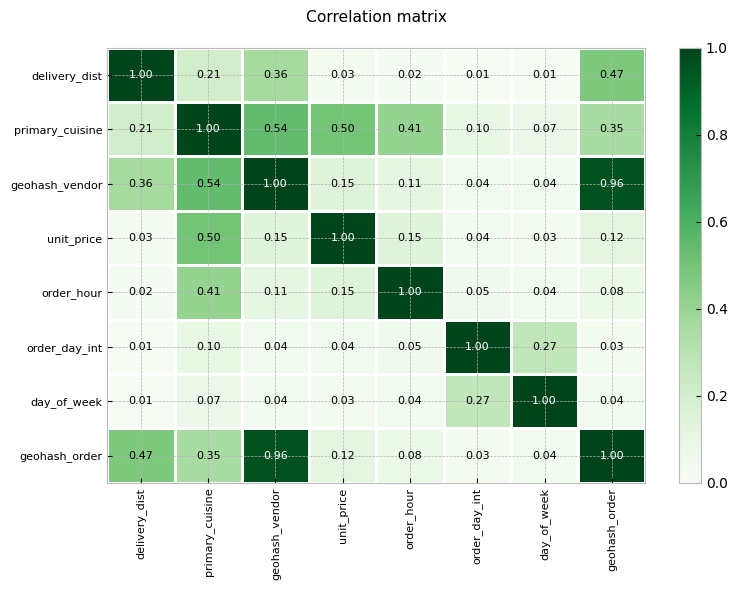

In [285]:
%%time
data_corr = merged2[[
    'geohash_order', 
    'day_of_week', 'order_day_int', 'order_hour',
    'unit_price', 
    'geohash_vendor',
    'primary_cuisine', 'delivery_dist'
]].phik_matrix().round(2)

plot_correlation_matrix(
    data_corr.values, 
    x_labels=data_corr.columns, 
    y_labels=data_corr.index, 
    vmin=0, 
    vmax=1, 
    color_map='Greens',  # 'Accent' winter blues
    title='Correlation matrix\n', 
    fontsize_factor=0.8, 
    figsize=(8, 6)
)

## Train Test Split

In [286]:
o_tr = pd.read_csv('data/orders_sg_train.txt')
o_ts = pd.read_csv('data/orders_sg_test.txt')

print(o_tr.shape, o_ts.shape, orders_sg.shape)
assert o_tr.shape[0] + o_ts.shape[0] == orders_sg.shape[0]

(3431870, 9) (591135, 9) (4023005, 13)


In [290]:
assert set(o_tr.order_id) | set(o_ts.order_id) == set(orders_sg.order_id)

In [292]:
assert set(o_tr.order_id) & set(o_ts.order_id) == set()

In [293]:
assert set(o_tr.customer_id) | set(o_ts.customer_id) == set(orders_sg.customer_id)

In [294]:
print(o_tr.shape[0] / orders_sg.shape[0] * 100, o_ts.shape[0] / orders_sg.shape[0] * 100)

85.30613310199713 14.693866898002861


In [295]:
o_tr.shape[0] / orders_sg.shape[0] * 100 +  o_ts.shape[0] / orders_sg.shape[0] * 100 == 100

True

In [296]:
data_train = merged2[merged2.order_id.isin(o_tr.order_id)]
data_test = merged2[merged2.order_id.isin(o_ts.order_id)]

In [297]:
set(data_train.order_id) | set(data_test.order_id) == set(merged2.order_id)

True

In [298]:
set(data_train.order_id) & set(data_test.order_id) == set()

True

In [299]:
set(data_train.customer_id) | set(data_test.customer_id) == set(merged2.customer_id)

True

In [632]:
print(data_train.shape[0] / merged2.shape[0] * 100, data_test.shape[0] / merged2.shape[0] * 100)

85.305079573106 14.694920426893995


Проверяем соотнотношение данных - все ли одни и те же айди есть в трейне и тесте

In [302]:
len(set(data_train.customer_id) & set(data_test.customer_id))

134616

In [303]:
# есть проблема с тем, что не все id пользователей из трейна попадают в тест
set(data_train.customer_id) == set(data_test.customer_id)

False

In [304]:
# from sklearn.model_selection import train_test_split

# tr, ts = train_test_split(merged2, test_size=0.146949, random_state=42)
# использовать обычный трейн тест сплит по merged2 неудобно, 
# потому что он делит некоторые заказы кусками - часть одного заказа оказывается в тесте а другая в тр
# нужно использовать

In [310]:
data_train.to_csv('train_data.txt')
data_test.to_csv('test_data.txt')

In [311]:
print(data_train.shape,
      data_test.shape)

(3343031, 25) (575881, 25)


In [312]:
data_train.columns

Index(['customer_id', 'geohash_order', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int',
       'geohash_shrunk', 'order_hour', 'day_part', 'name', 'unit_price',
       'to_drop', 'name_clean', 'name_clean_cut', 'chain_id', 'geohash_vendor',
       'primary_cuisine', 'neighbours', 'price_category', 'delivery_dist',
       'price_category_enc', 'primary_cuisine_enc'],
      dtype='object')

>OUTCOME

- Сделана фича с временем суток
- Сделана фича с соседями по геохэшу
- Сделана фича с расстоянием между вендором и заказчиком

- Отрезаем дни с 39 по 90 (не в еда)
- Отрезаем цену выше 0.003
- Не отрезали пока нулевые цены
-НЕ отрезали пока популярные товары, покупателей

- Нашла что геохэши повторяются (скорее всего из-за плохого геокодирования)

- Выкинуты товары без имени
- Устранены дубли по изменившимся вендорам в продуктах - заменила новых вендооов на старых
- Устранены ошибки в названиях продуктов

- Очищены имена от лишних символов и иерогливфов
- Удалены пустые после очистки имена
- Обрезаны длинные названия для красоты вывода

- Задались вопросом что за геохэши в вендорах

- Сделали общий датасет и почистили его от неявных дублей с ошибками по продуктам и именам + сбросили дублирующиеся товары в заказе 

*Доделки на будущее*

- Сделать ранжирование по соседним геохэшам
- Выкидывать самых популярных товары и заказчиков?
- Предсказывать по времени суток
- Не удалять иероглифы, а перевести
- Использовать NKP и более аккуратно почистить названия
- Можно рекомендовать исходя из кухни или ранжировать при указании любимой кухни
- Предложения на основе сети вендора
- Предлагать по существующему распределению в конкретные дни кухни которые больше популярные в эти дни